[SCEC BP3-QD](https://strike.scec.org/cvws/seas/download/SEAS_BP3.pdf) document is here.

In [1]:
from tectosaur2.nb_config import setup

setup()

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term
from tectosaur2.elastic2d import elastic_t, elastic_h
from tectosaur2.mesh import panelize_symbolic_surface
from tectosaur2.debug import plot_centers

In [3]:
surf_half_L = 1000000
fault_length = 40000
max_panel_length = 400
n_fault = 400
mu = shear_modulus = 3.2e10
nu = 0.25

qx, qw = gauss_rule(6)
sp_t = sp.var("t")

edges = np.linspace(-1, 1, n_fault+1)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
angle_rad = sp.pi / 6
sp_x = (sp_t + 1) / 2 * sp.cos(angle_rad) * fault_length
sp_y = -(sp_t + 1) / 2 * sp.sin(angle_rad) * fault_length
fault = panelize_symbolic_surface(
    sp_t, sp_x, sp_y,
    panel_bounds,
    qx, qw
)

free = refine_surfaces(
    [
        (sp_t, -sp_t * surf_half_L, 0 * sp_t)  # free surface
    ],
    (qx, qw),
    control_points = [
        # nearfield surface panels and fault panels will be limited to 200m
        # at 200m per panel, we have ~40m per solution node because the panels
        # have 5 nodes each
        (0, 0, 1.5 * fault_length, max_panel_length),
        (0, 0, 0.2 * fault_length, 1.5 * fault_length / (n_fault)),
        # farfield panels will be limited to 200000 m per panel at most
        (0, 0, surf_half_L, 50000),
    ]
)
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The free surface mesh has 646 panels with a total of 3876 points.
The fault mesh has 400 panels with a total of 2400 points.


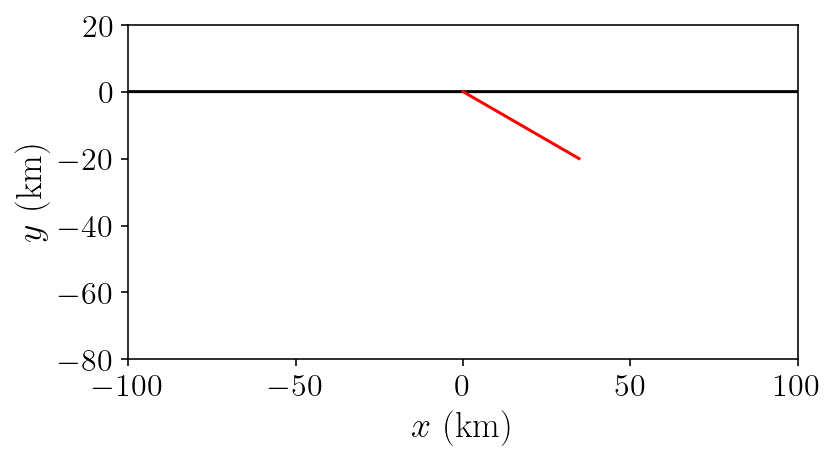

In [ ]:
plt.plot(free.pts[:,0]/1000, free.pts[:,1]/1000, 'k-o')
plt.plot(fault.pts[:,0]/1000, fault.pts[:,1]/1000, 'r-o')
plt.xlabel(r'$x ~ \mathrm{(km)}$')
plt.ylabel(r'$y ~ \mathrm{(km)}$')
plt.axis('scaled')
plt.xlim([-100, 100])
plt.ylim([-80, 20])
plt.show()

And, to start off the integration, we'll construct the operators necessary for solving for free surface displacement from fault slip.

In [5]:
singularities = np.array(
    [
        [-surf_half_L, 0],
        [surf_half_L, 0],
        [0, 0],
        [float(sp_x.subs(sp_t,1)), float(sp_y.subs(sp_t,1))],
    ]
)

In [6]:
(free_disp_to_free_disp, fault_slip_to_free_disp), report = integrate_term(
    elastic_t(nu), free.pts, free, fault, singularities=singularities, safety_mode=True, return_report=True
)

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:174: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:180: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


In [7]:

fault_slip_to_free_disp = fault_slip_to_free_disp.reshape((-1, 2 * fault.n_pts))
free_disp_to_free_disp = free_disp_to_free_disp.reshape((-1, 2 * free.n_pts))
free_disp_solve_mat = (
    np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
)

In [8]:
from tectosaur2.elastic2d import ElasticH
(free_disp_to_fault_stress, fault_slip_to_fault_stress), report = integrate_term(
    # Integration is much easier if the output are order 1, so we
    # pass a shear_modulus of 1.0 and then multiply by shear_modulus later
    ElasticH(nu, d_cutoff=8.0),
    # elastic_h(nu),
    fault.pts,
    free,
    fault,
    tol=1e-12,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)
fault_slip_to_fault_stress *= shear_modulus
free_disp_to_fault_stress *= shear_modulus

In [9]:

A = -fault_slip_to_fault_stress.reshape((-1, 2*fault.n_pts))
B = -free_disp_to_fault_stress.reshape((-1, 2*free.n_pts))
C = fault_slip_to_free_disp
Dinv = np.linalg.inv(free_disp_solve_mat)
total_fault_slip_to_fault_stress = A - B.dot(Dinv.dot(C))

nx = fault.normals[:, 0]
ny = fault.normals[:, 1]
normal_mult = np.transpose(np.array([
    [nx, 0*nx, ny], [0*nx, ny, nx]
]), (2,0,1))

total_fault_slip_to_fault_traction = np.sum(
    total_fault_slip_to_fault_stress.reshape((-1,3,fault.n_pts,2))[:,None,:,:,:] * normal_mult[:, :, :, None, None], axis=2
).reshape((-1, 2 * fault.n_pts))

In [10]:
def exact_displacements(x):
    s = -1
    delta = np.arctan2(-float(sp_y.subs(sp_t,1)), float(sp_x.subs(sp_t,1)))
    d = -float(sp_y.subs(sp_t, 1))
    xd = float(sp_x.subs(sp_t, 1))#d / np.tan(delta)
    print(delta, d, xd)
    xsi = (x - xd) / d
    exact_ux = (-s / np.pi) * (
            np.cos(delta) * (np.arctan(xsi) - (np.pi / 2) * np.sign(x)) +
            (np.sin(delta) - xsi * np.cos(delta)) / (1 + xsi ** 2))
    exact_uy = (s / np.pi) * (
            np.sin(delta) * (np.arctan(xsi) - (np.pi / 2) * np.sign(x)) +
            (np.cos(delta) + xsi * np.sin(delta)) / (1 + xsi ** 2))
    return exact_ux, exact_uy
    
# def dislocation_stress(mu, nu, pts, x_dsl, d, s1, s2):
#     x = pts[:,0] - x_dsl
#     y = pts[:,1]
#     r1 = np.sqrt(x ** 2 + (y - d) **2)
#     r2 = np.sqrt(x ** 2 + (y + d) ** 2)
#     sxx = mu * s2 / (2 * np.pi * (1-nu)) * (
#         x * ((y - d)**2 - x**2) / (r1 ** 4)
#         - x * ((y + d) ** 2 - x**2) / (r2 ** 4)
#         + (4 * d * y / (r2 ** 6)) * ((2 * d - y) * (y + d) ** 2 + (3 * y + 2 * d) * x**2)
#     ) - 2 * mu * s1 / (
#         (y - d)* ((y-d)**2 + 3 * x**2) / (r1**4) 
#         - (y + d) * ((y + d) ** 2 + 3 * x**2) / (r2**4)
#         + 2 * y / (r2 ** 6) * (6*y*(y+d)*x**2 - (y - d) *(y+d)**3 - x**4)
#     )
#     return sxx

# def exact_stress(pts):
#     return dislocation_stress(1.0, nu, pts, 0, 0, np.sin(float(angle_rad)), np.cos(float(angle_rad)))

0.5235987755982989 20000.0 34641.016151377546


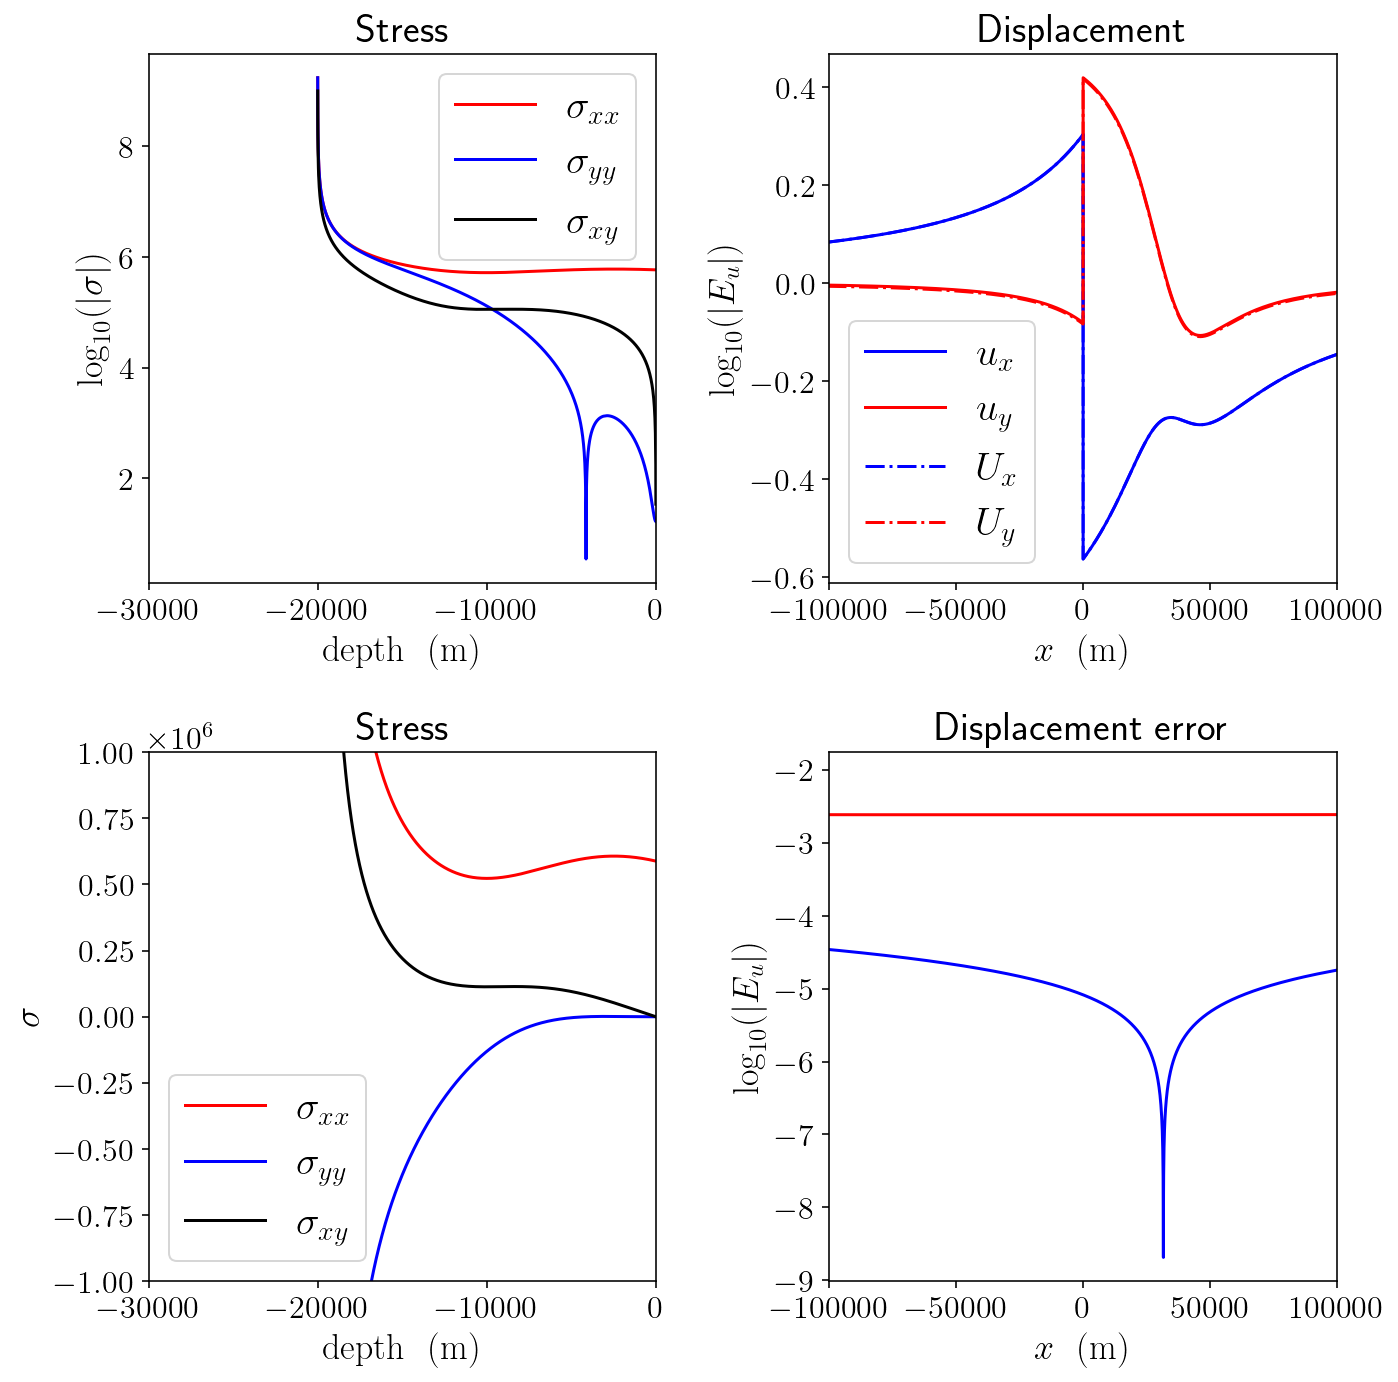

In [11]:
slip = np.stack((-ny, nx), axis=1)
slip_op = -Dinv.dot(C)
numerical_sd = slip_op.dot(slip.ravel())
analytical_ux, analytical_uy = exact_displacements(free.pts[:,0])
numerical_fs = total_fault_slip_to_fault_stress.dot(slip.ravel())

traction = total_fault_slip_to_fault_traction.dot(slip.ravel()).reshape((-1, 2))
sigma_qs = np.sum(traction * np.stack((nx, ny), axis=1), axis=1)
tau_qs = np.sum(traction * np.stack((-ny, nx), axis=1), axis=1)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Stress')
plt.plot(fault.pts[:,1], np.log10(np.abs(numerical_fs[::3])), 'r-', label=r'$\sigma_{xx}$')
plt.plot(fault.pts[:,1], np.log10(np.abs(numerical_fs[1::3])), 'b-', label=r'$\sigma_{yy}$')
plt.plot(fault.pts[:,1], np.log10(np.abs(numerical_fs[2::3])), 'k-', label=r'$\sigma_{xy}$')
plt.legend()
plt.xlim([np.min(fault.pts[:,1]), 0])
plt.xlim([-30000, 0])
plt.xlabel('$\mathrm{depth ~~ (m)}$')
plt.ylabel('$\log_{10}(|\sigma|)$')
plt.subplot(2,2,2)
plt.title('Displacement')
plt.plot(free.pts[:,0], numerical_sd[0::2], 'b-', label='$u_x$')
plt.plot(free.pts[:,0], numerical_sd[1::2], 'r-', label='$u_y$')
plt.plot(free.pts[:,0], analytical_ux, 'b-.', label='$U_x$')
plt.plot(free.pts[:,0], analytical_uy, 'r-.', label='$U_y$')
plt.legend()
plt.xlim([-100000, 100000])
plt.xlabel('$x ~~ \mathrm{(m)}$')
plt.ylabel('$\log_{10}(|E_u|)$')
plt.subplot(2,2,3)
plt.title('Stress')
plt.plot(fault.pts[:,1], numerical_fs[::3], 'r-', label=r'$\sigma_{xx}$')
plt.plot(fault.pts[:,1], numerical_fs[1::3], 'b-', label=r'$\sigma_{yy}$')
plt.plot(fault.pts[:,1], numerical_fs[2::3], 'k-', label=r'$\sigma_{xy}$')
plt.legend()
plt.xlim([np.min(fault.pts[:,1]), 0])
plt.xlim([-30000, 0])
plt.ylim([-1e6, 1e6])
plt.xlabel('$\mathrm{depth ~~ (m)}$')
plt.ylabel('$\sigma$')
plt.subplot(2,2,4)
plt.title('Displacement error')
plt.plot(free.pts[:,0], np.log10(np.abs(analytical_ux - numerical_sd[::2])), 'b-')
plt.plot(free.pts[:,0], np.log10(np.abs(analytical_uy - numerical_sd[1::2])), 'r-')
plt.xlim([-100000, 100000])
plt.xlabel('$x ~~ \mathrm{(m)}$')
plt.ylabel('$\log_{10}(|E_u|)$')
plt.tight_layout()
plt.show()

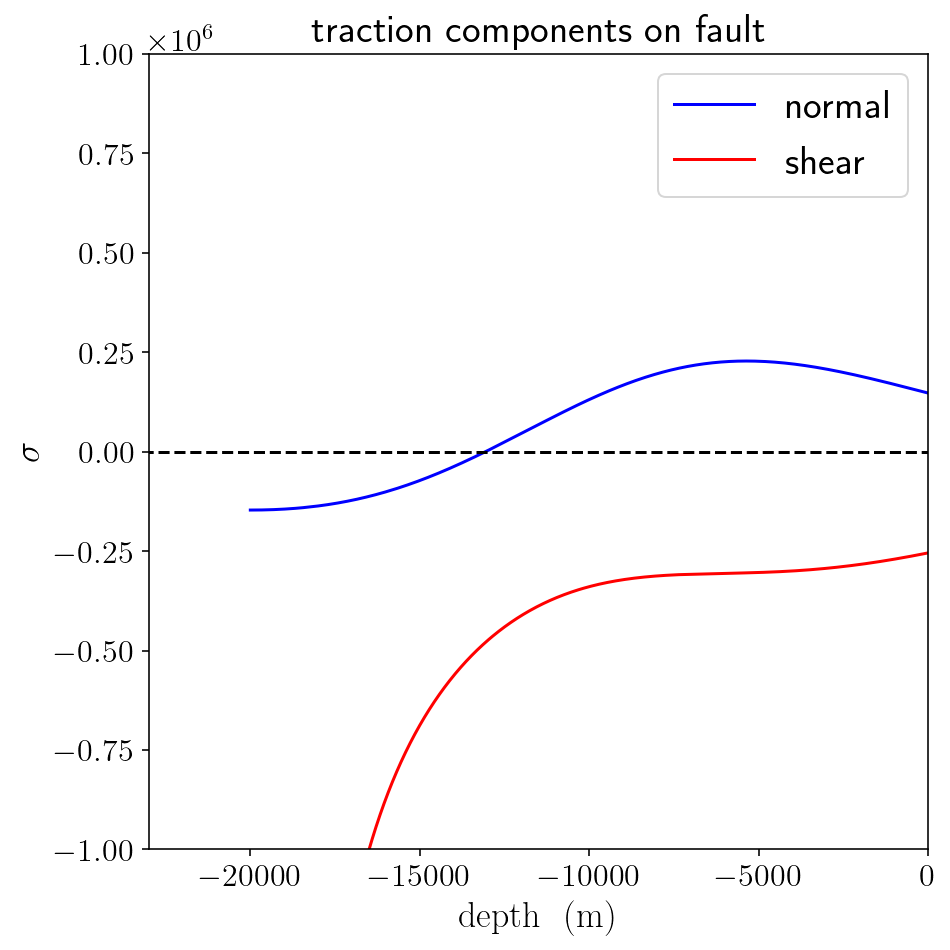

In [12]:

plt.figure(figsize=(7,7))
plt.title('traction components on fault')
plt.plot(fault.pts[:,1], sigma_qs, 'b-', label='normal')
plt.plot(fault.pts[:,1], tau_qs, 'r-', label='shear')
plt.hlines([0], [-30000], [0], 'k', linestyles=['dashed'])
plt.xlim([-23000, 0])
plt.ylim([-1e6, 1e6])
plt.xlabel('$\mathrm{depth ~~ (m)}$')
plt.ylabel('$\sigma$')
plt.legend()
plt.tight_layout()
plt.show()



## Rate and state friction

Okay, now that we've constructed the necessary boundary integral operators, we get to move on to describing the frictional behavior on the fault.

#### TODO: Explain!!

In [13]:
siay = 31556952  # seconds in a year
density = 2670  # rock density (kg/m^3)
cs = np.sqrt(shear_modulus / density)  # Shear wave speed (m/s)
eta = shear_modulus / (2 * cs)  # The radiation damping coefficient (kg / (m^2 * s))
Vp = 1e-9  # Rate of plate motion
sigma_n0 = 50e6  # Normal stress (Pa)

# parameters describing "a", the coefficient of the direct velocity strengthening effect
a0 = 0.01
amax = 0.025
H = 15000
h = 3000
fx = fault.pts[:, 0]
fy = fault.pts[:, 1]
fd = -np.sqrt(fx ** 2 + fy ** 2)
# fpd = -np.sqrt(fault.panel_centers[:,0] ** 2 + fault.panel_centers[:,1] ** 2j)
fp_a = np.where(
    fd > -H, a0, np.where(fd > -(H + h), a0 + (amax - a0) * (fd + H) / -h, amax)
)

# state-based velocity weakening effect
fp_b = 0.015

# state evolution length scale (m)
fp_Dc = 0.008

# baseline coefficient of friction
fp_f0 = 0.6

# if V = V0 and at steady state, then f = f0, units are m/s
fp_V0 = 1e-6


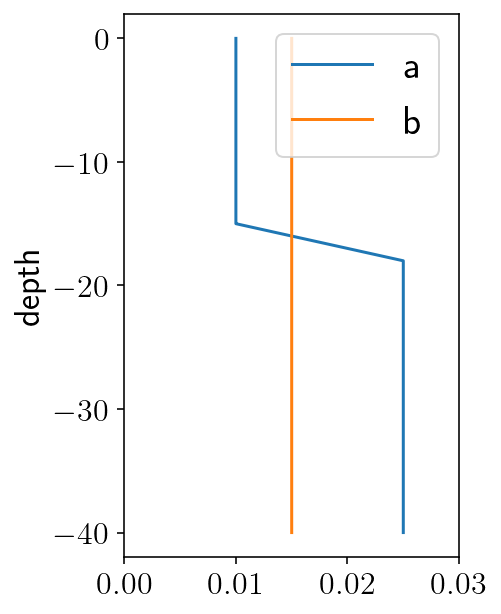

In [14]:
plt.figure(figsize=(3, 5))
plt.plot(fp_a, fd/1000, label='a')
plt.plot(np.full(fy.shape[0], fp_b), fd/1000, label='b')
plt.xlim([0, 0.03])
plt.ylabel('depth')
plt.legend()
plt.show()

In [26]:
# The regularized form of the aging law. 
def aging_law(V, state):
    return (fp_b * fp_V0 / fp_Dc) * (np.exp((fp_f0 - state) / fp_b) - (V / fp_V0))

def qd_equation(fp_a, normal_stress, shear_stress, V, state):
    # The regularized rate and state friction equation
    F = normal_stress * fp_a * np.arcsinh(V / (2 * fp_V0) * np.exp(state / fp_a))
    
    # The full shear stress balance:
    return shear_stress - eta * V - F

def qd_equation_dV(fp_a, normal_stress, V, state):
    # First calculate the derivative of the friction law with respect to velocity
    # This is helpful for equation solving using Newton's method
    expsa = np.exp(state / fp_a)
    Q = (V * expsa) / (2 * fp_V0)
    dFdV = fp_a * expsa * normal_stress / (2 * fp_V0 * np.sqrt(1 + Q * Q))

    # The derivative of the full shear stress balance.
    return -eta - dFdV


def solve_friction(fp_a, normal_stress, shear_stress, V_old, state, tol=1e-14):
    V = V_old
    max_iter = 150
    history=[]
    for i in range(max_iter):
        # Newton's method step!
        f = qd_equation(fp_a, normal_stress, shear_stress, V, state)
        dfdv = qd_equation_dV(fp_a, normal_stress, V, state)
        step = f / dfdv

        # We know that slip velocity should not be negative so any step that
        # would lead to negative slip velocities is "bad". In those cases, we
        # cut the step size in half iteratively until the step is no longer
        # bad. This is a backtracking line search.
        n_bad=0
        while True:
            bad = step > V
            if np.any(bad):
                n_bad += 1
                step[bad] *= 0.5
            else:
                break

        # Take the step and check if everything has converged.
        Vn = V - step
        history.append(history)
        if np.max(np.abs(step) / Vn) < tol:
            if n_bad > 0:
                print("BAD", n_bad)
            break
        V = Vn
        if i == max_iter - 1:
            print(history)
            raise Exception("Failed to converge.")

    # Return the solution and the number of iterations required.
    return Vn, i

We'll also check $h^*$ which is the minimum length scale of an instability and $L_b$, the length scale of the rupture process zone. Both these length scales need to be well resolved by the fault discretization. Here we have approximately eight point within the process zone and almost 80 points within $h^*$.

In [27]:
mesh_L = np.max(np.abs(np.diff(fd)))
Lb = shear_modulus * fp_Dc / (sigma_n0 * fp_b)
hstar = (np.pi * shear_modulus * fp_Dc) / (sigma_n0 * (fp_b - fp_a))
mesh_L, Lb, np.min(hstar[hstar > 0])

(23.861918608330598, 341.3333333333333, 3216.990877275949)

## Quasidynamic earthquake cycle derivatives

Let's set of the last few pieces to do a full earthquake cycle simulation:
- initial conditions.
- a function to put the pieces together and calculate the full system state at each time step, including the time derivatives of slip and frictional state.
- the time stepping algorithm itself.

First, **initial conditions**. This initial state is exactly as specified in the BP-1 description linked at the top:
1. We solve for the steady frictional state at each point using `scipy.optimize.fsolve`. This is the initial state.
2. We identify the value of shear stress that will result in steady plate rate slip rates in the deeper portions of the fault: `tau_amax`. This is the initial shear stress. 
3. The initial slip deficit is zero. 

In [28]:
from scipy.optimize import fsolve
import copy

init_state_scalar = fsolve(lambda S: aging_law(Vp, S), 0.7)[0]
tau_amax = -qd_equation(amax, sigma_n0, 0, Vp, init_state_scalar)
init_state = np.log((2*fp_V0/Vp)*np.sinh((tau_amax - eta*Vp) / (fp_a*sigma_n0))) * fp_a

init_tau = np.full(fault.n_pts, tau_amax)
init_sigma = np.full(fault.n_pts, sigma_n0)
init_slip_deficit = np.zeros(fault.n_pts)
init_conditions = np.concatenate((init_slip_deficit, init_state))

Next, solving for system state. This ties the pieces together by:
1. Solving for the quasistatic shear stress using the boundary integral matrices derived at the beginning of this notebook.
2. Solving the rate and state friction equations for the slip rate.
3. Calculating the state evolution using the aging law.

The middle lines of `SystemState.calc` do these three steps. There's a bunch of other code surrounding those three lines in order to deal with invalid inputs and transform from slip to slip deficit.

In [19]:
from tectosaur2.mesh import barycentric_deriv
dIm = np.zeros((2, fault.panel_order))
for i in range(fault.panel_order):
    fnc_vals = np.zeros(fault.panel_order)
    fnc_vals[i] = 1
    col = barycentric_deriv(np.array([-1,1]), fault.qx, fault.interp_wts, fnc_vals)
    dIm[:, i] = col

In [20]:
from tectosaur2.mesh import build_interp_matrix, build_interpolator
Im = build_interp_matrix(build_interpolator(fault.qx), np.array([-1,1]))
Im = np.array(Im)

# constraints = np.zeros((2*fault.n_panels, fault.n_pts))
# for i in range(fault.n_panels-1):
#     constraints[2*i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
#     constraints[2*i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
#     constraints[2*i+1,i*fault.panel_order:(i+1)*fault.panel_order] = dIm[1]
#     constraints[2*i+1,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -dIm[0]
# constraints[-2,-fault.panel_order:] = dIm[1]
# constraints[-1,-fault.panel_order:] = Im[1]
# constraints_rhs = np.zeros(constraints.shape[0])
# constraints_rhs[-1] = Vp
# constraint_op = constraints.T.dot(np.linalg.inv(constraints.dot(constraints.T)))#.dot(constraints))

# constraints = np.zeros((2*fault.n_panels-2, fault.n_pts))
# for i in range(fault.n_panels-1):
#     constraints[2*i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
#     constraints[2*i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
#     constraints[2*i+1,i*fault.panel_order:(i+1)*fault.panel_order] = dIm[1]
#     constraints[2*i+1,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -dIm[0]
# constraints_rhs = np.zeros(constraints.shape[0])

constraints = np.zeros((fault.n_panels, fault.n_pts))
for i in range(fault.n_panels-1):
    constraints[i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
    constraints[i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
constraints[-1,-fault.panel_order:] = Im[1]
constraints_rhs = np.zeros(constraints.shape[0])
constraints_rhs[-1] = Vp

# constraints = np.zeros((fault.n_panels-1, fault.n_pts))
# for i in range(fault.n_panels-1):
#     constraints[i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
#     constraints[i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
# constraints_rhs = np.zeros(constraints.shape[0])

constraint_op = constraints.T.dot(np.linalg.inv(constraints.dot(constraints.T)))#.dot(constraints))

In [21]:
class SystemState:

    V_old = np.full(fault.n_pts, Vp)
    state = None

    def calc(self, t, y, verbose=False):
        # Separate the slip_deficit and state sub components of the
        # time integration state.
        slip_deficit = y[: init_slip_deficit.shape[0]]
        state = y[init_slip_deficit.shape[0] :]

        # If the state values are bad, then the adaptive integrator probably
        # took a bad step.
        if np.any((state < 0) | (state > 2.0)):
            print("bad state")
            return False

        # The big three lines solving for quasistatic shear stress, slip rate
        # and state evolution
        # sd_cont = slip_deficit - constraint_op.dot(constraints.dot(slip_deficit)-constraints_rhs)
        sd_cont = slip_deficit
        sd_vector = np.stack((sd_cont * -ny, sd_cont * nx), axis=1).ravel()
        traction = total_fault_slip_to_fault_traction.dot(sd_vector).reshape((-1, 2))
        delta_sigma_qs = np.sum(traction * np.stack((nx, ny), axis=1), axis=1)
        delta_tau_qs = -np.sum(traction * np.stack((-ny, nx), axis=1), axis=1)
        tau_qs = init_tau + delta_tau_qs
        sigma_qs = init_sigma + delta_sigma_qs

        V_discontinuous = solve_friction(fp_a, sigma_qs, tau_qs, self.V_old, state)[0]
        if not np.all(np.isfinite(V_discontinuous)):
            print("infinite V")
            return False
        # if np.any(V_discontinuous < 0):
        #     print("negative V")
        # V = V_discontinuous - constraint_op.dot(constraints.dot(V_discontinuous) - constraints_rhs)
        V = V_discontinuous
        dstatedt = aging_law(V, state)
        self.V_old = V

        slip_deficit_rate = Vp - V
        out = (
            slip_deficit,
            state,
            delta_sigma_qs,
            sigma_qs,
            delta_tau_qs,
            tau_qs,
            V,
            slip_deficit_rate,
            dstatedt,
        )
        self.data = out
        return self.data


def plot_system_state(t, SS, xlim=None):
    """This is just a helper function that creates some rough plots of the
    current state to help with debugging"""
    (
        slip_deficit,
        state,
        delta_sigma_qs,
        sigma_qs,
        delta_tau_qs,
        tau_qs,
        V,
        slip_deficit_rate,
        dstatedt,
    ) = SS

    slip = Vp * t - slip_deficit

    fd = -np.linalg.norm(fault.pts, axis=1)

    plt.figure(figsize=(15, 9))
    plt.suptitle(f"t={t/siay}")
    plt.subplot(3, 3, 1)
    plt.title("slip")
    plt.plot(fd, slip)
    plt.xlim(xlim)

    plt.subplot(3, 3, 2)
    plt.title("slip deficit")
    plt.plot(fd, slip_deficit)
    plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("slip deficit rate")
    # plt.plot(fd, slip_deficit_rate)
    # plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("strength")
    # plt.plot(fd, tau_qs/sigma_qs)
    # plt.xlim(xlim)

    plt.subplot(3, 3, 3)
    # plt.title("log V")
    # plt.plot(fd, np.log10(V))
    plt.title("V")
    plt.plot(fd, V)
    plt.xlim(xlim)

    plt.subplot(3, 3, 4)
    plt.title(r"$\sigma_{qs}$")
    plt.plot(fd, sigma_qs)
    plt.xlim(xlim)

    plt.subplot(3, 3, 5)
    plt.title(r"$\tau_{qs}$")
    plt.plot(fd, tau_qs, 'k-o')
    plt.xlim(xlim)

    plt.subplot(3, 3, 6)
    plt.title("state")
    plt.plot(fd, state)
    plt.xlim(xlim)

    plt.subplot(3, 3, 7)
    plt.title(r"$\Delta\sigma_{qs}$")
    plt.plot(fd, delta_sigma_qs)
    plt.hlines([0], [fd[-1]], [fd[0]])
    plt.xlim(xlim)

    plt.subplot(3, 3, 8)
    plt.title(r"$\Delta\tau_{qs}$")
    plt.plot(fd, delta_tau_qs)
    plt.hlines([0], [fd[-1]], [fd[0]])
    plt.xlim(xlim)

    plt.subplot(3, 3, 9)
    plt.title("dstatedt")
    plt.plot(fd, dstatedt)
    plt.xlim(xlim)
    plt.tight_layout()

    plt.show()


def calc_derivatives(state, t, y):
    """
    This helper function calculates the system state and then extracts the
    relevant derivatives that the integrator needs. It also intentionally
    returns infinite derivatives when the `y` vector provided by the integrator
    is invalid.
    """
    if not np.all(np.isfinite(y)):
        return np.inf * y
    state_vecs = state.calc(t, y)
    if not state:
        return np.inf * y
    derivatives = np.concatenate((state_vecs[-2], state_vecs[-1]))
    return derivatives


## Integrating through time


step=0, time=1.4616397557693089e-05 yrs, step=1.4616397557693089e-05
step=0, time=1.4616397557693089e-05 yrs, step=1.4616397557693089e-05


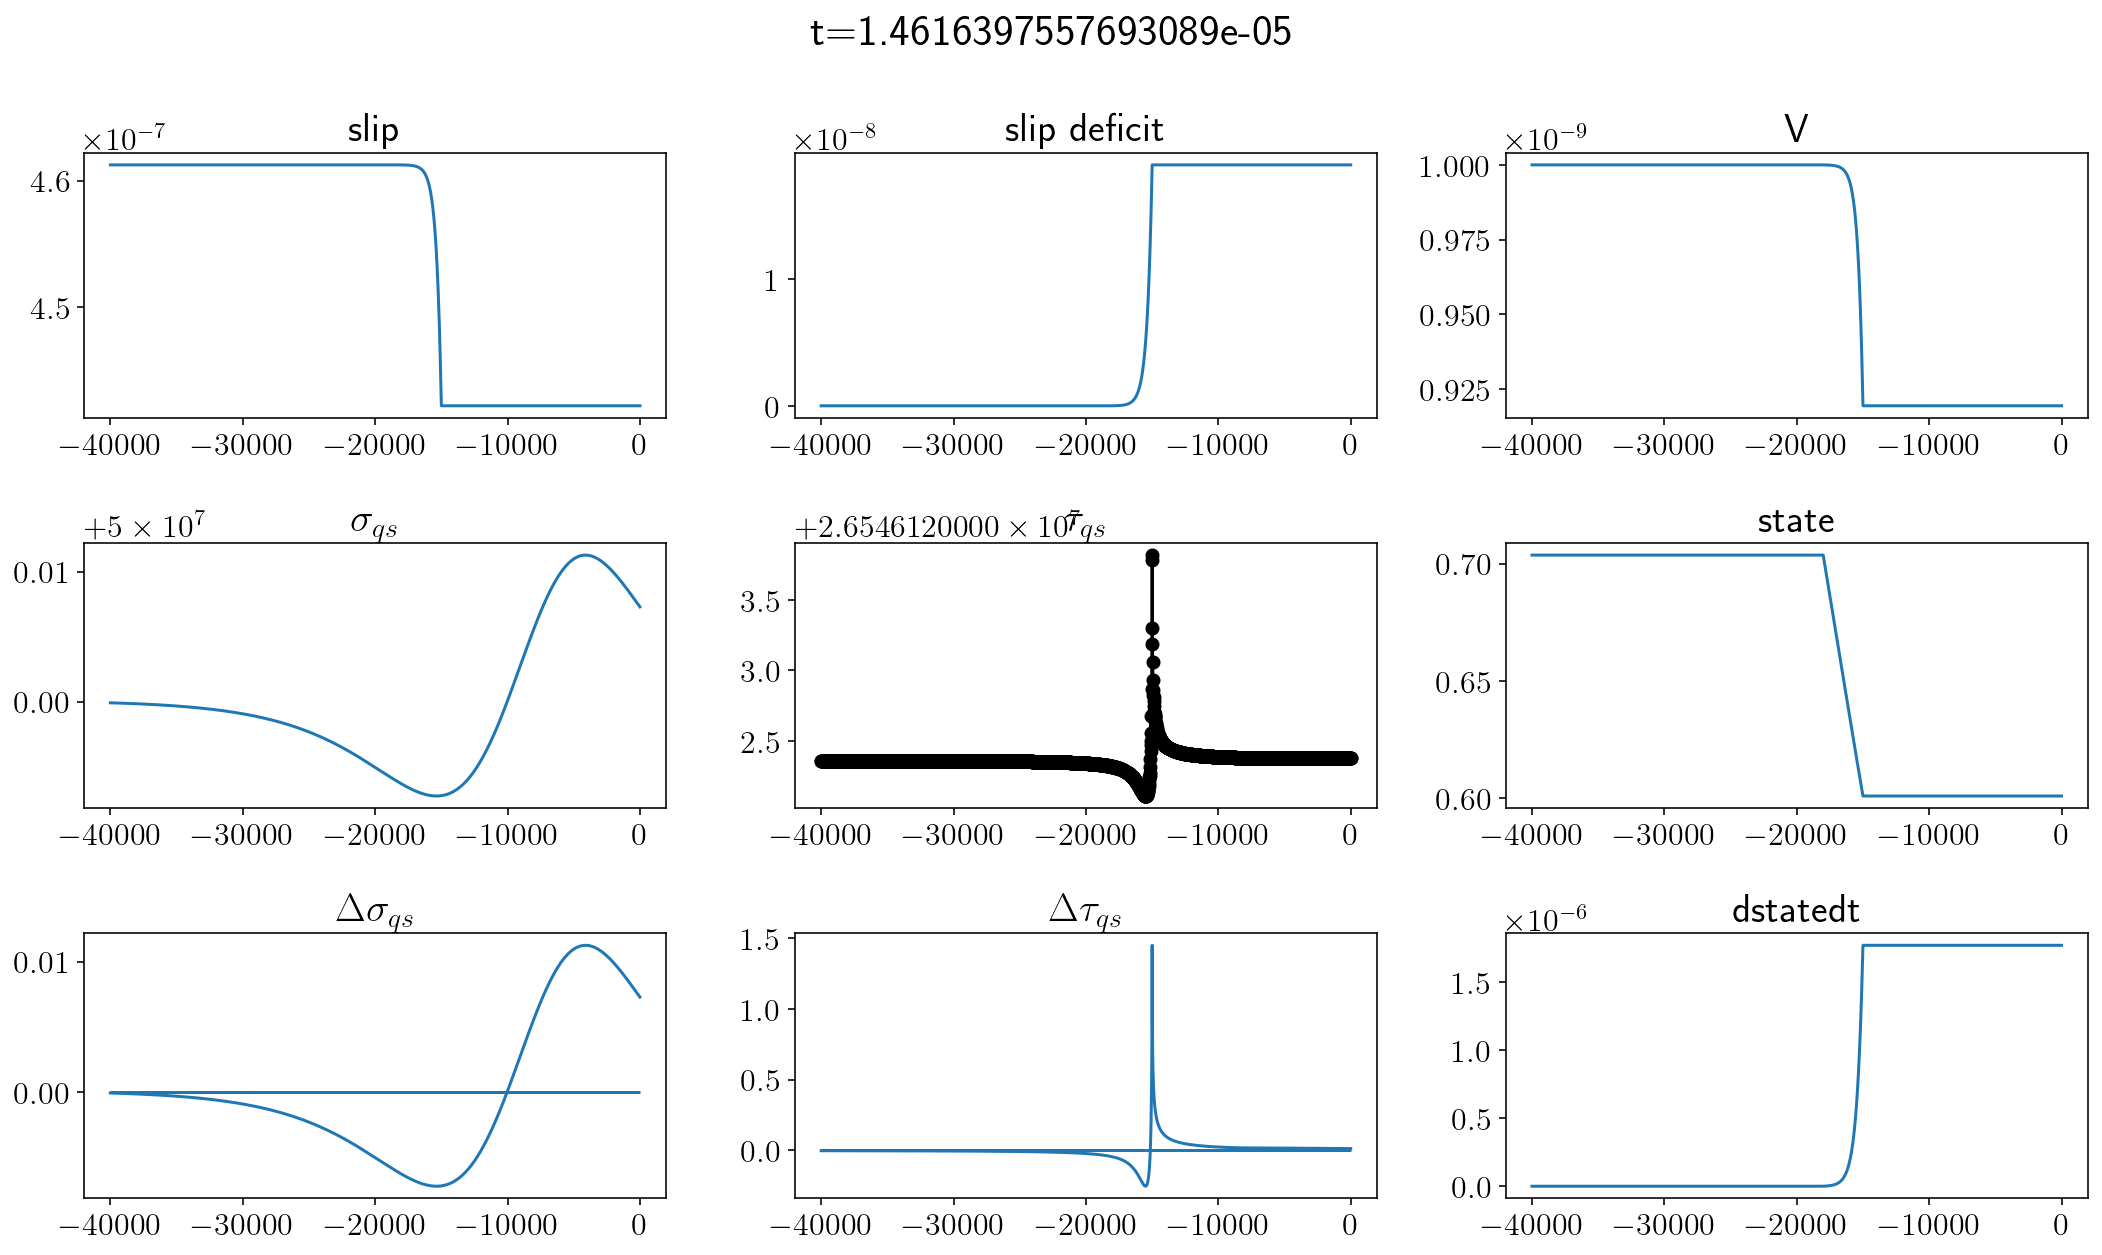

step=100, time=0.08836470367815463 yrs, step=0.004430518369182988


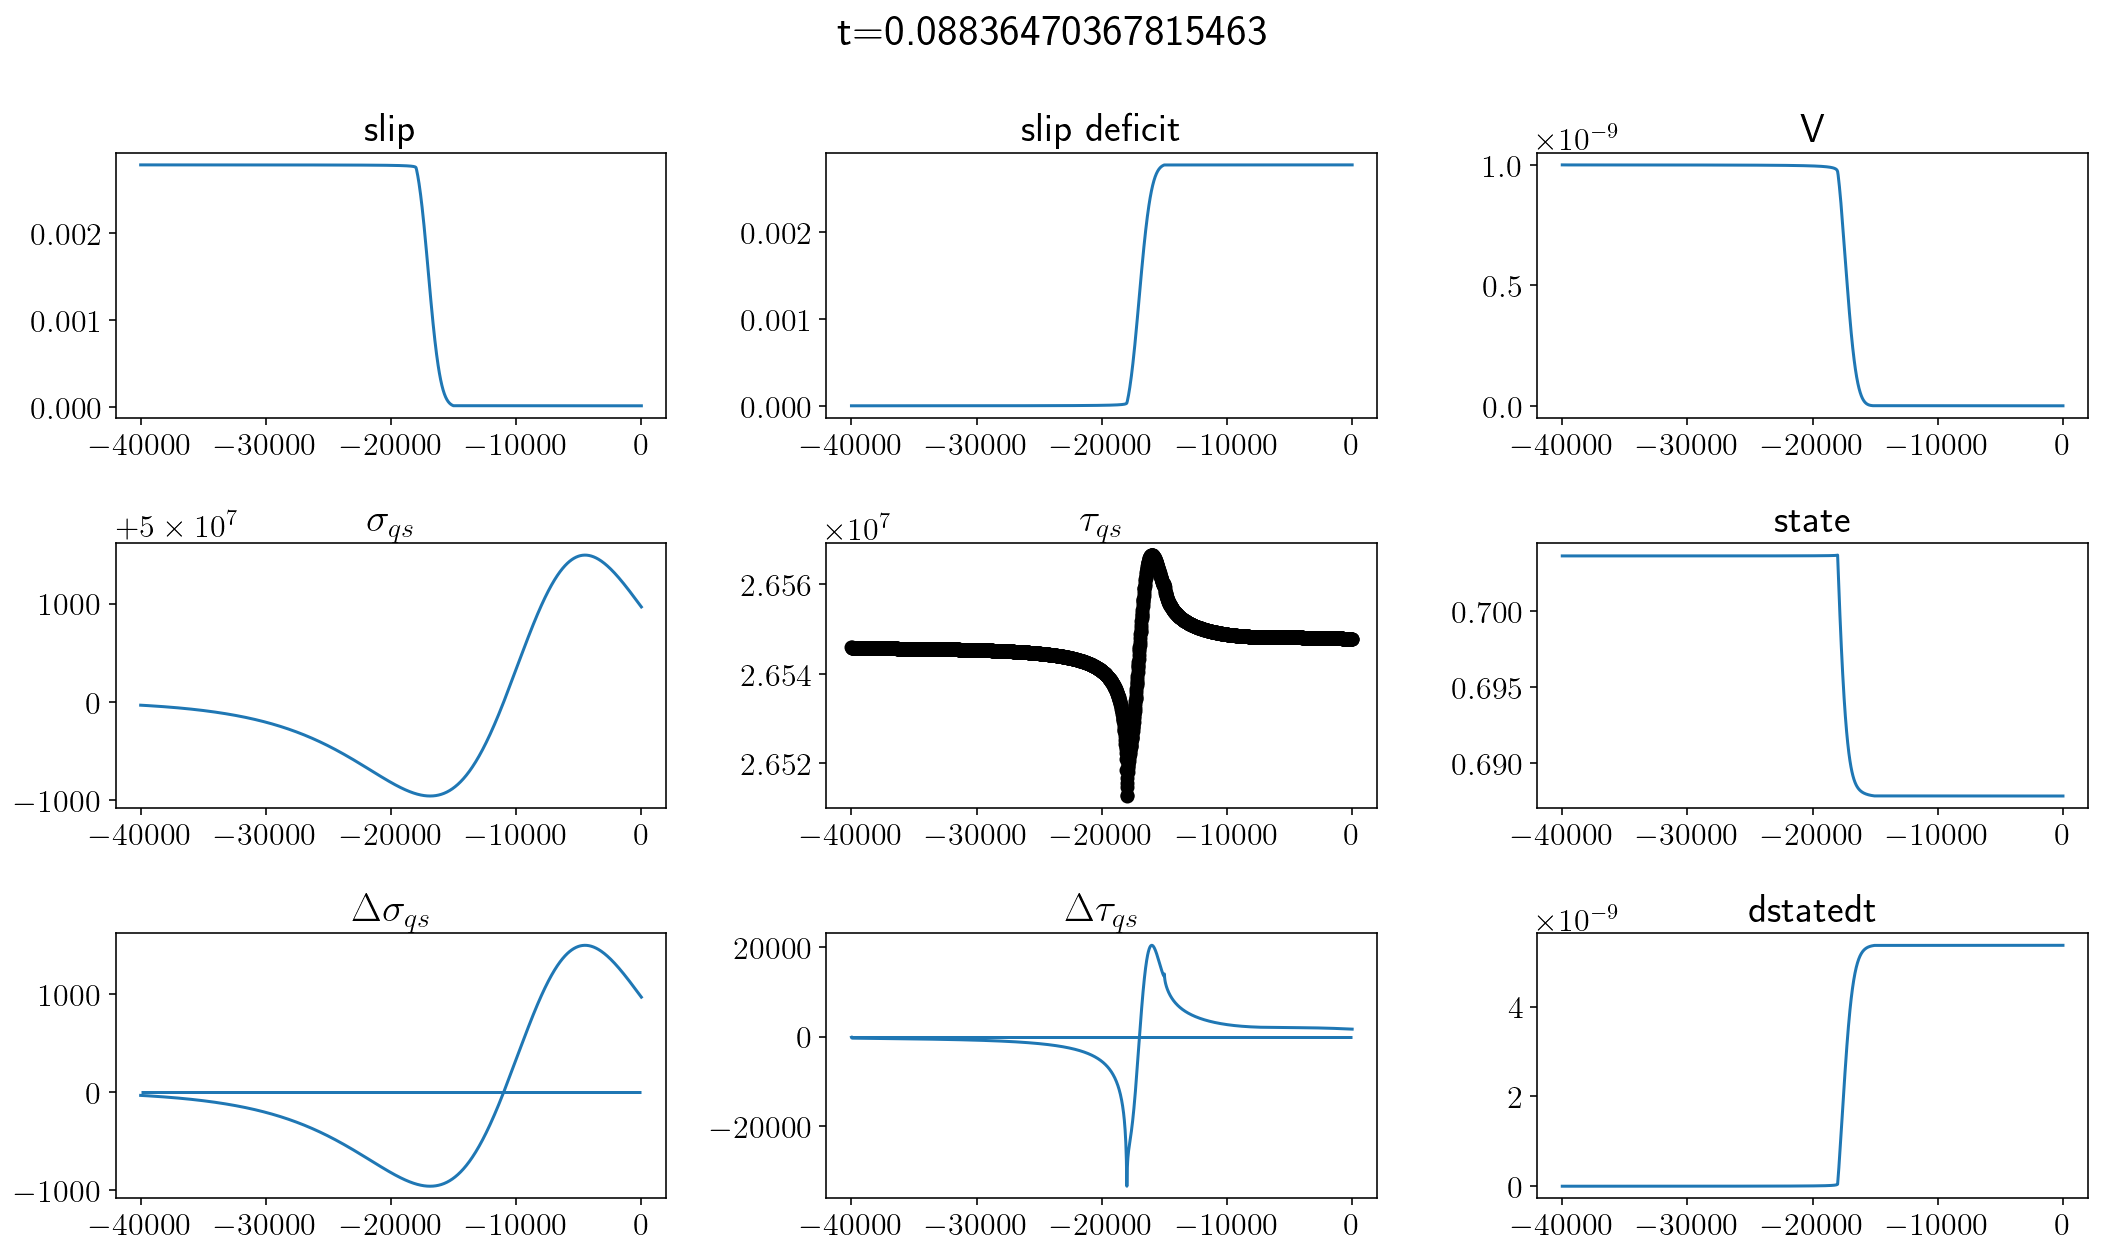

step=200, time=1.9941549447604774 yrs, step=0.027488267005675287


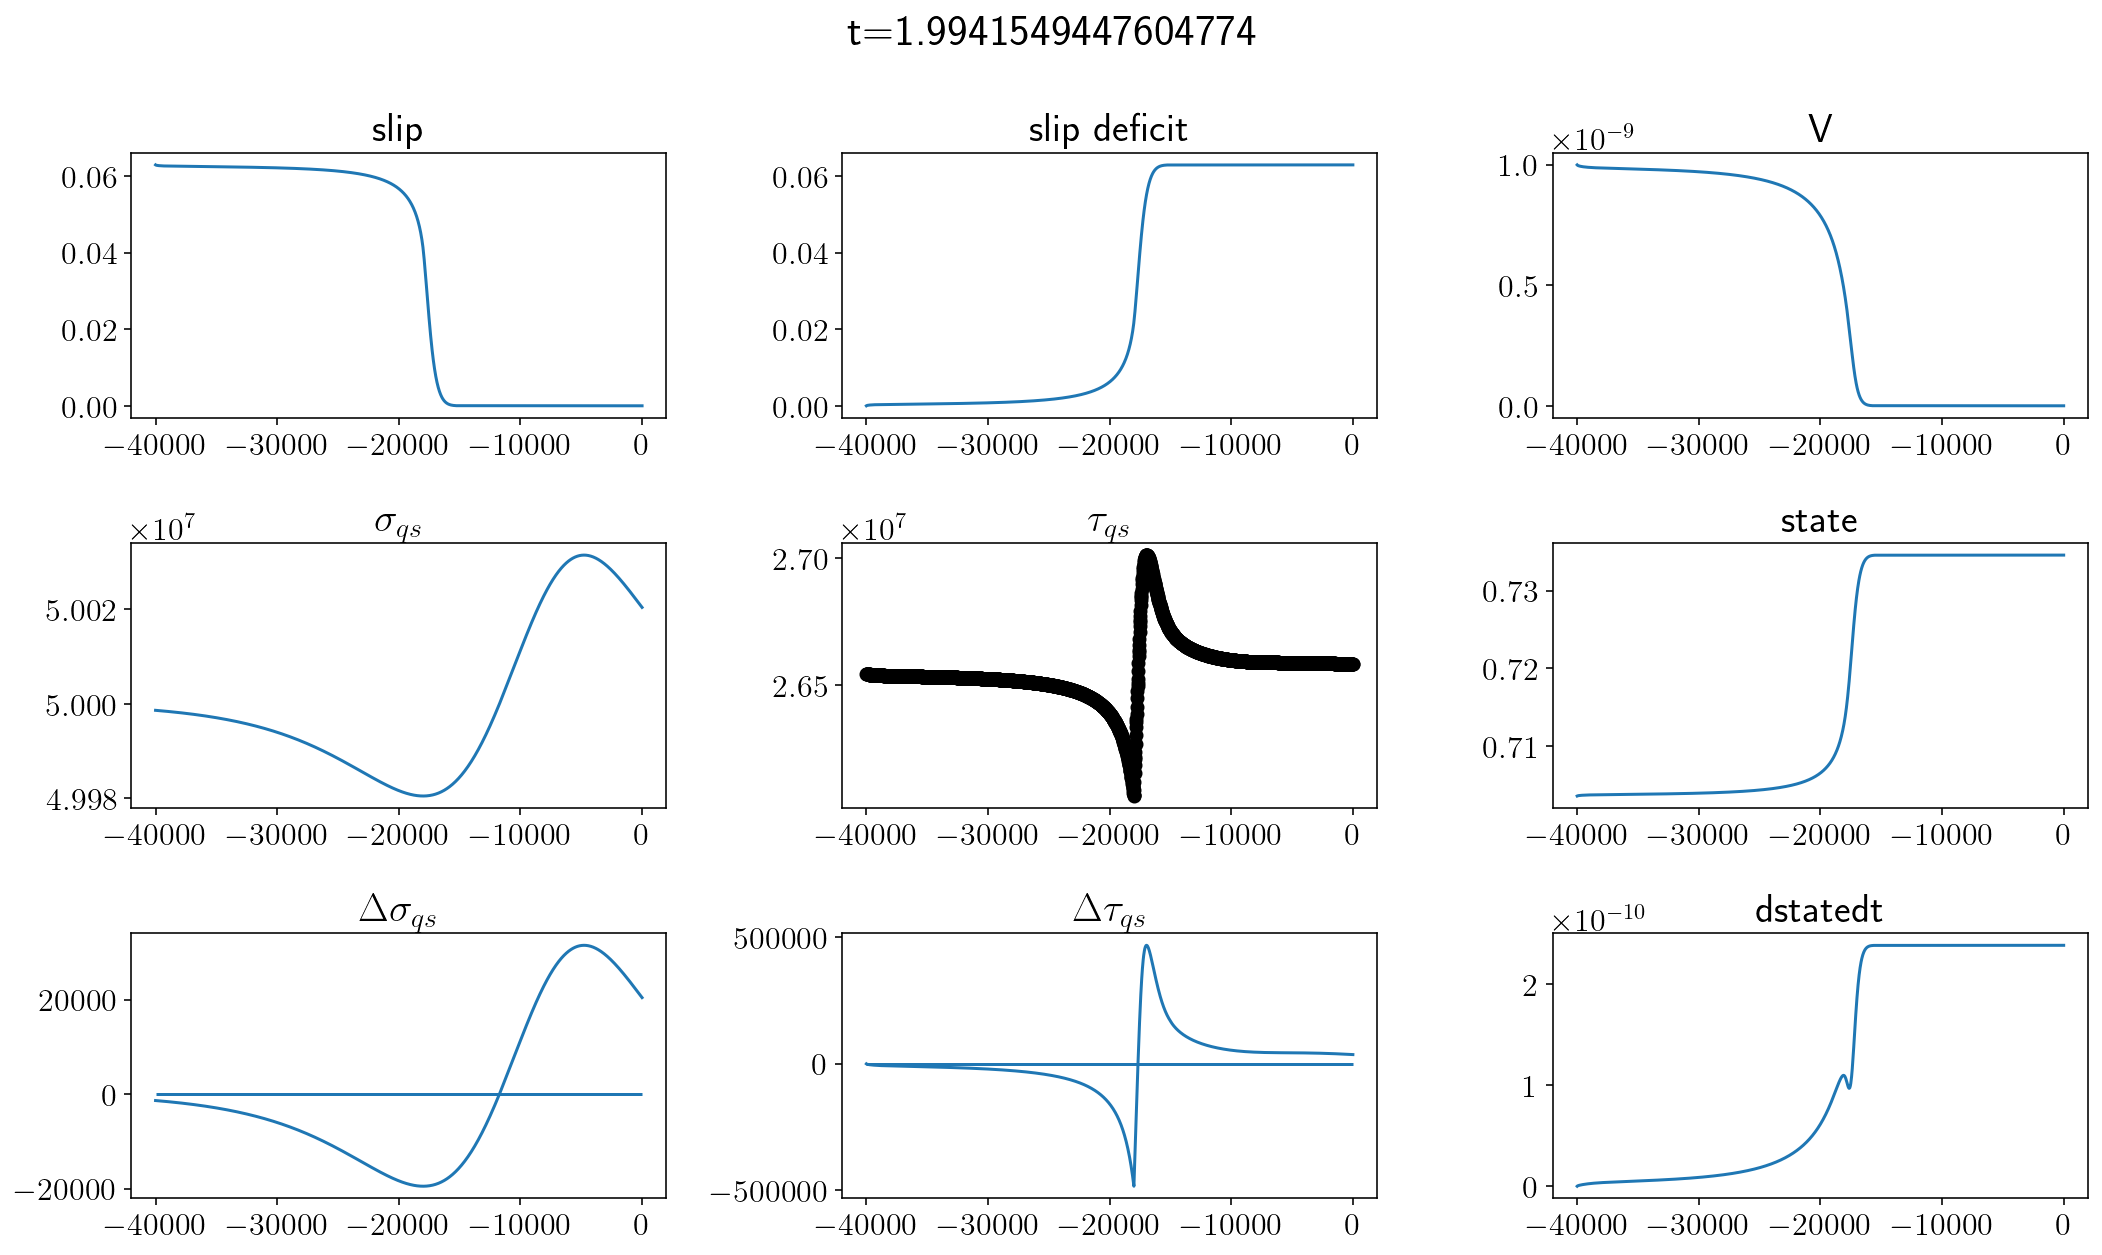

step=300, time=4.6922680753994745 yrs, step=0.024381998365173737


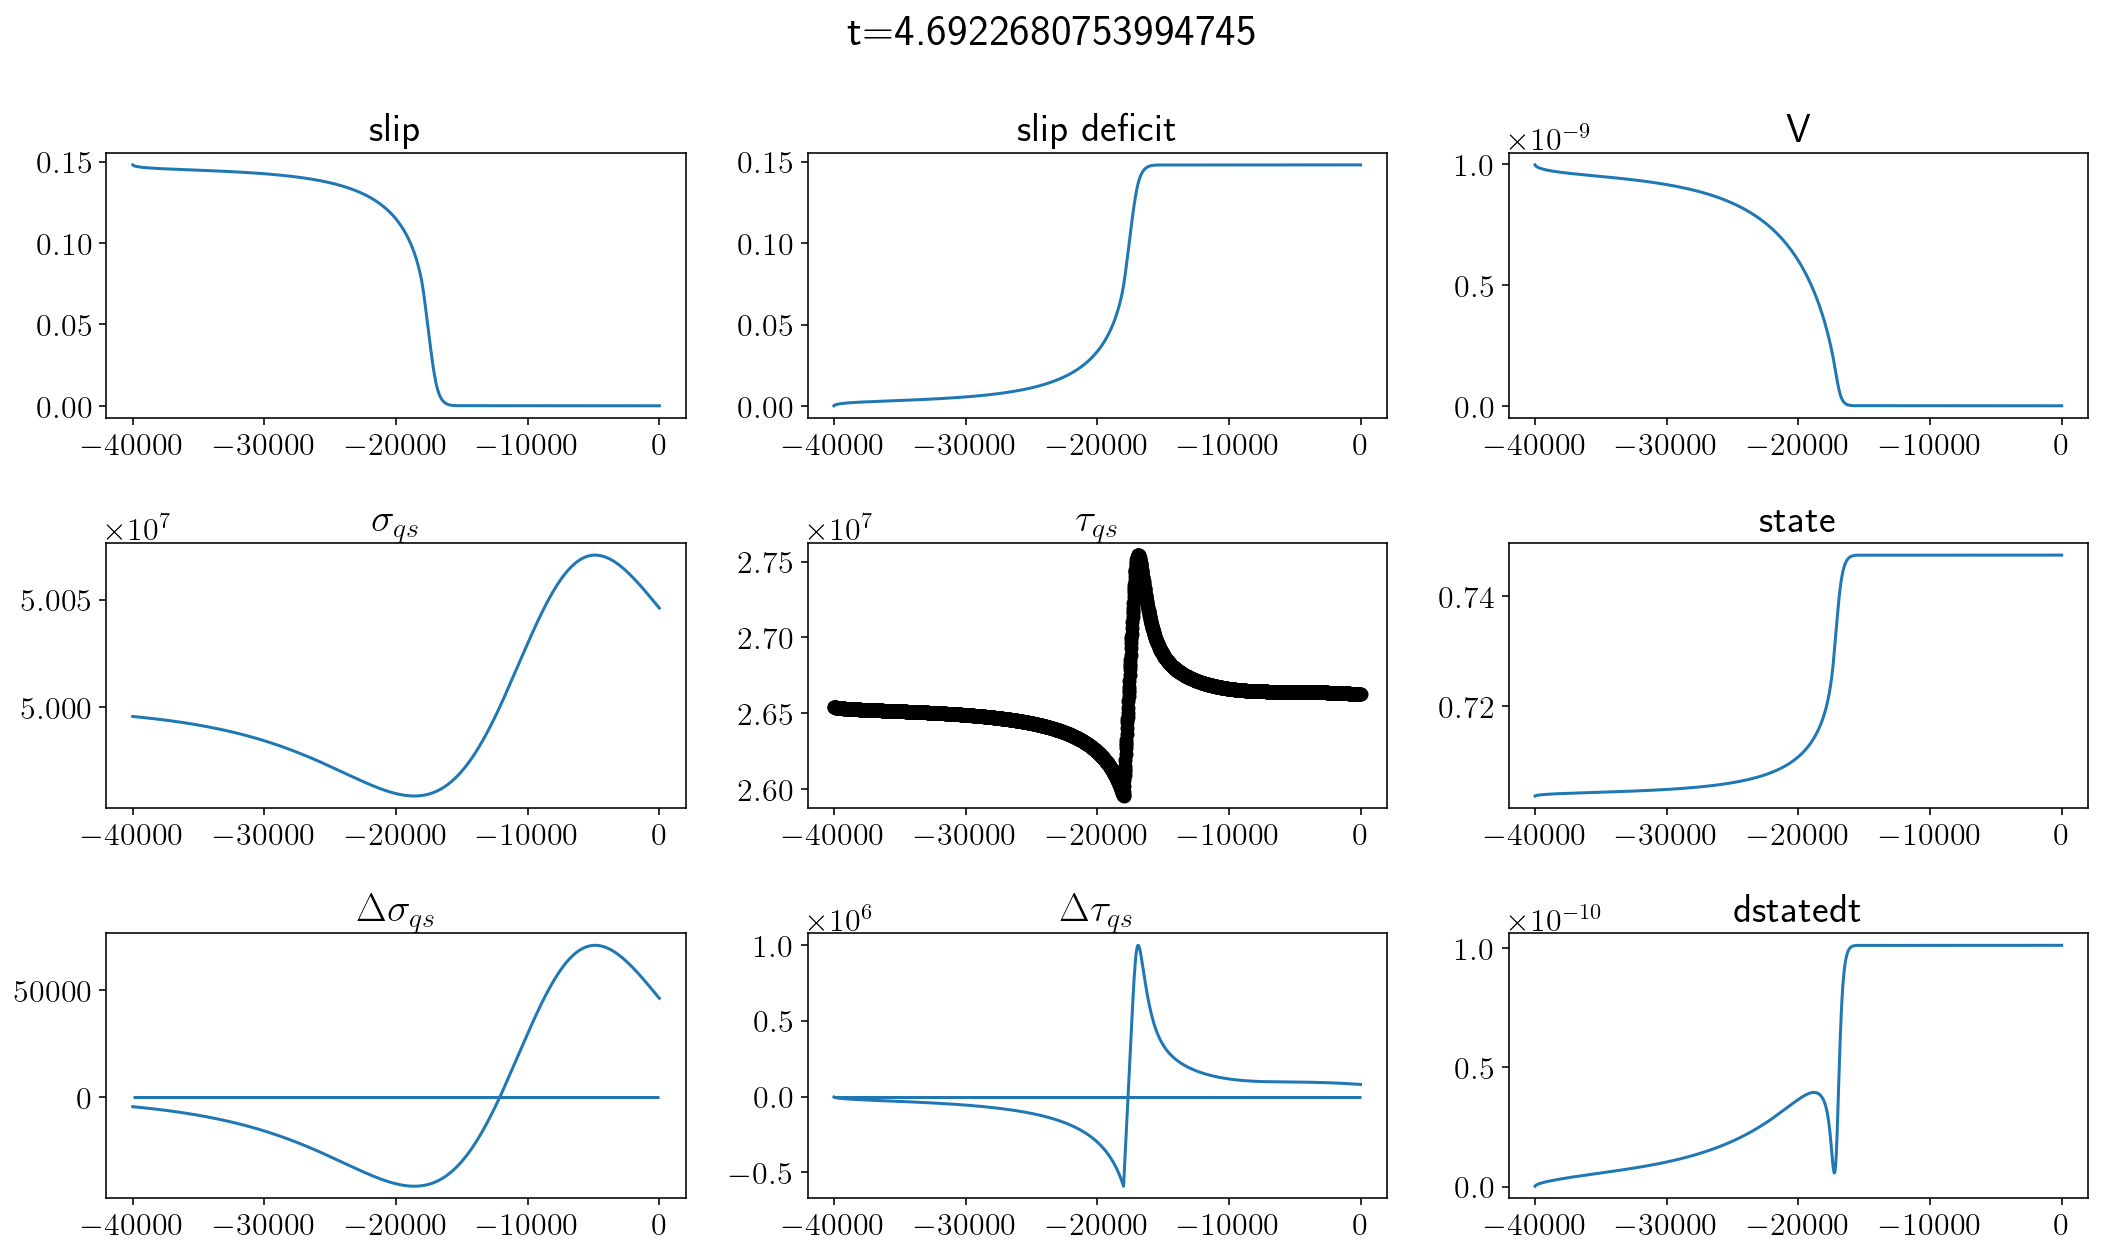

step=400, time=7.404236906124975 yrs, step=0.030052908141866223


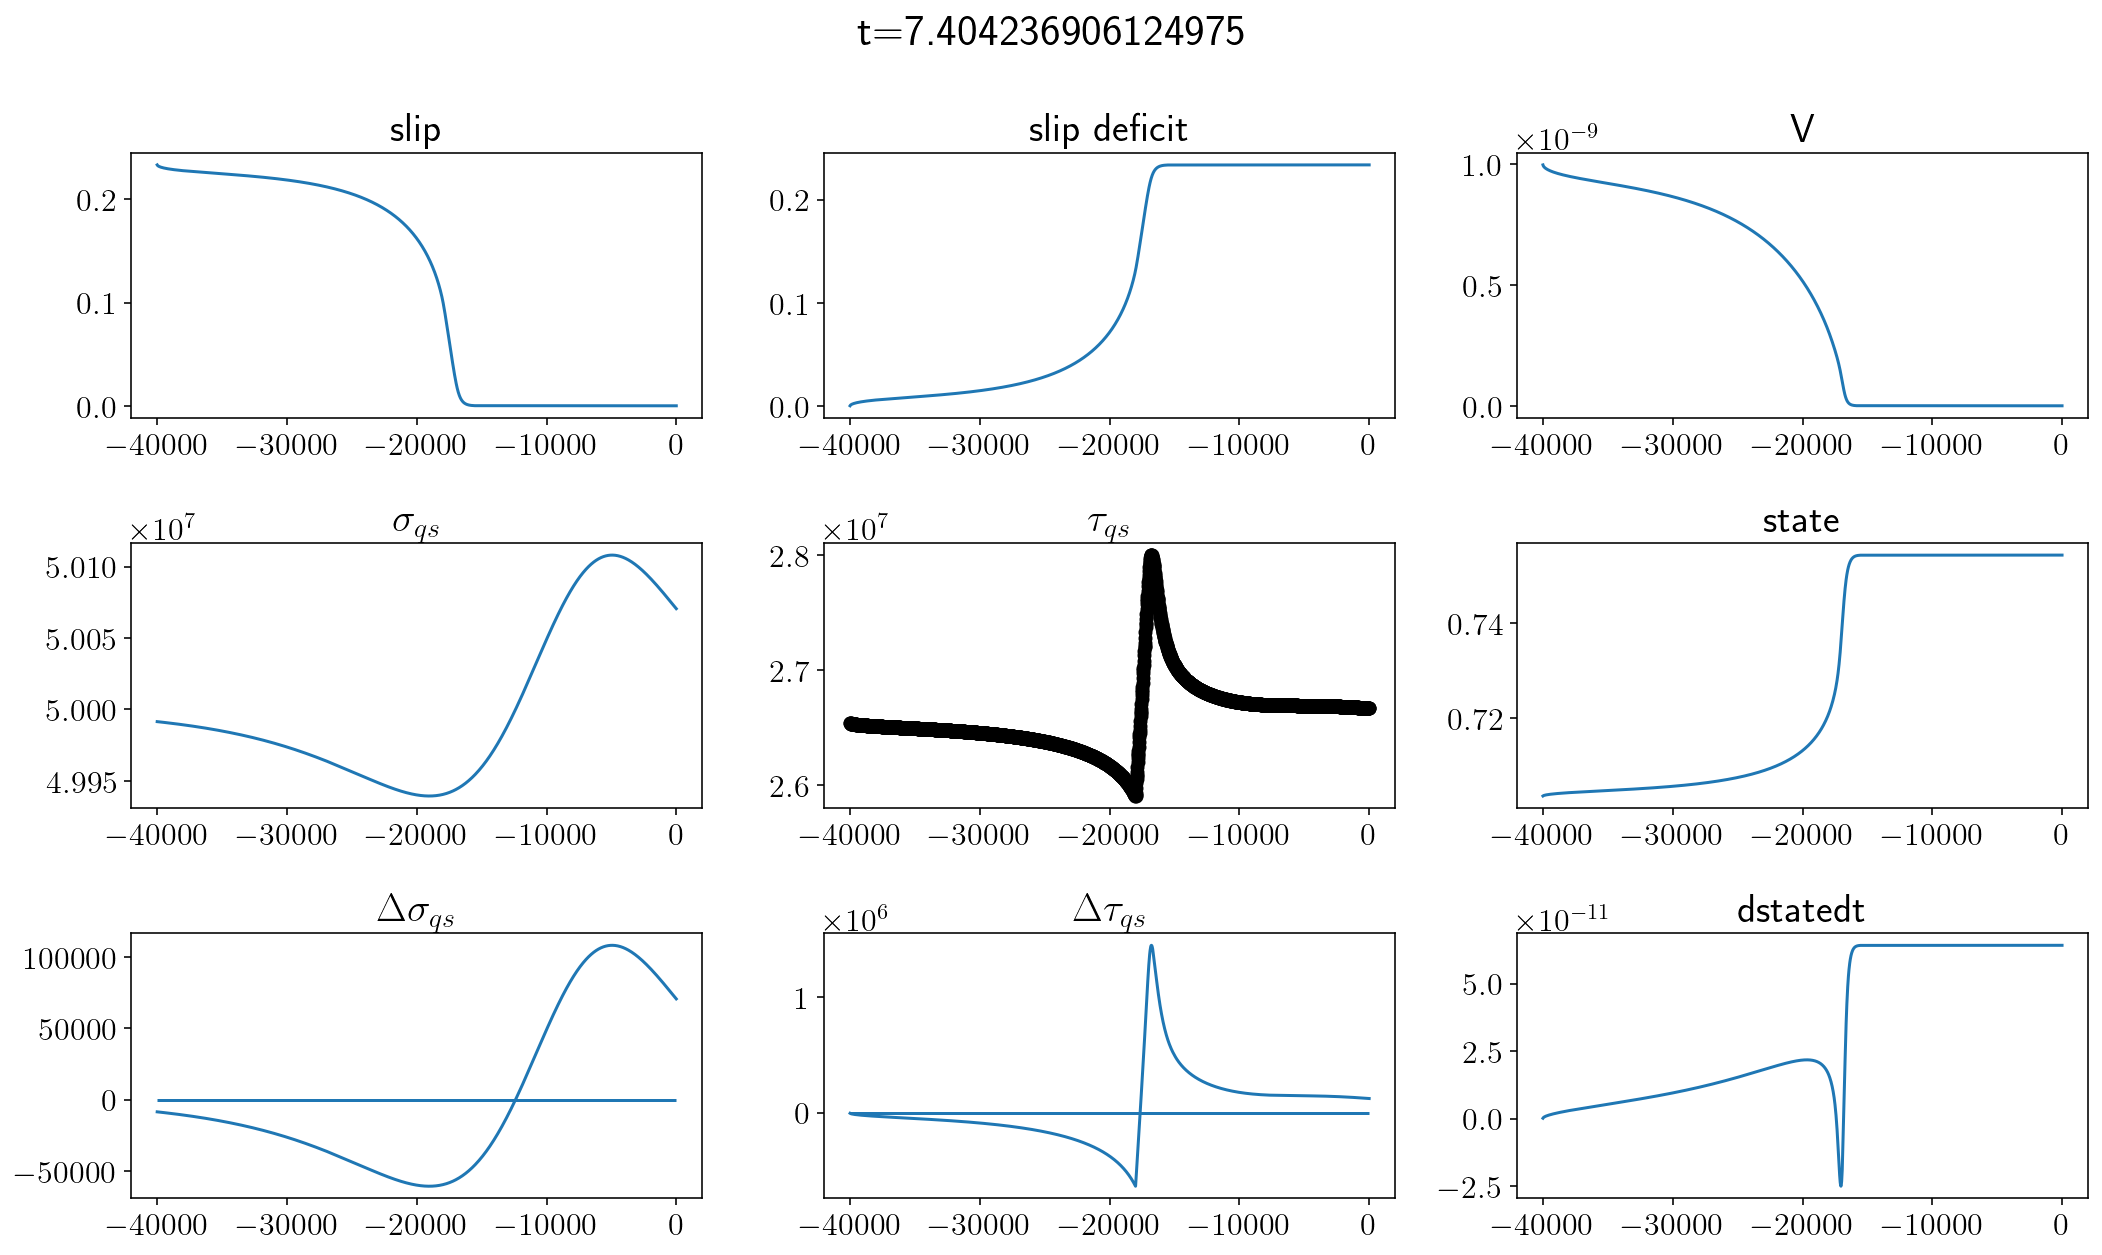

step=500, time=10.119536301271355 yrs, step=0.02805786688879596


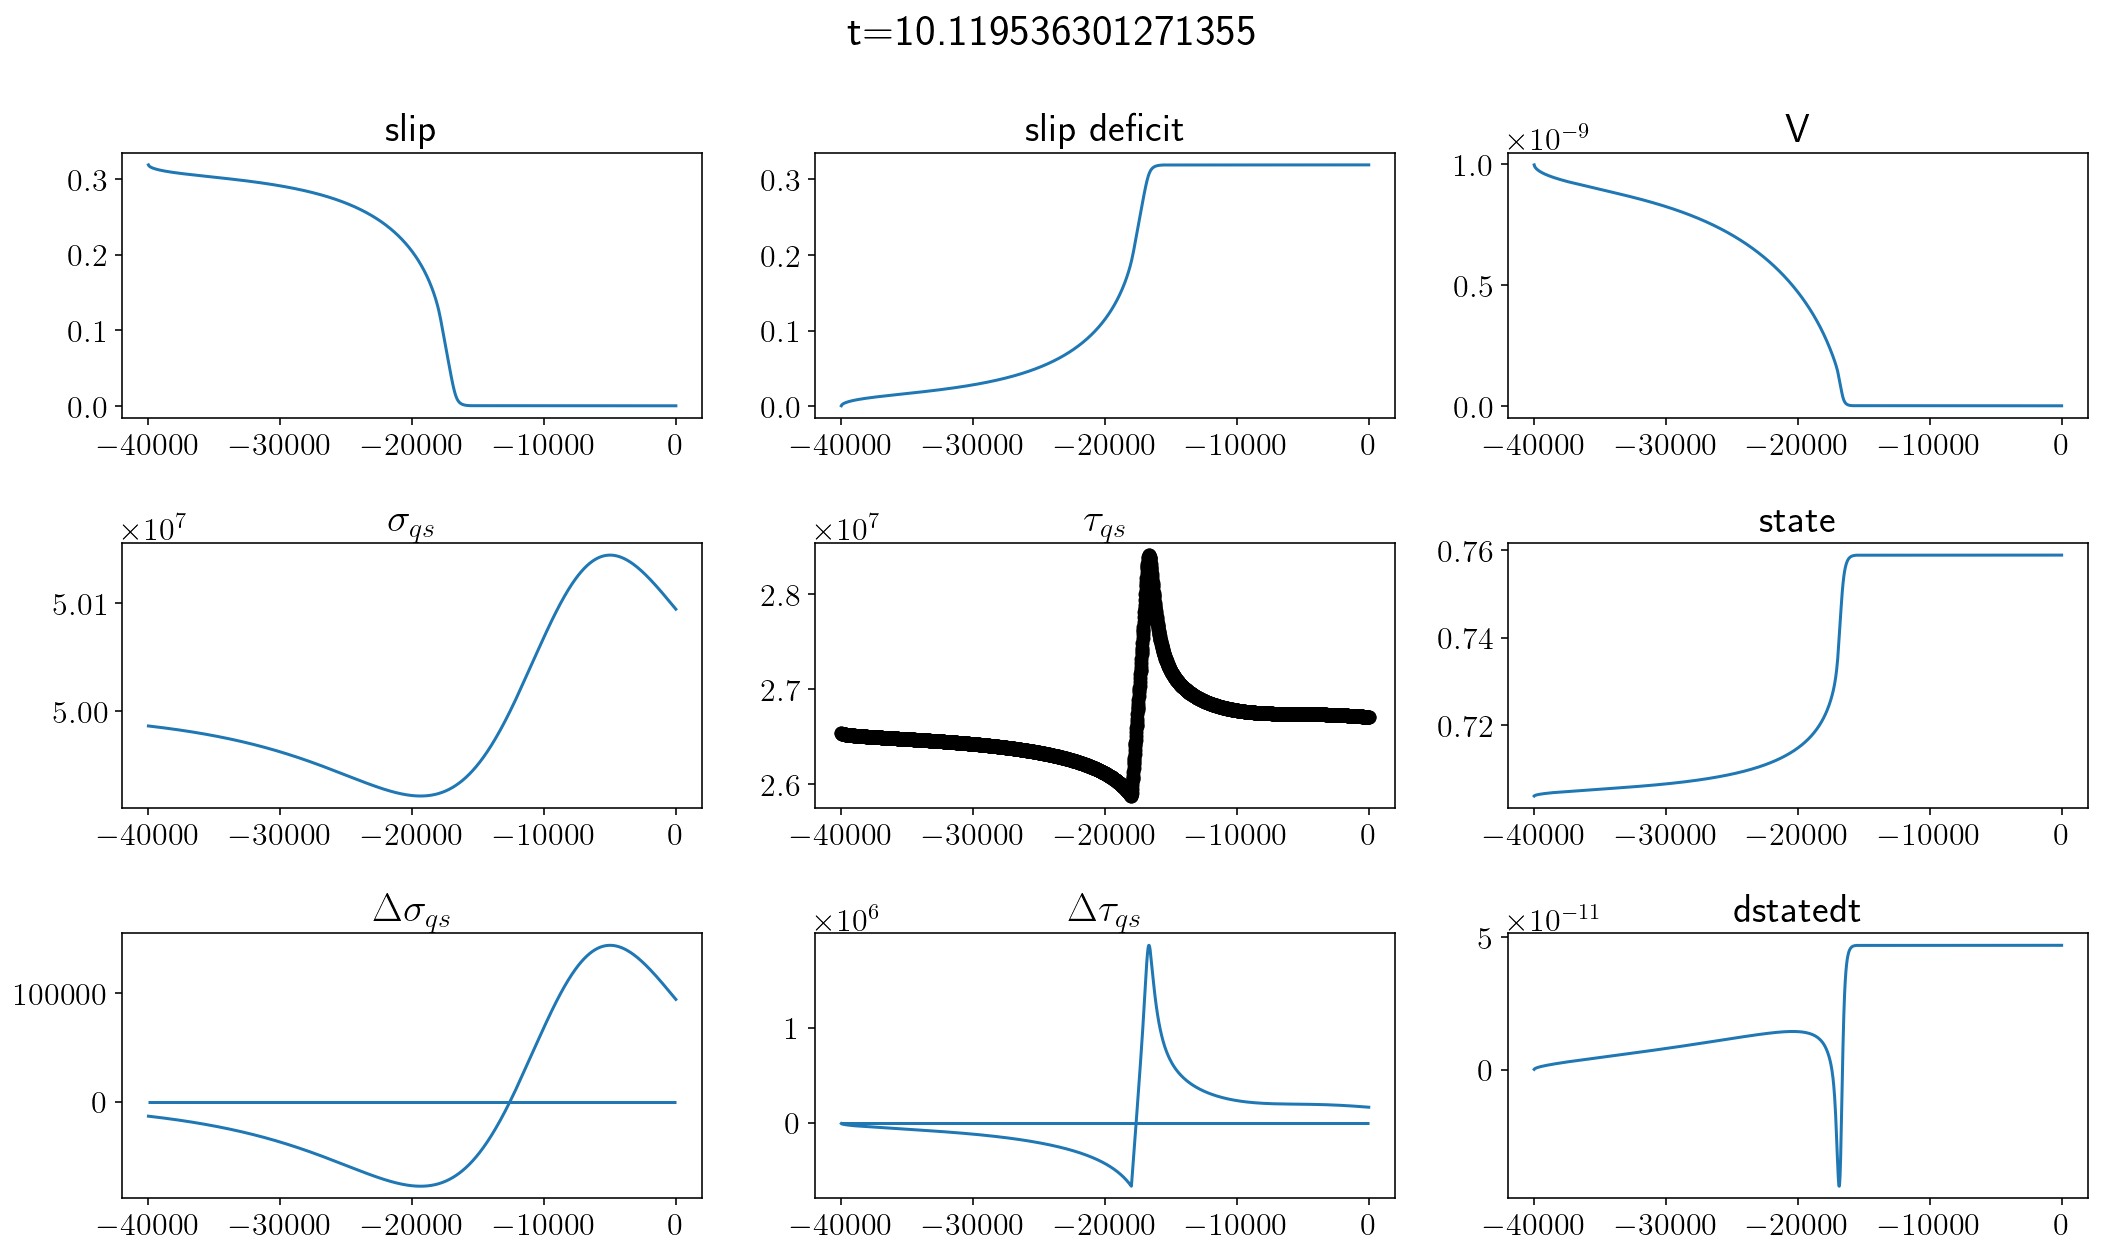

step=600, time=12.846919354901376 yrs, step=0.025615782385018094


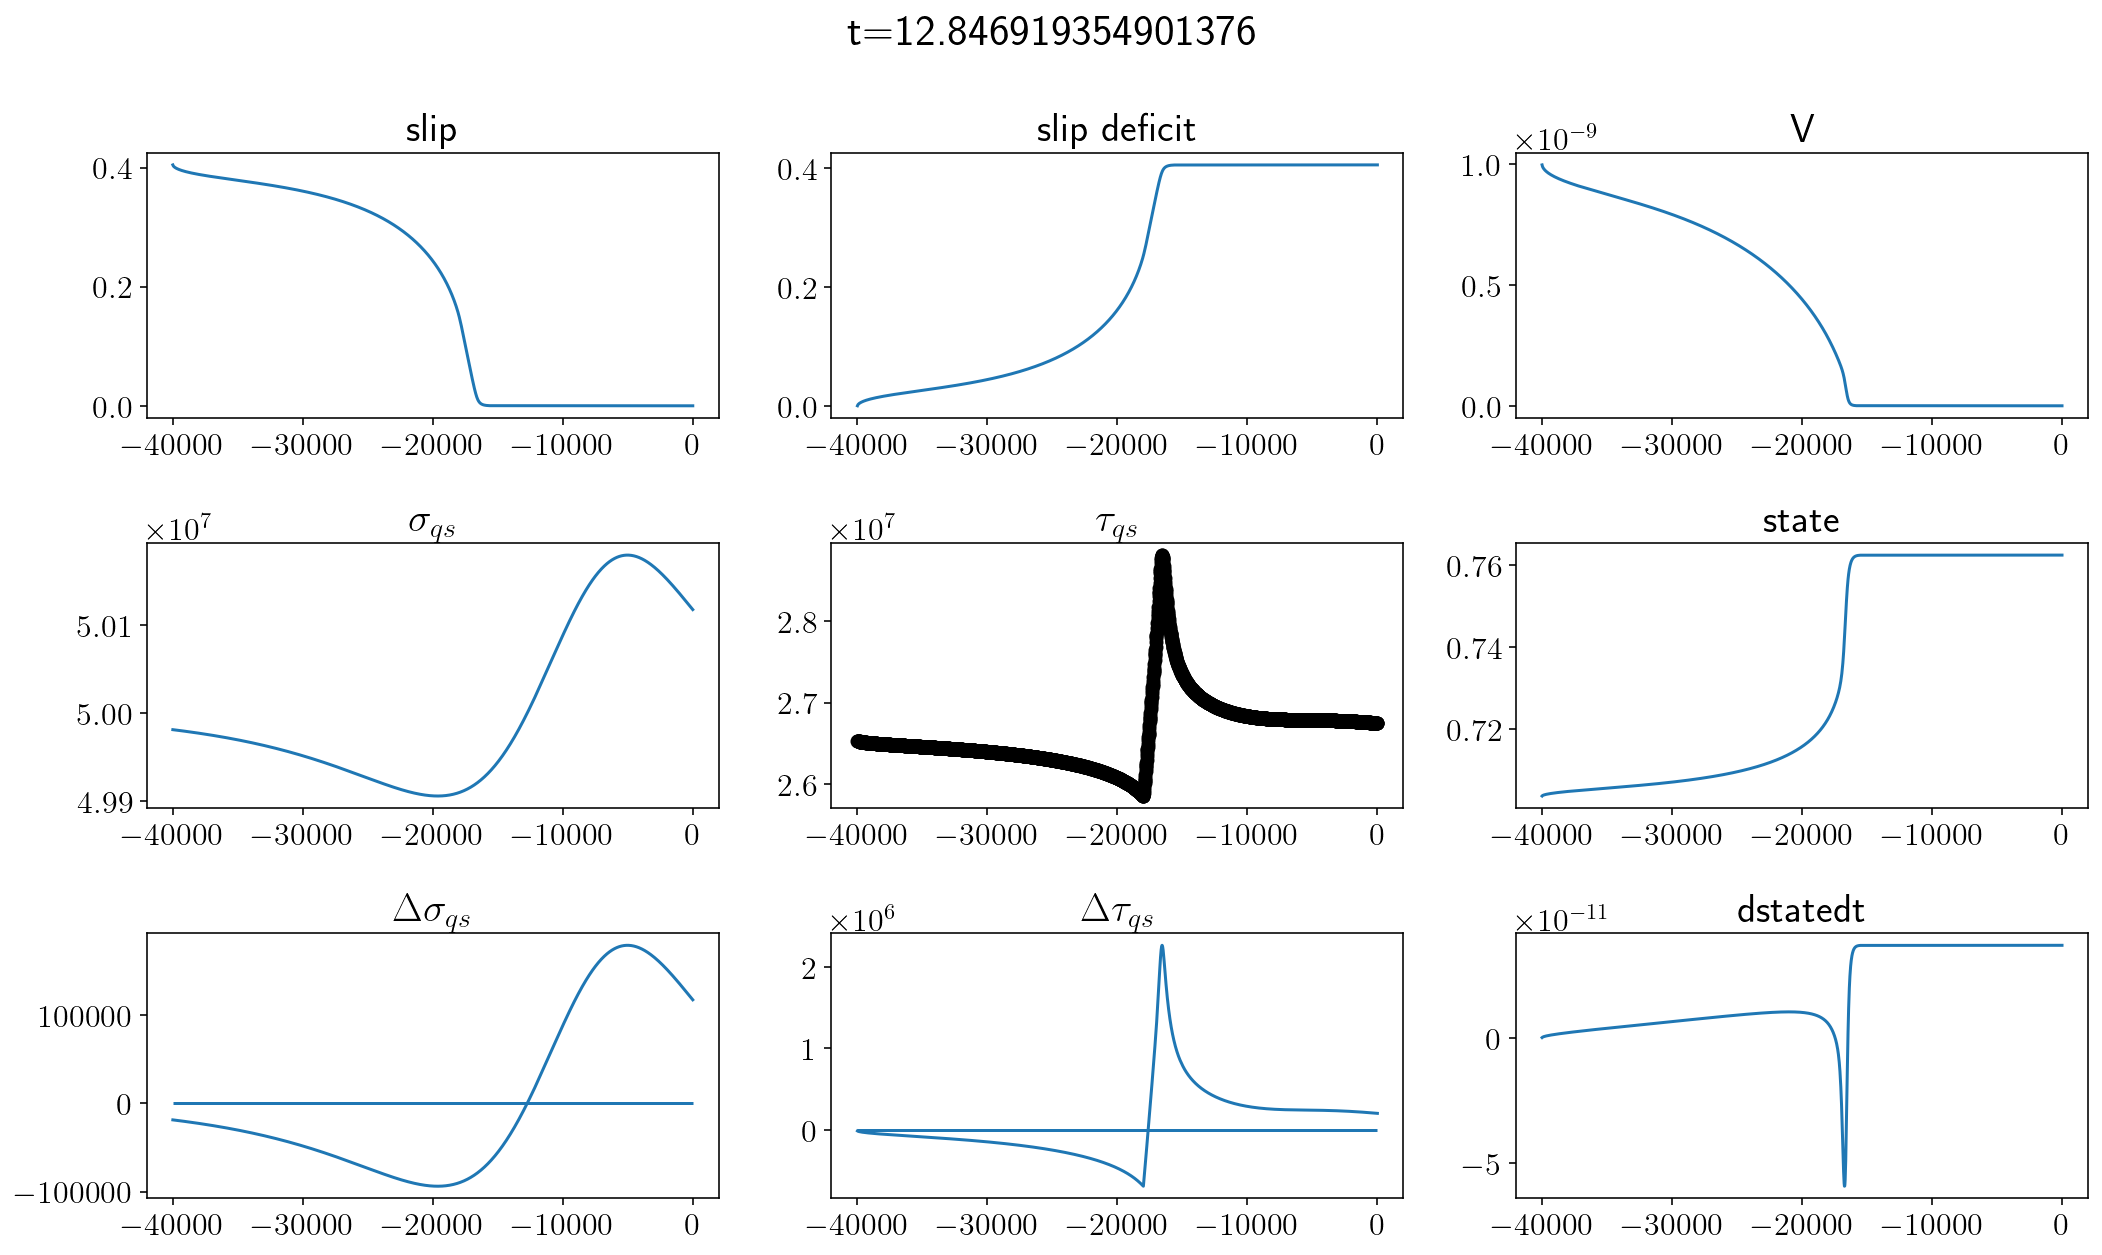

step=700, time=15.577022129959595 yrs, step=0.029650131535300293


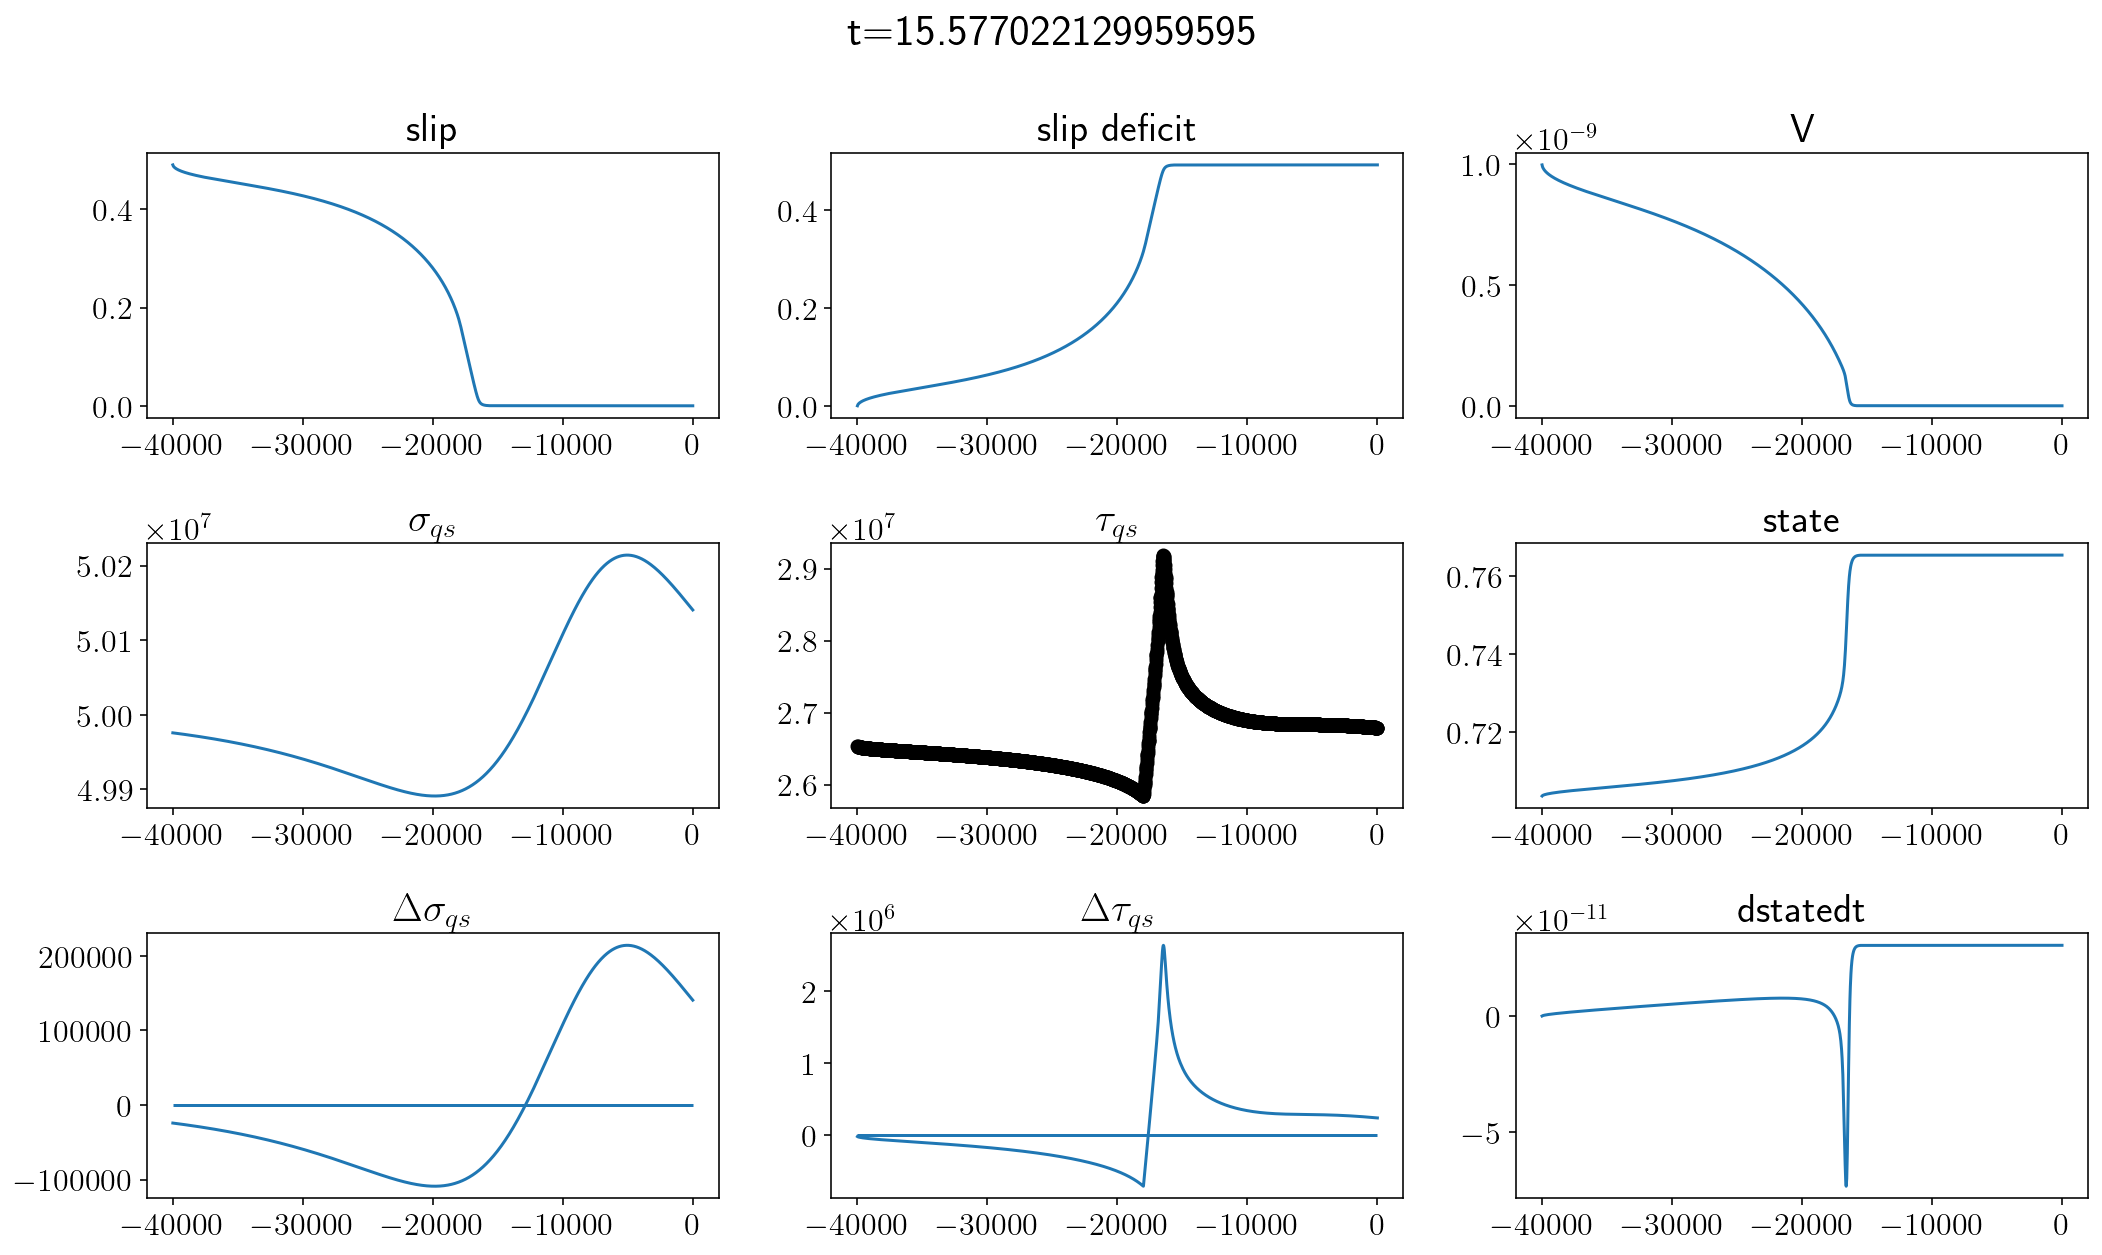

step=800, time=18.311458010048447 yrs, step=0.02458559568148994


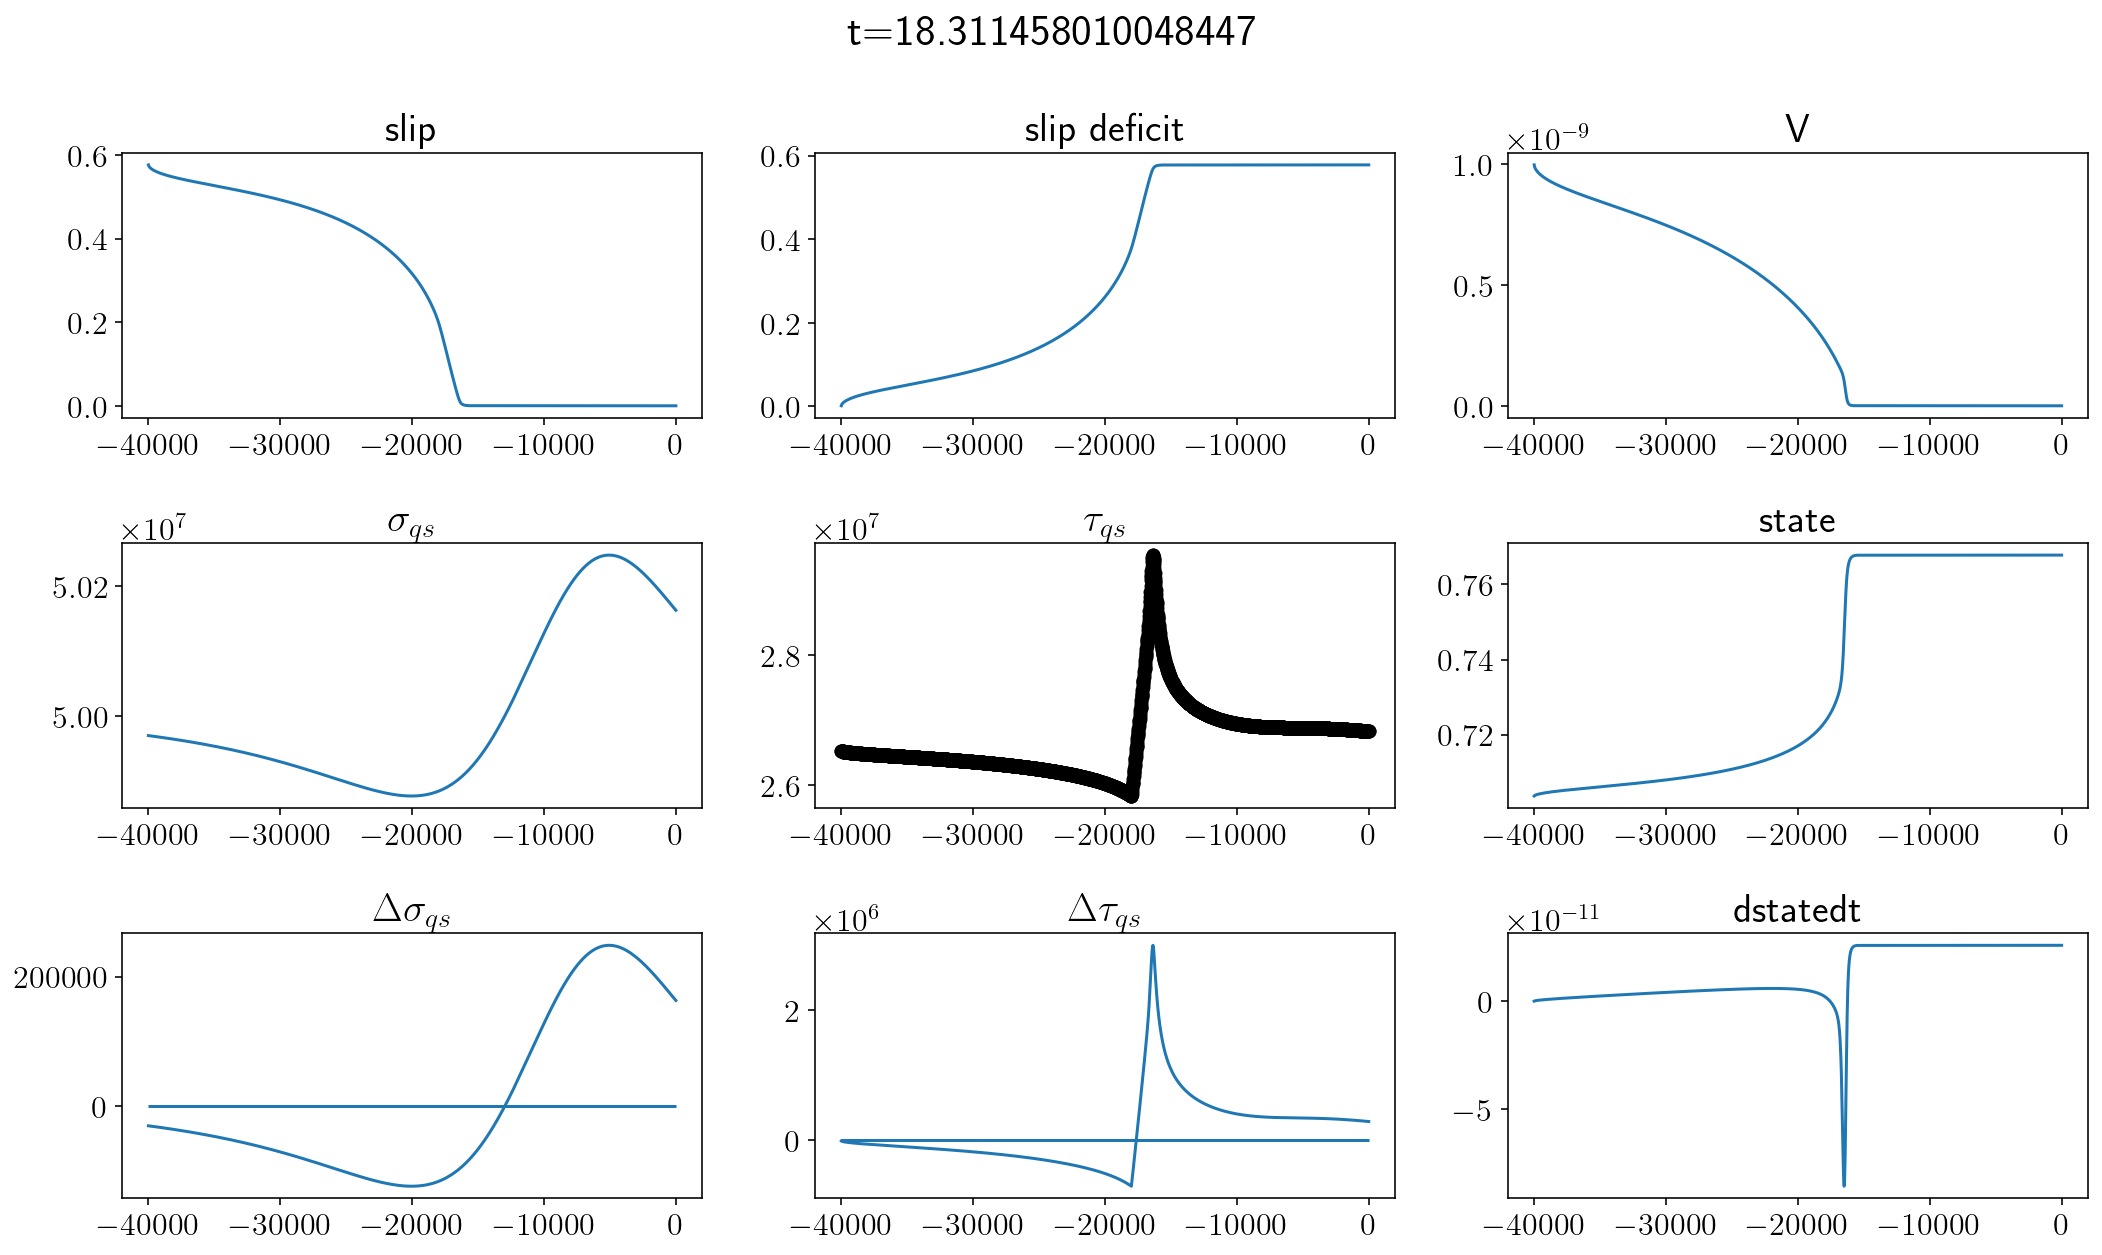

step=900, time=21.052723198237583 yrs, step=0.02694281908237806


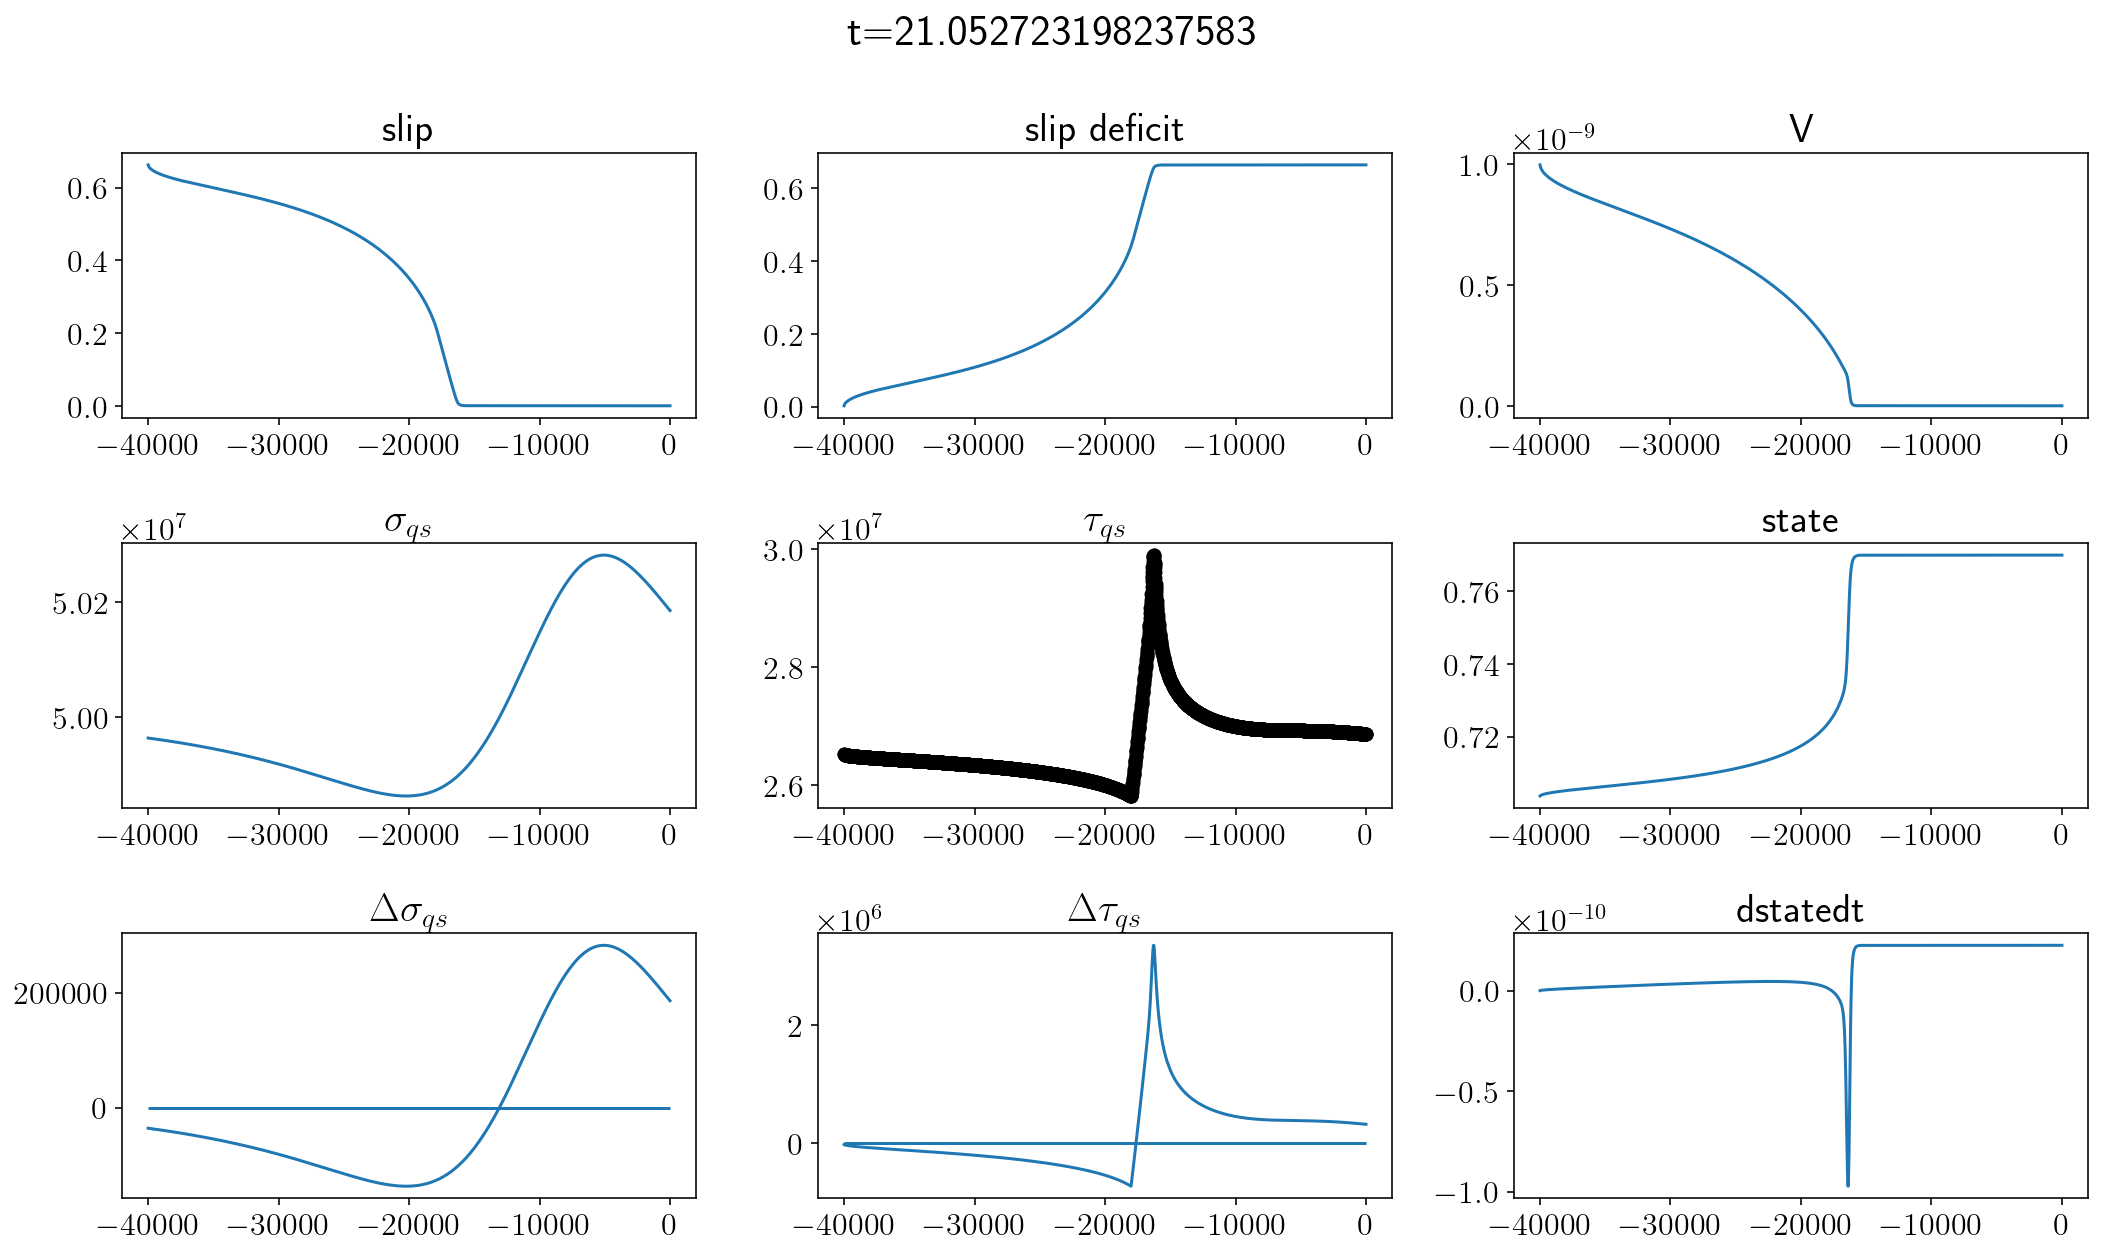

step=1000, time=23.79049777319519 yrs, step=0.02866065087092116
step=1000, time=23.79049777319519 yrs, step=0.02866065087092116


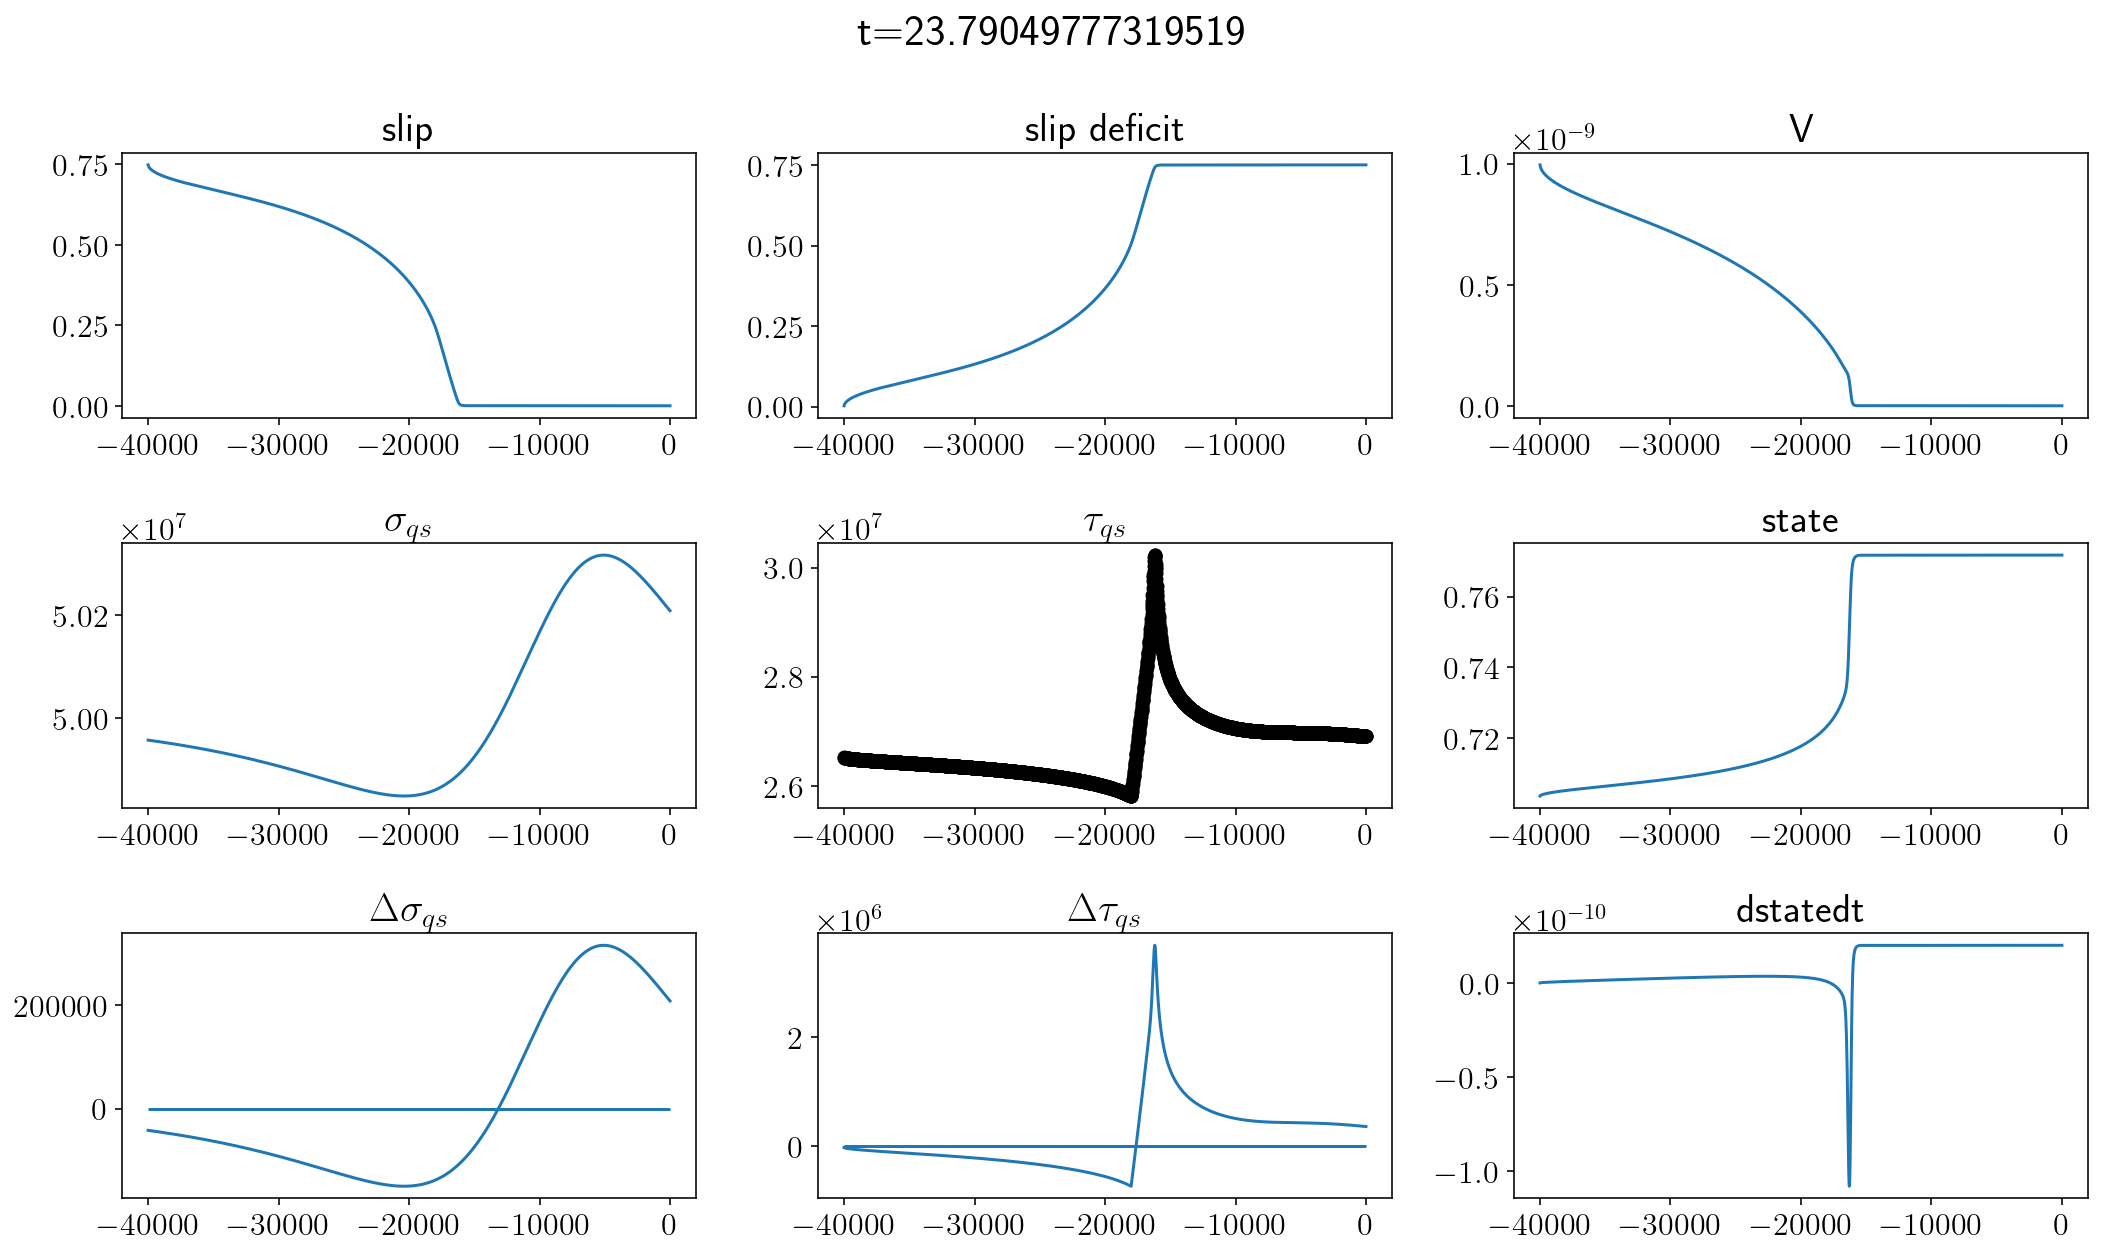

step=1100, time=26.532178215998066 yrs, step=0.02522506782884398


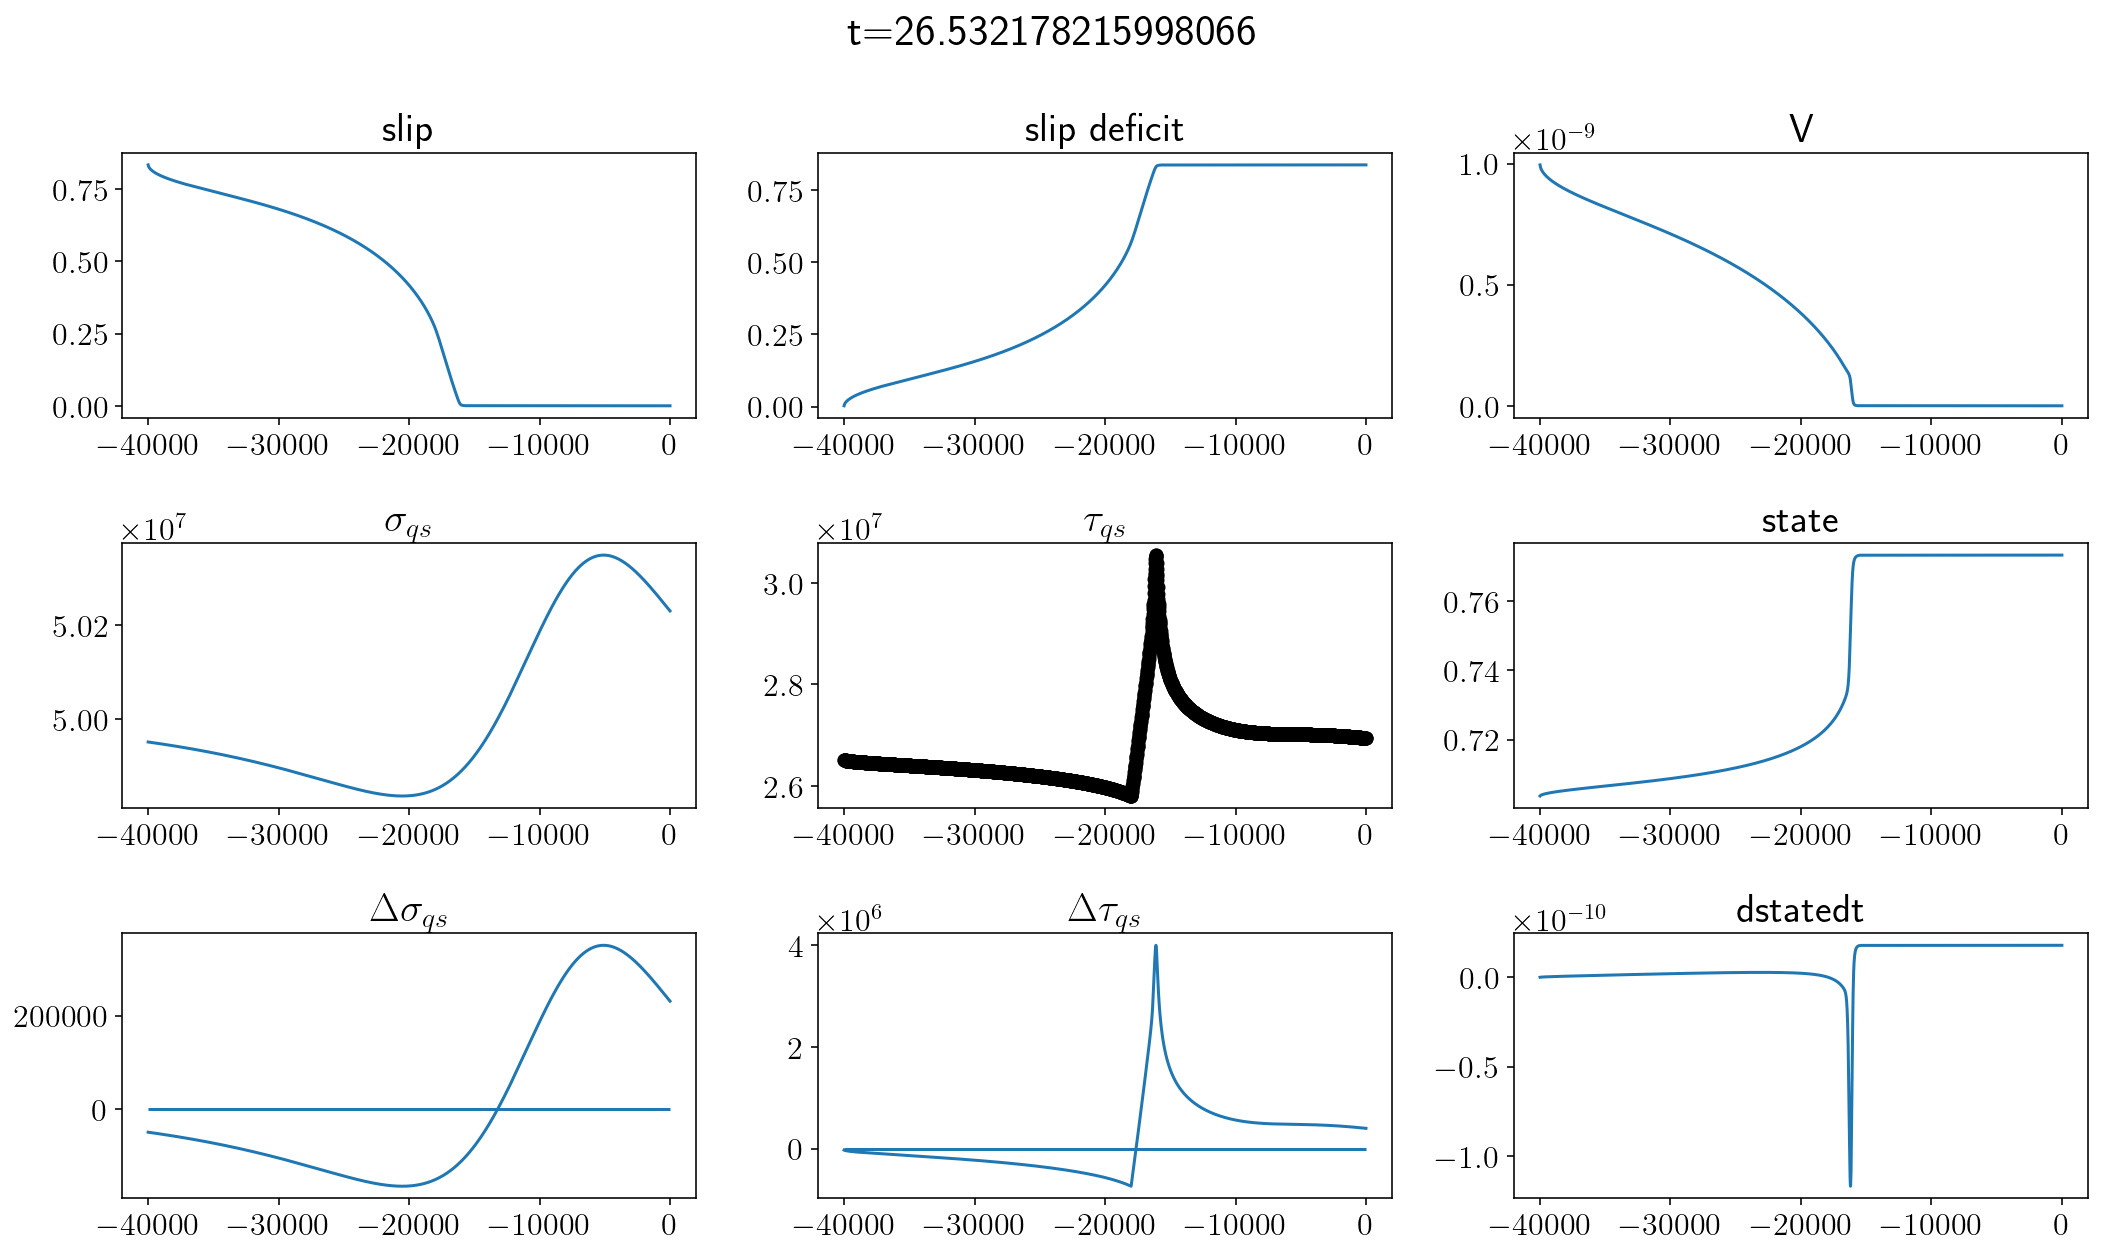

step=1200, time=29.27867815243222 yrs, step=0.025286323316872326


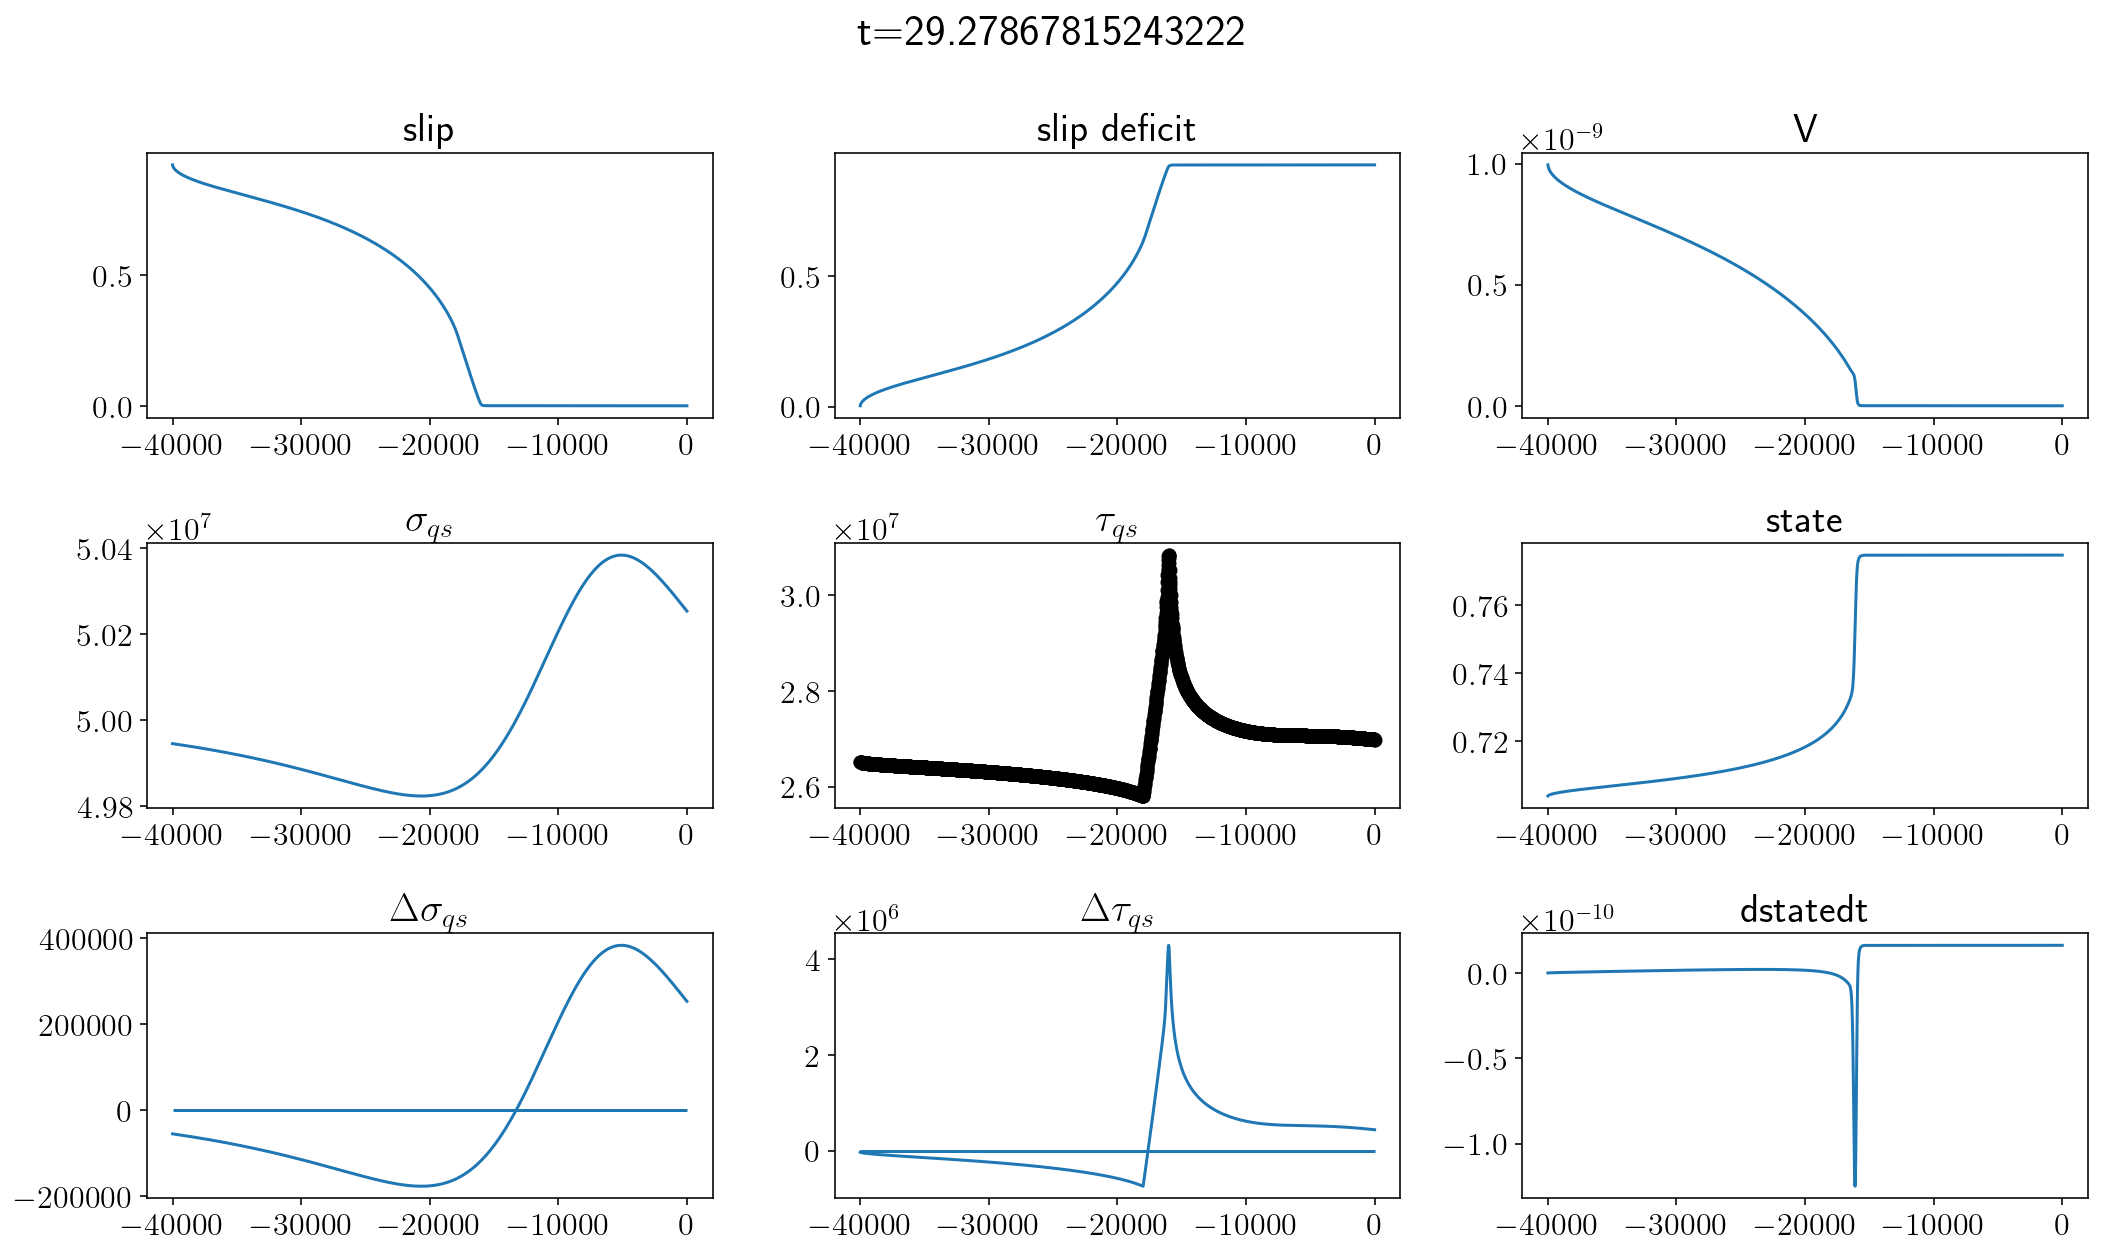

step=1300, time=32.02595749187548 yrs, step=0.03072708183173726


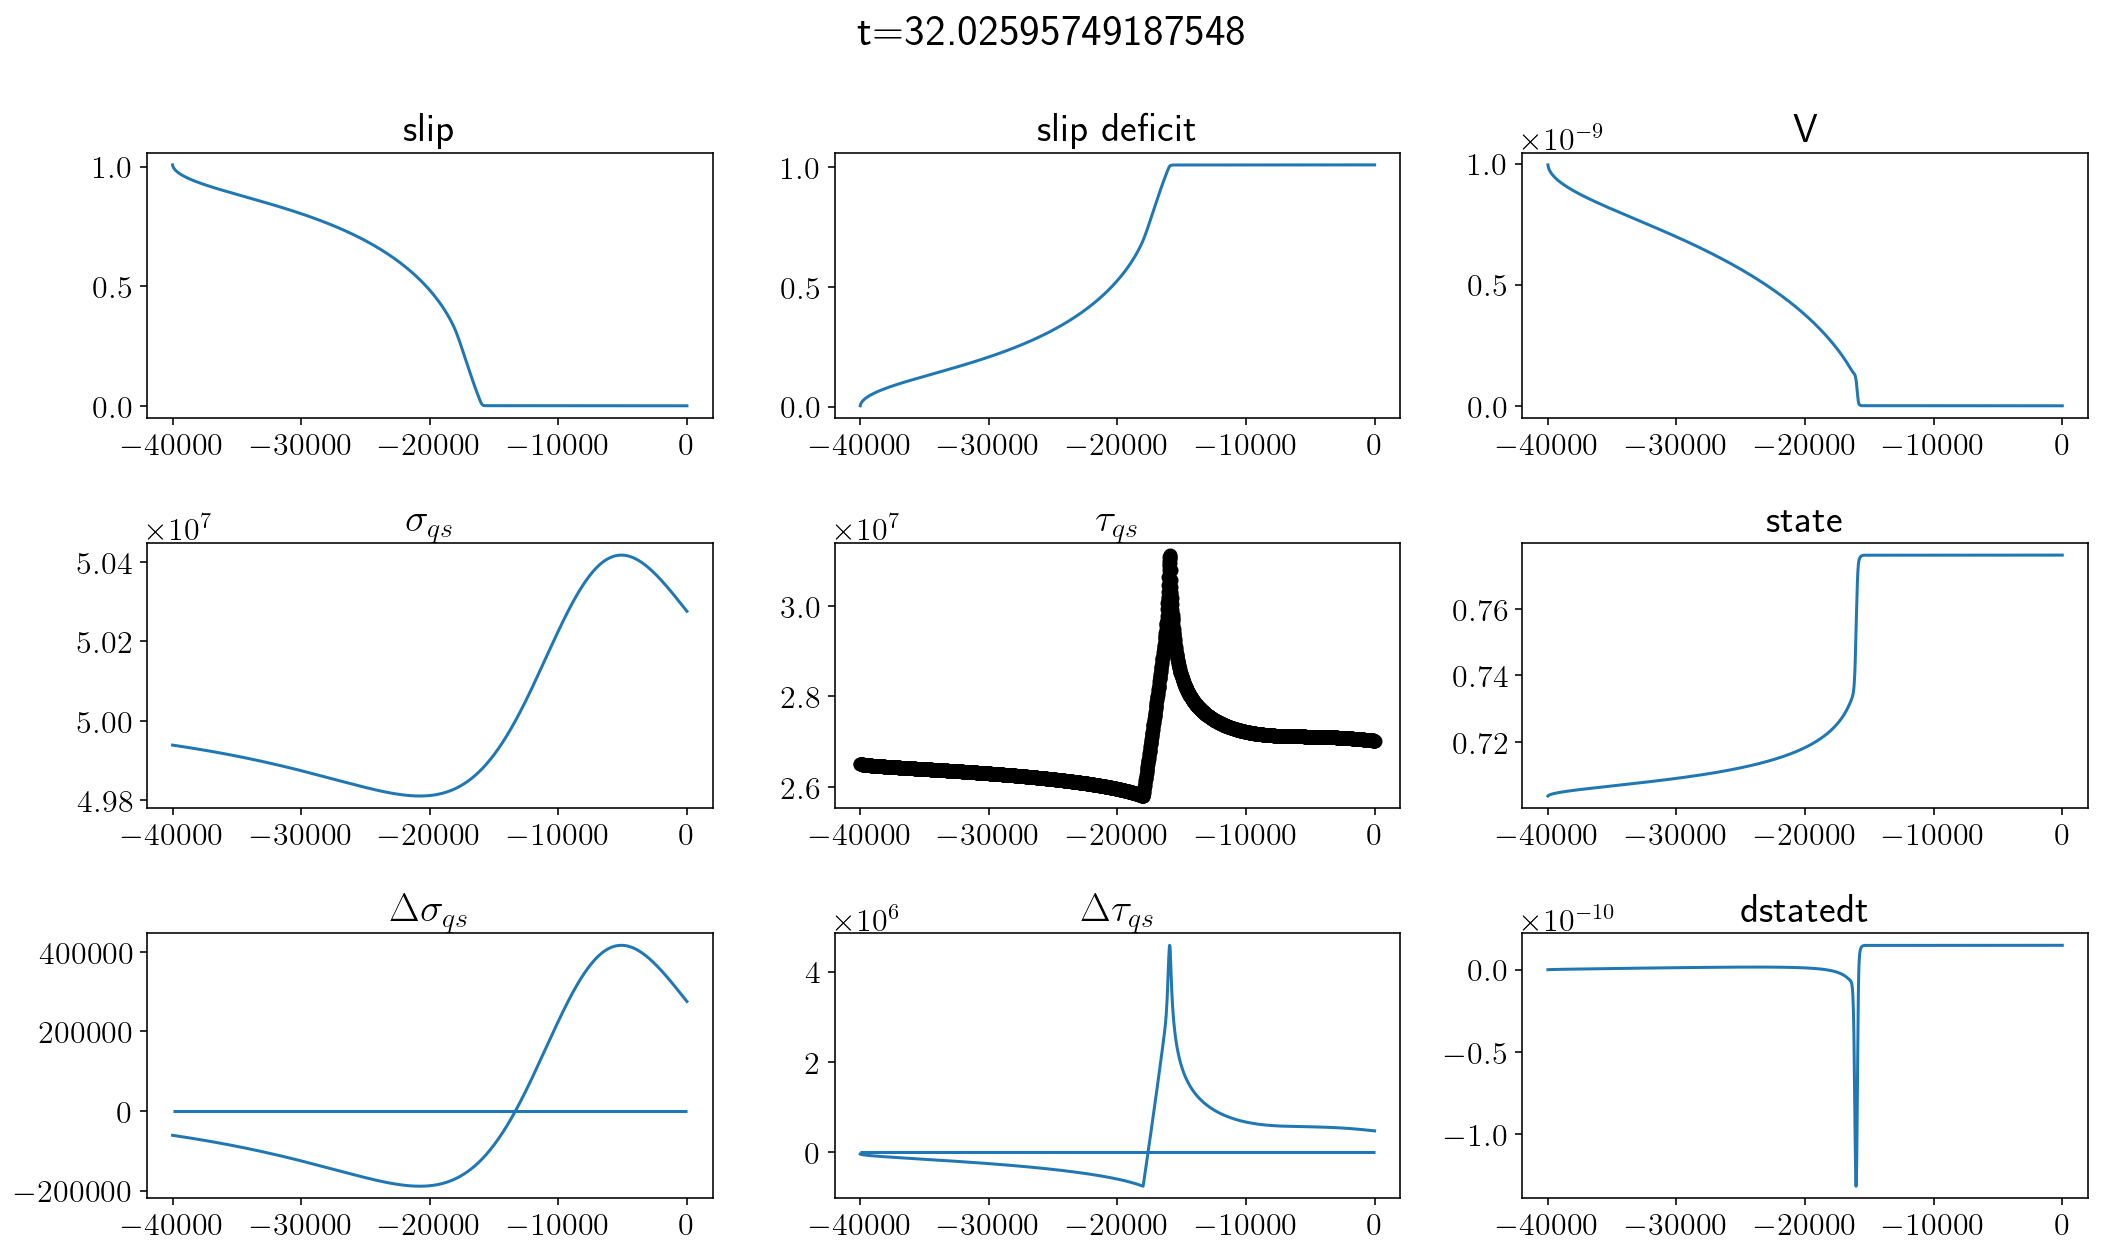

step=1400, time=34.76862794283215 yrs, step=0.028410698172348085


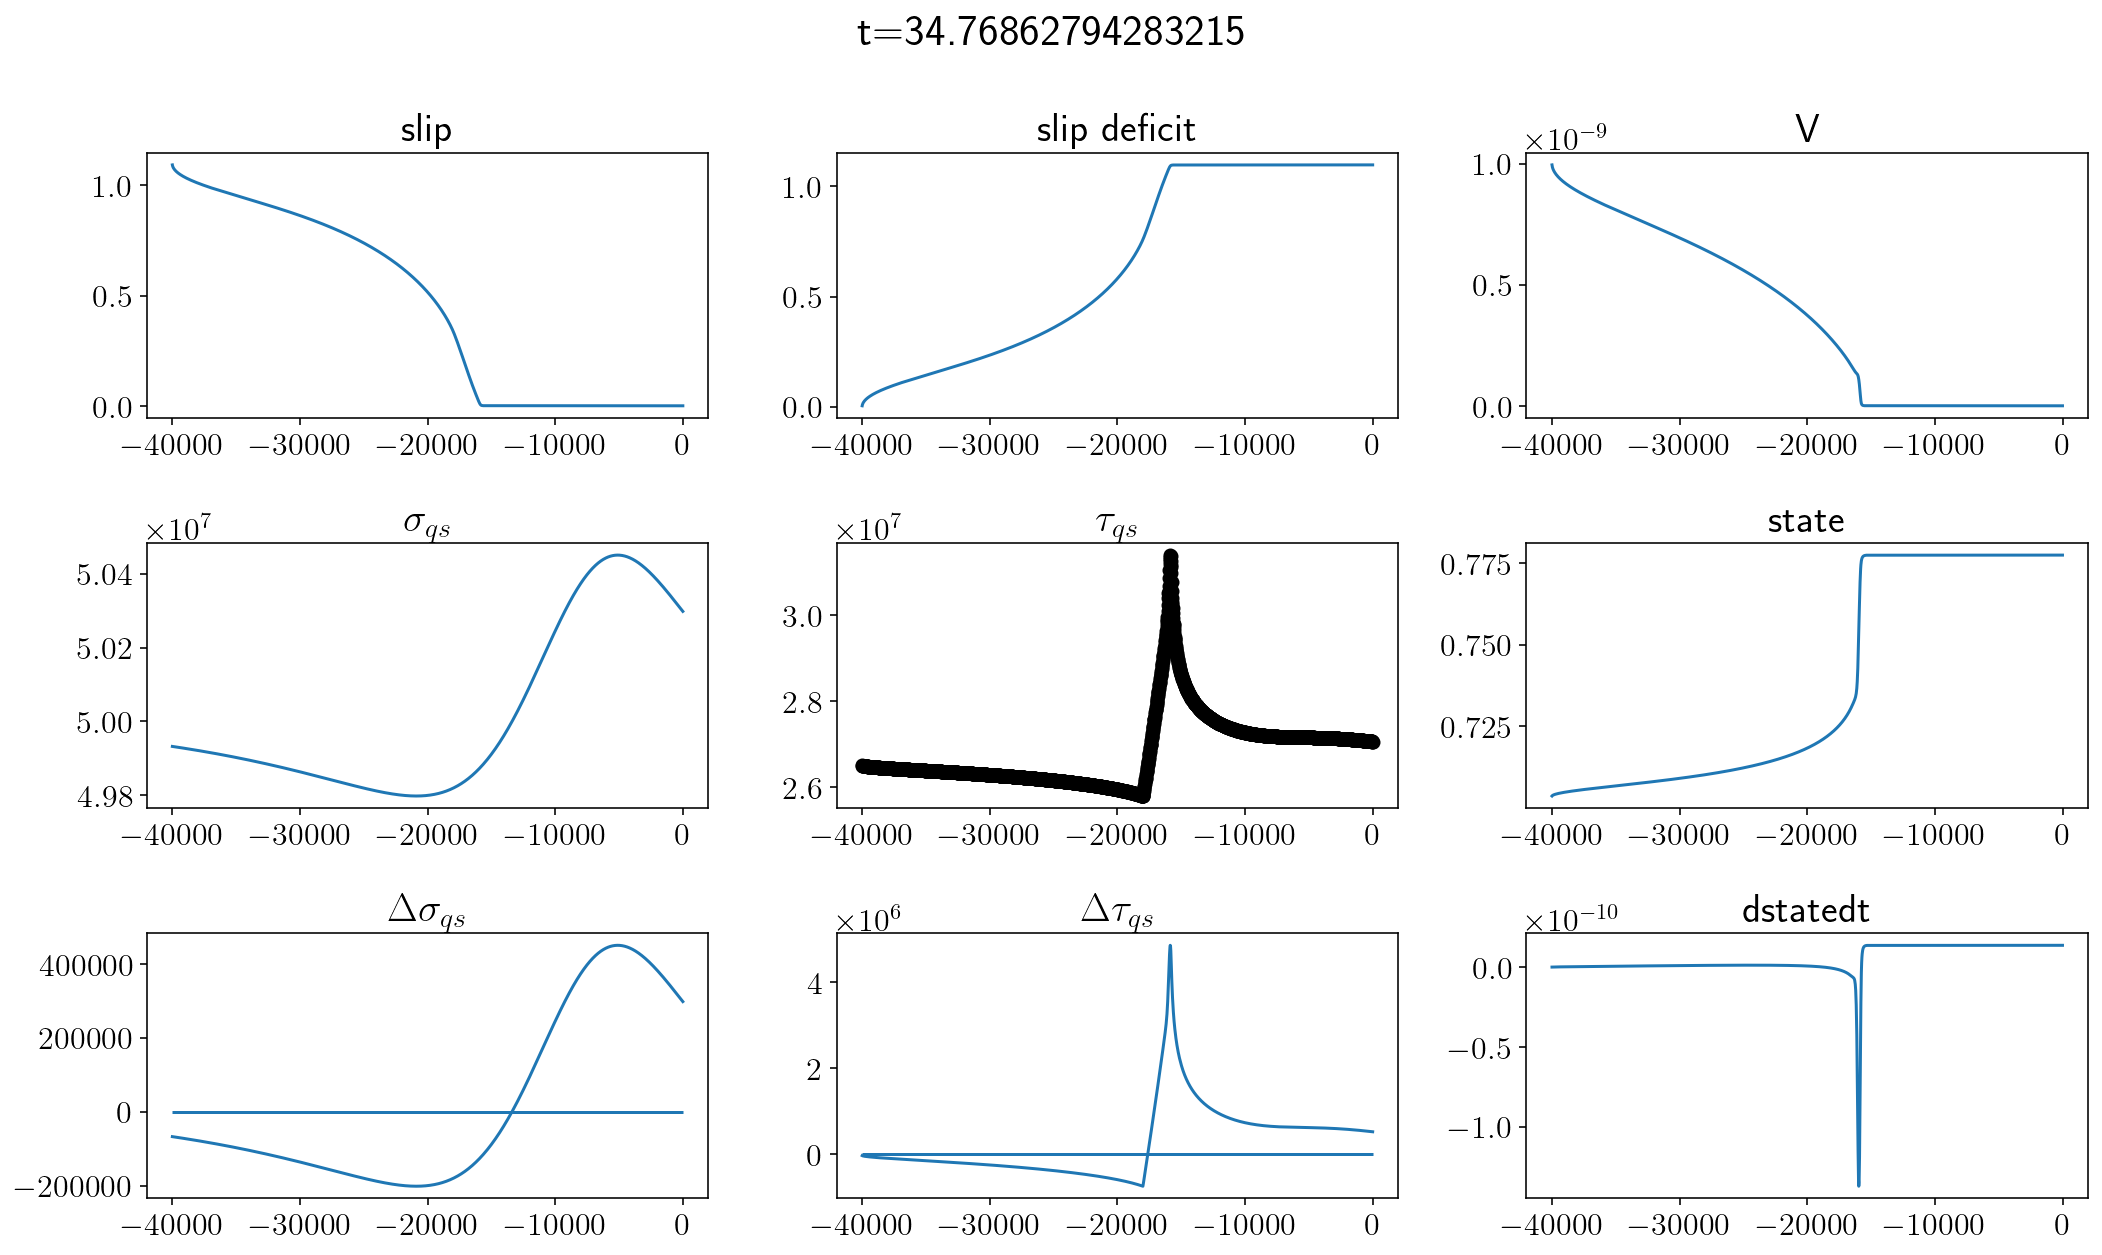

step=1500, time=37.51417327288199 yrs, step=0.02544276978461437


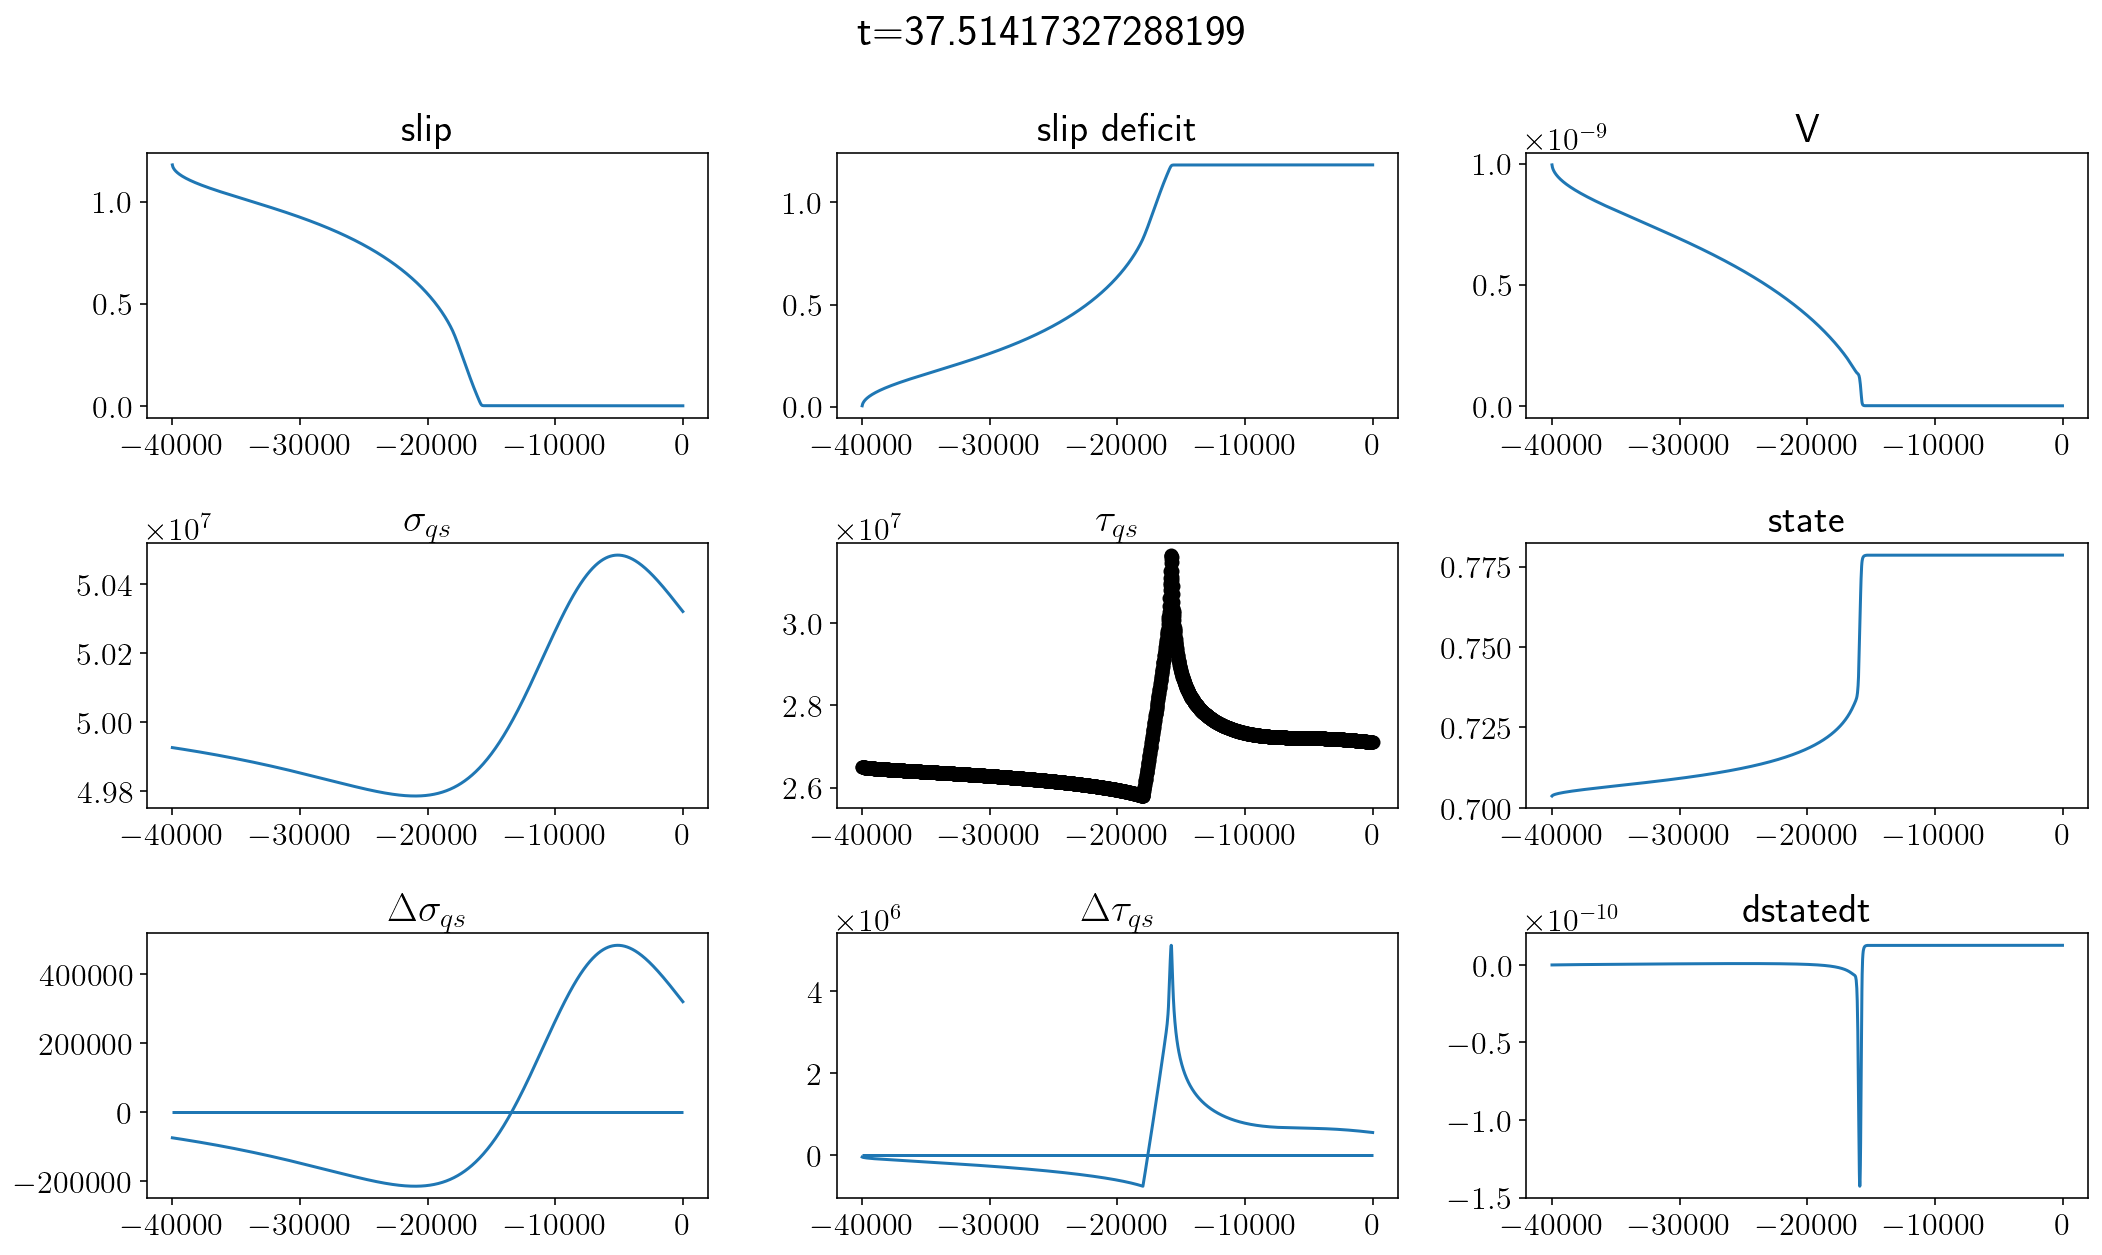

step=1600, time=40.26275833184229 yrs, step=0.02548438252701351


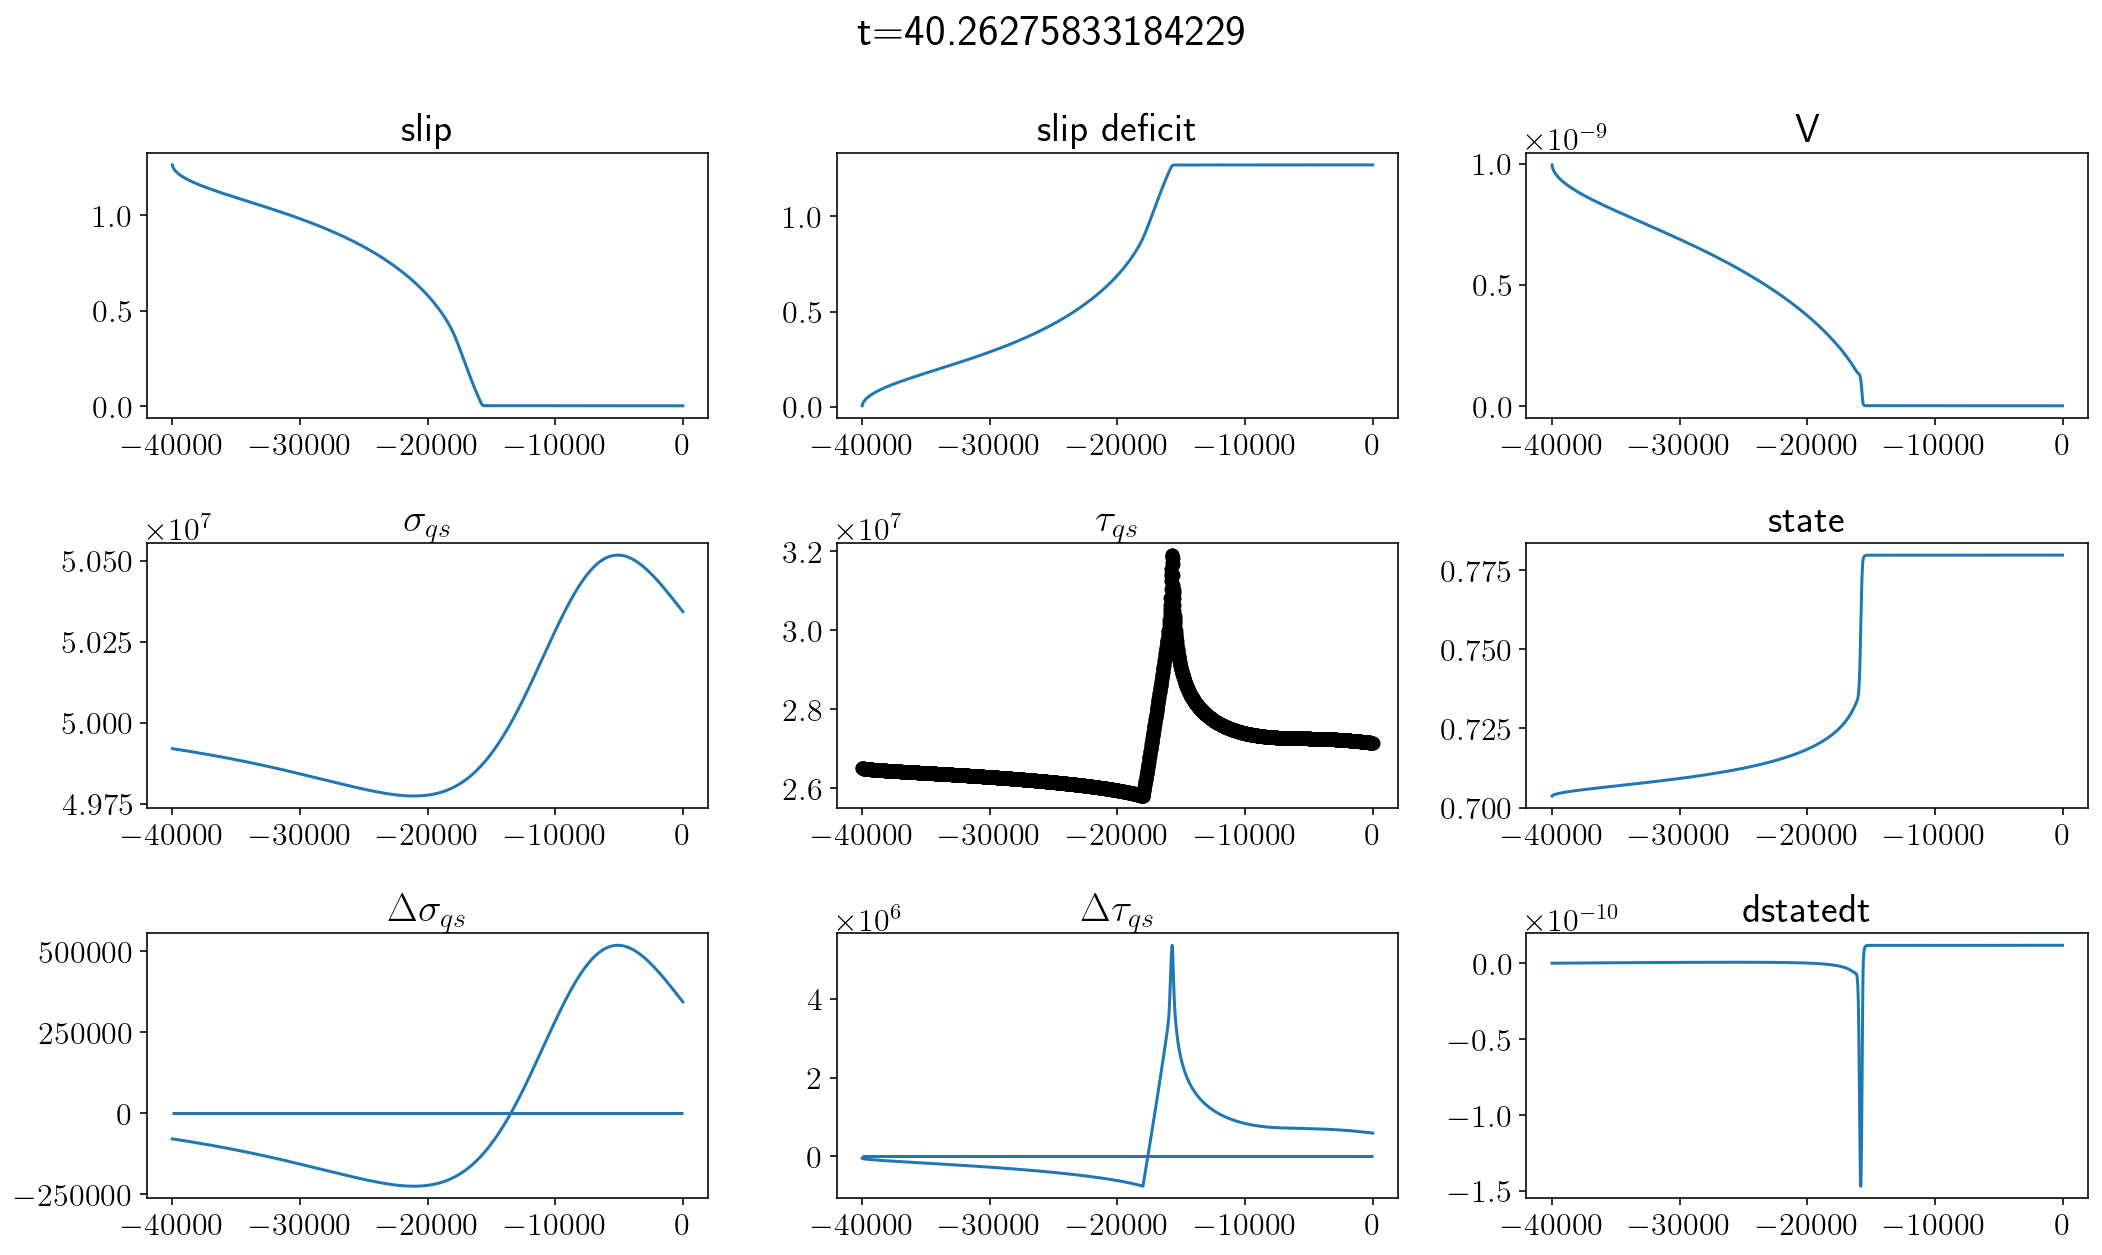

step=1700, time=43.011413150024744 yrs, step=0.030520984456931684


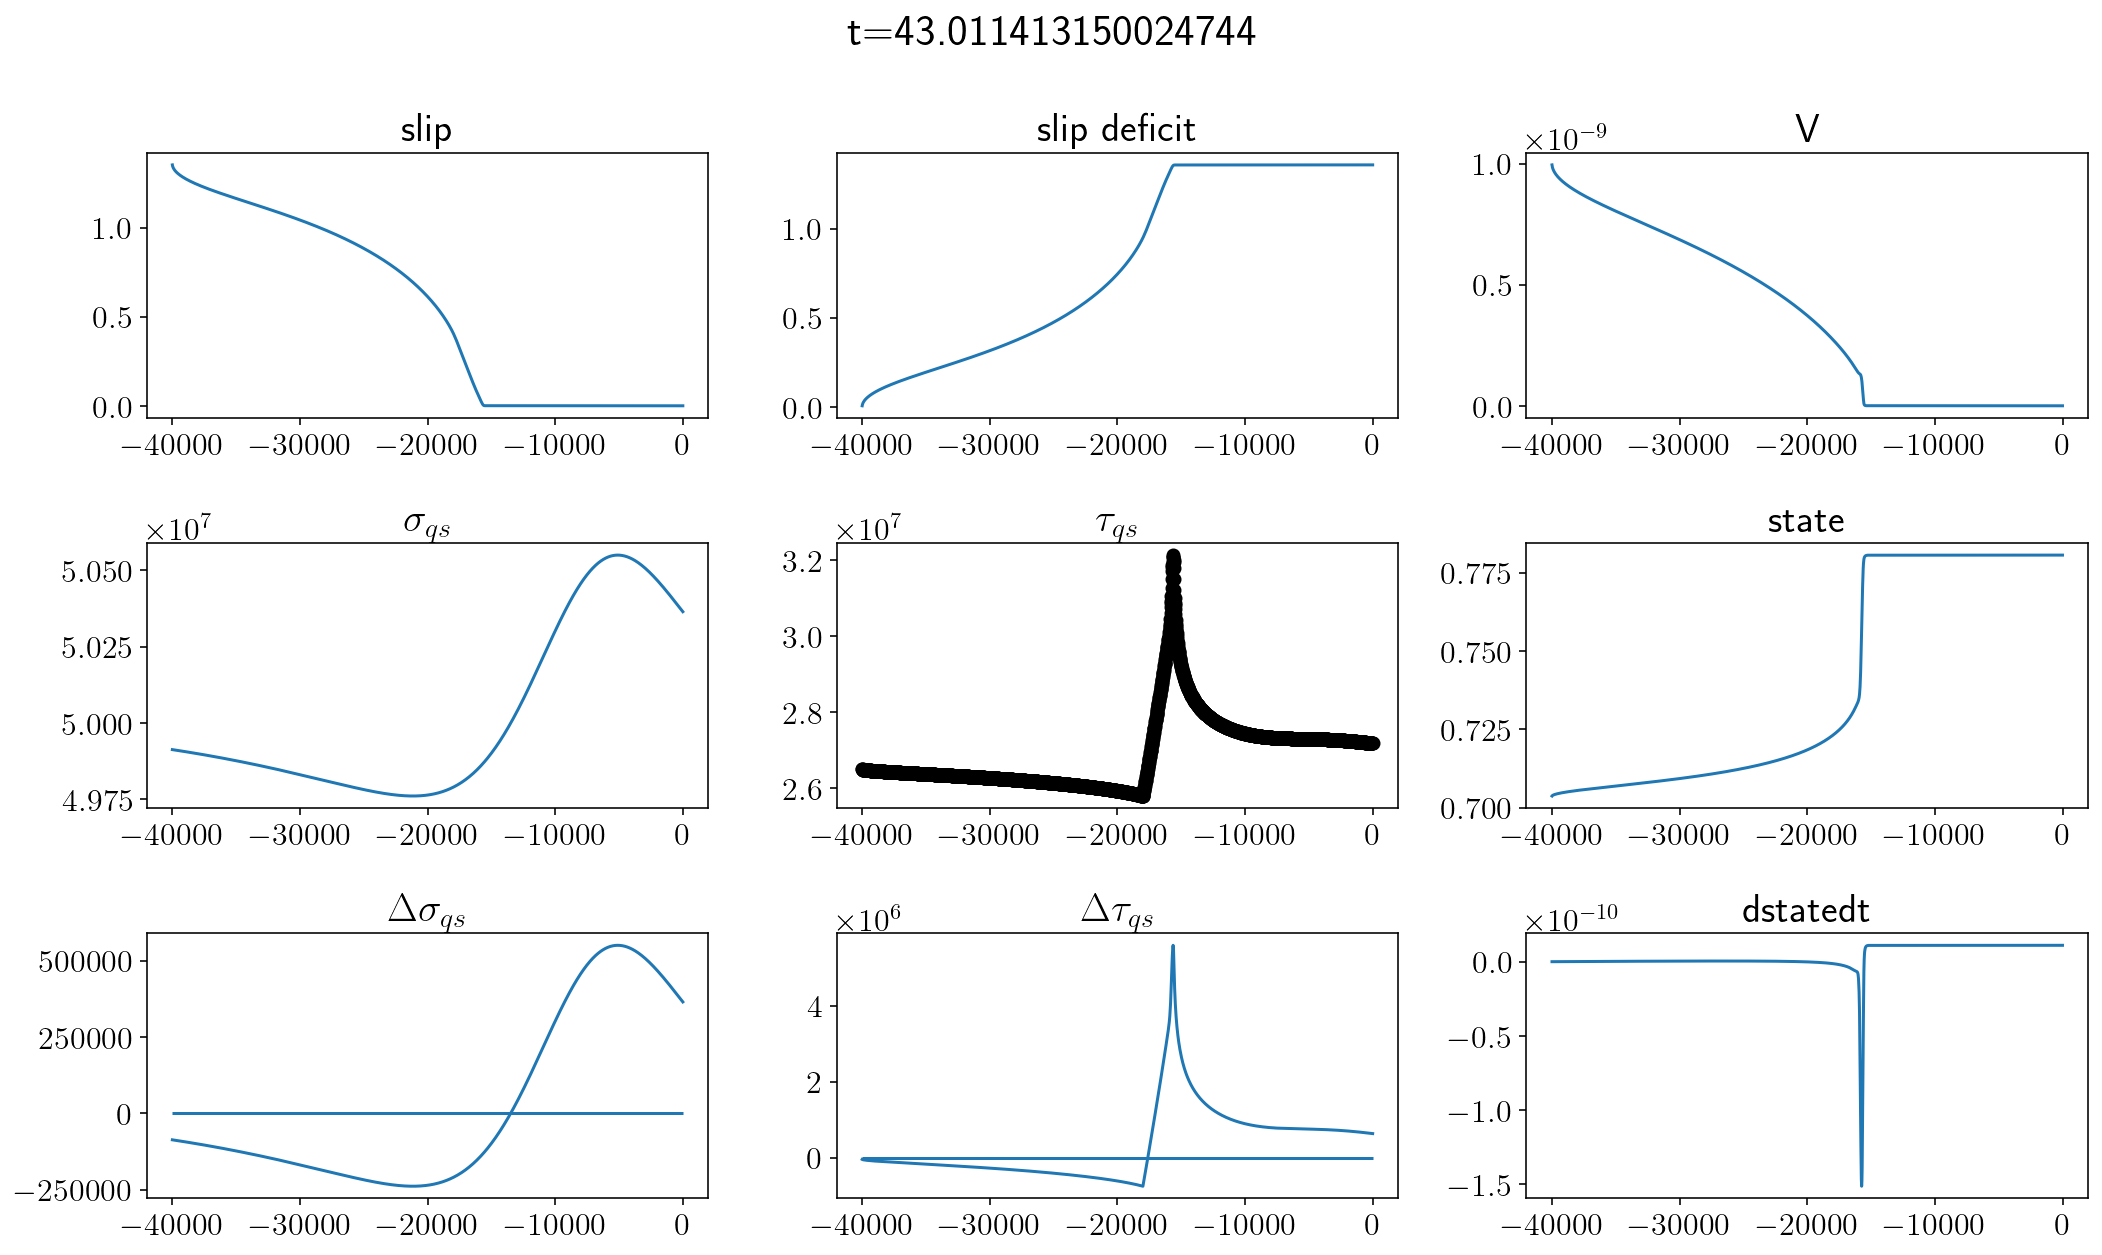

step=1800, time=45.754973765157146 yrs, step=0.02841938622025088


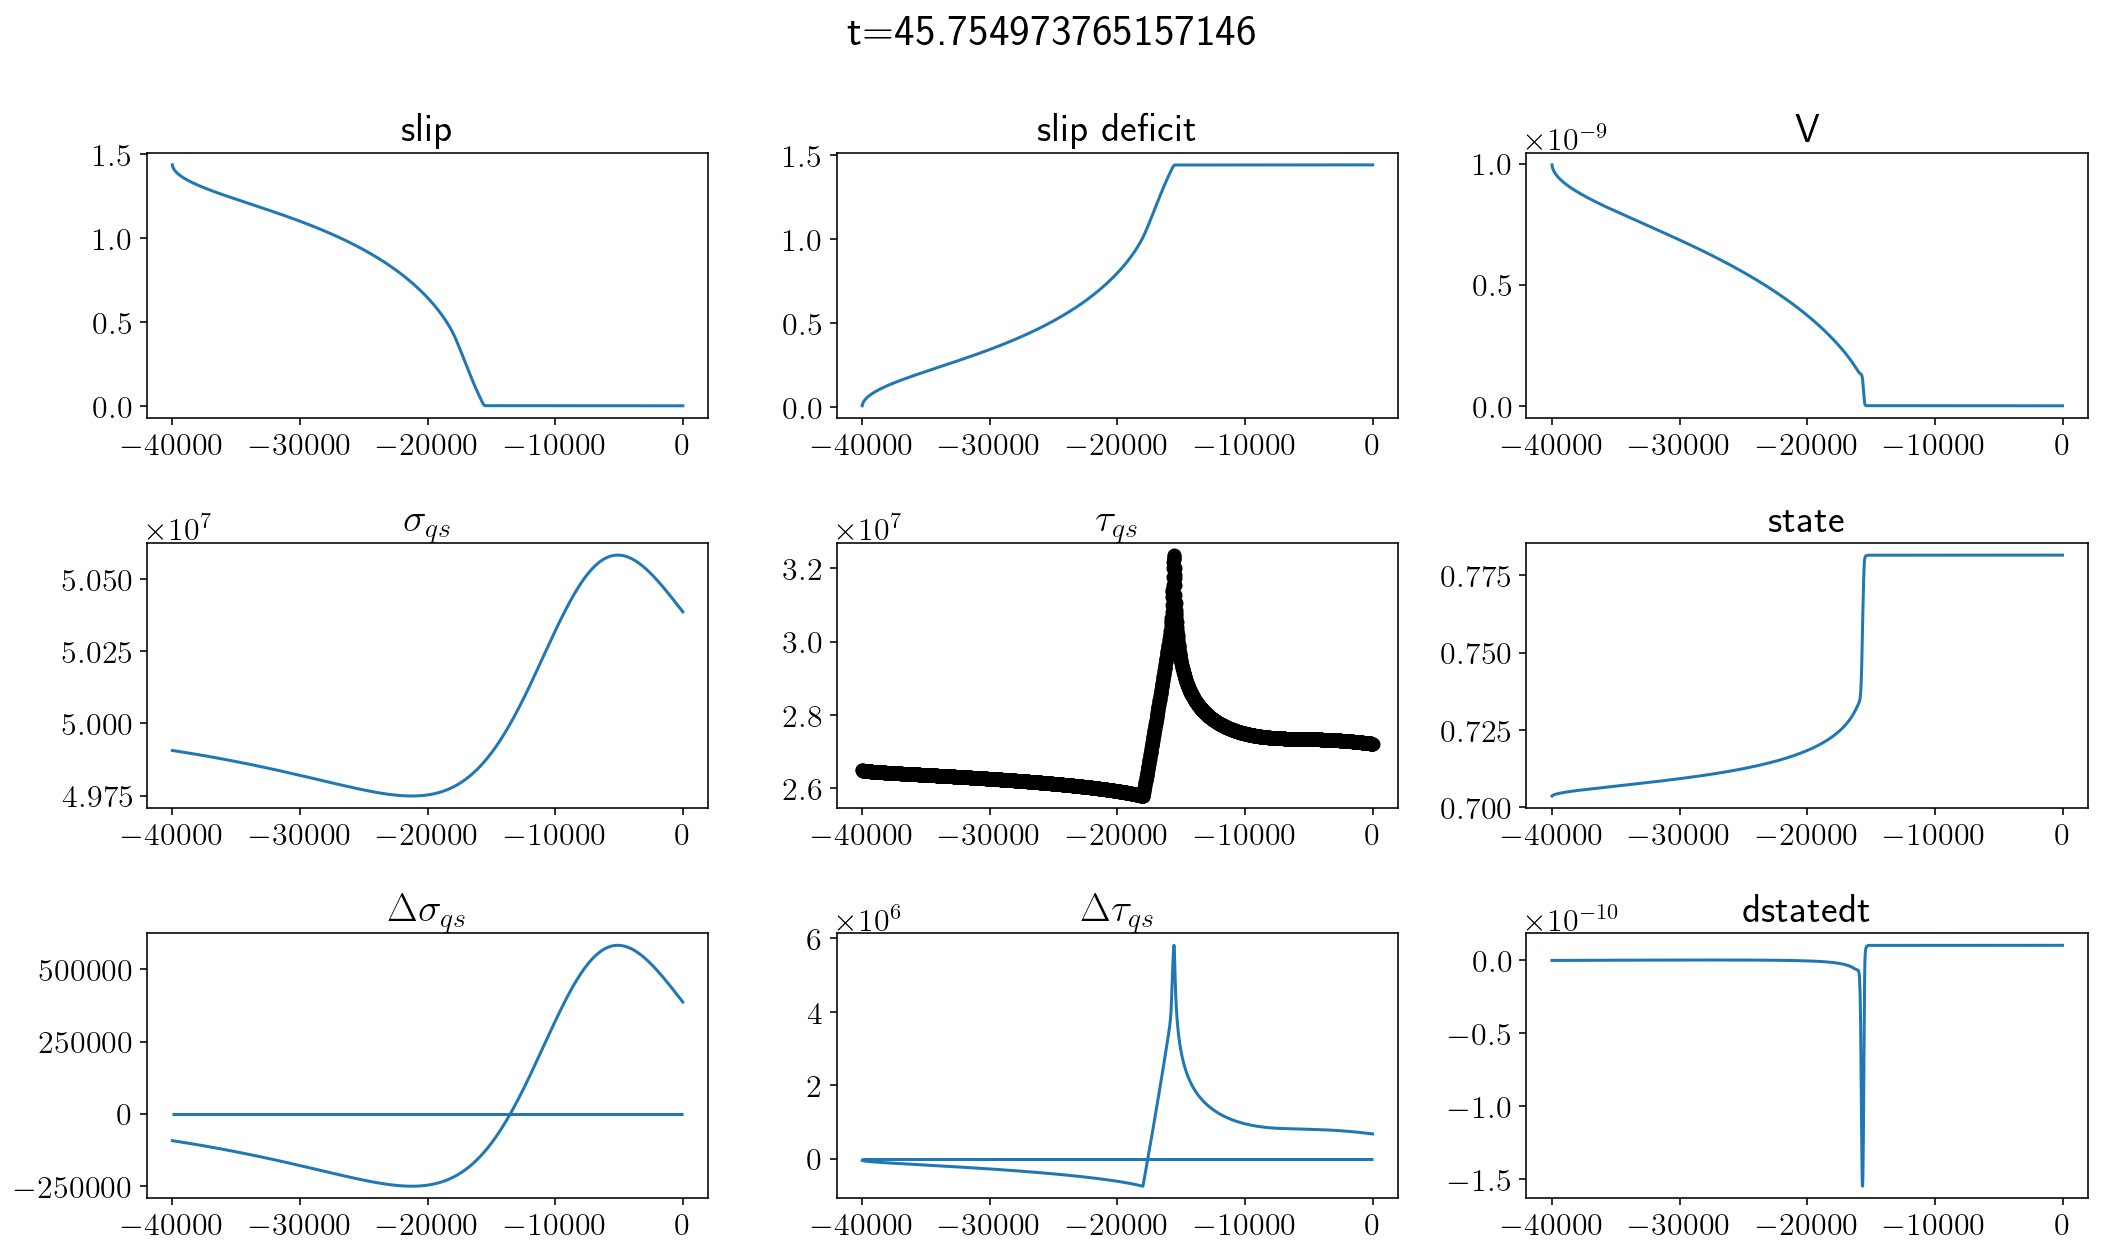

step=1900, time=48.50057124646293 yrs, step=0.025512173384817472


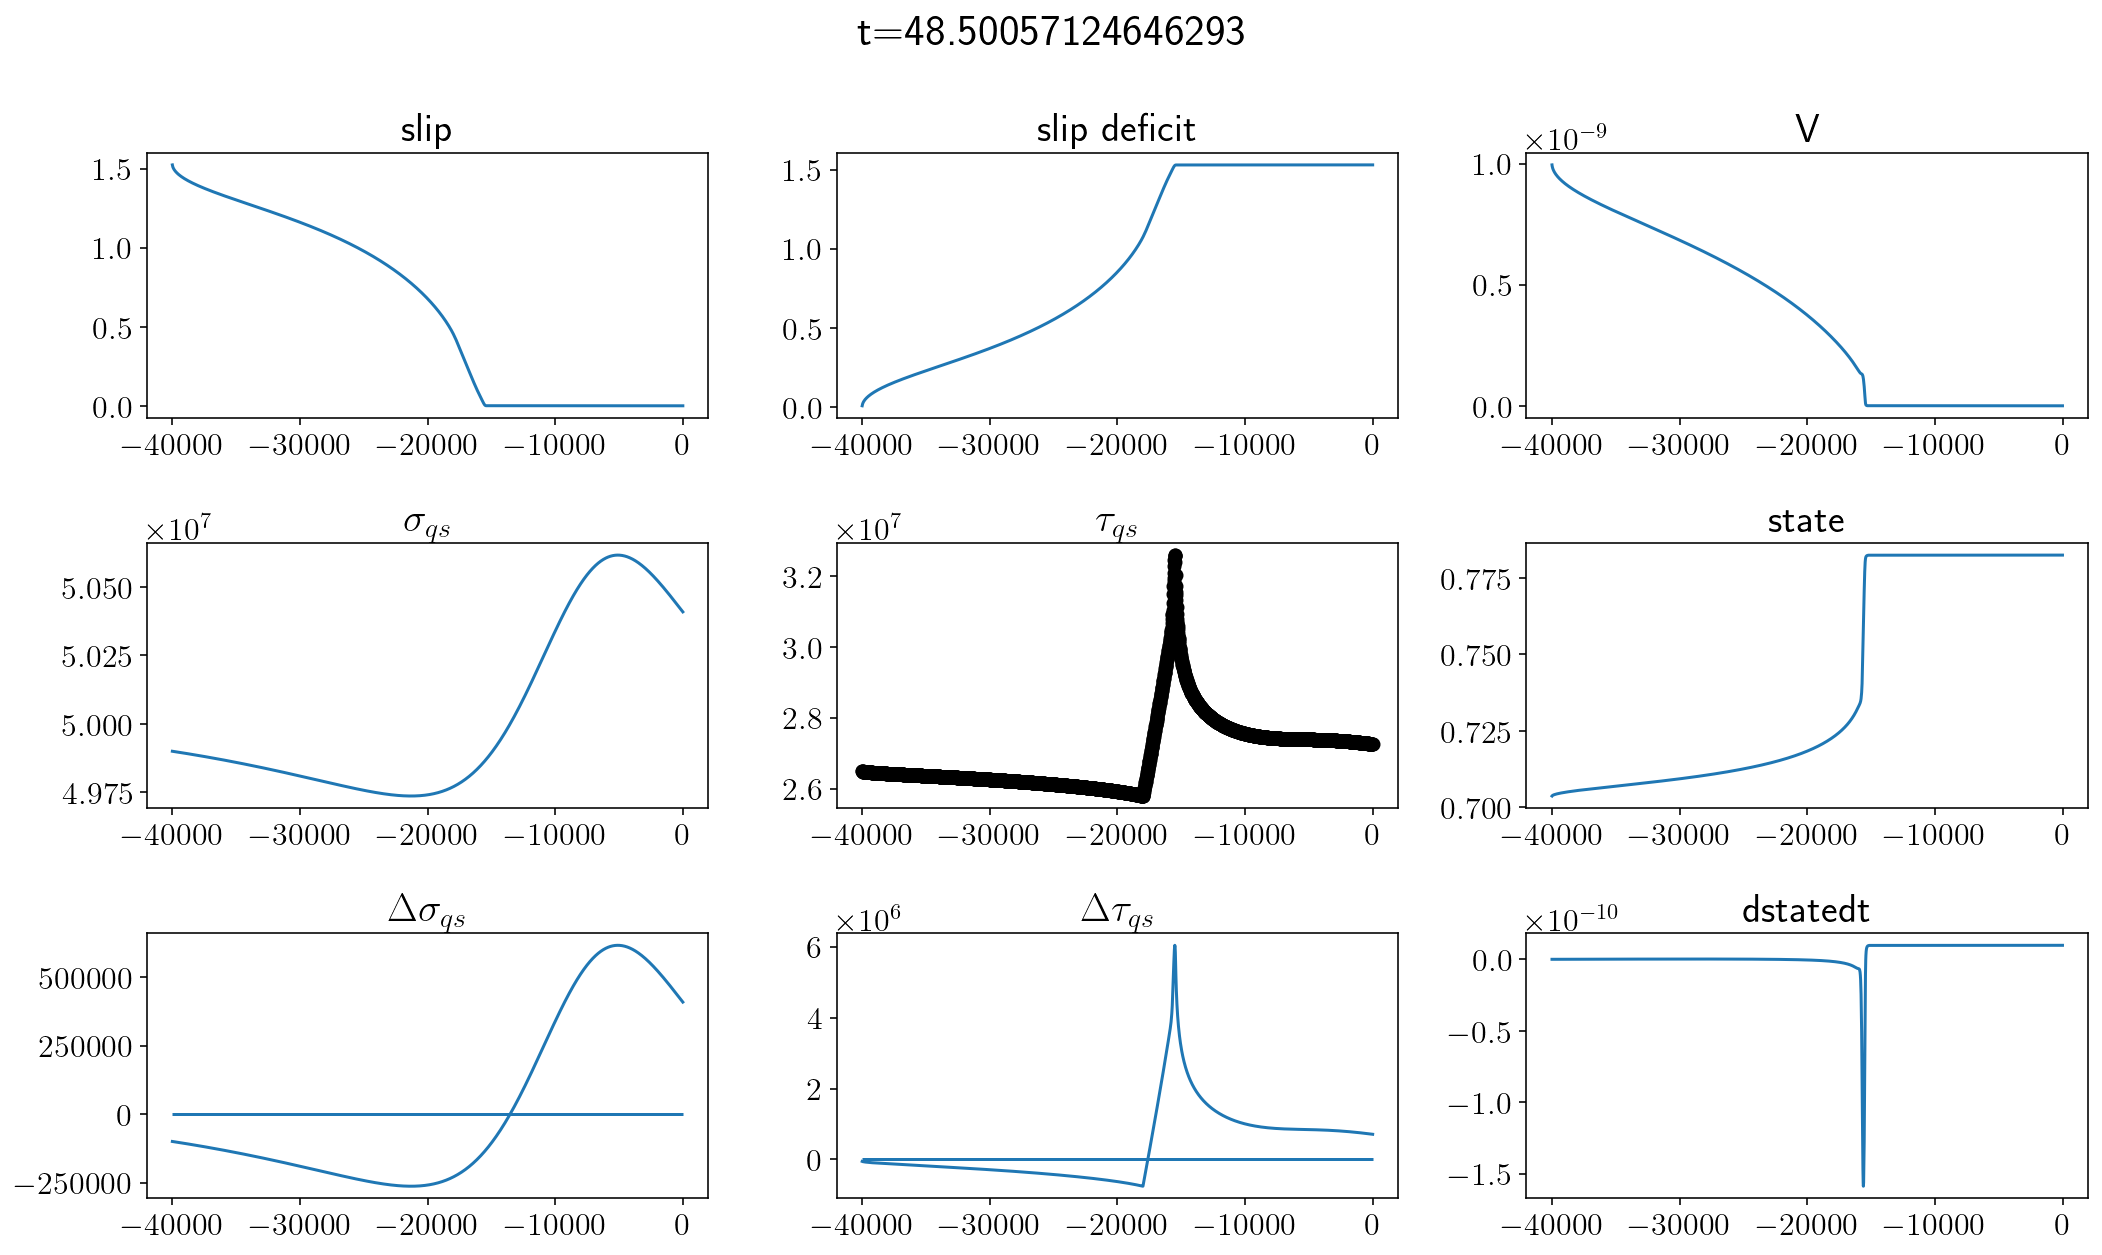

step=2000, time=51.248743929334466 yrs, step=0.02554804793238434
step=2000, time=51.248743929334466 yrs, step=0.02554804793238434


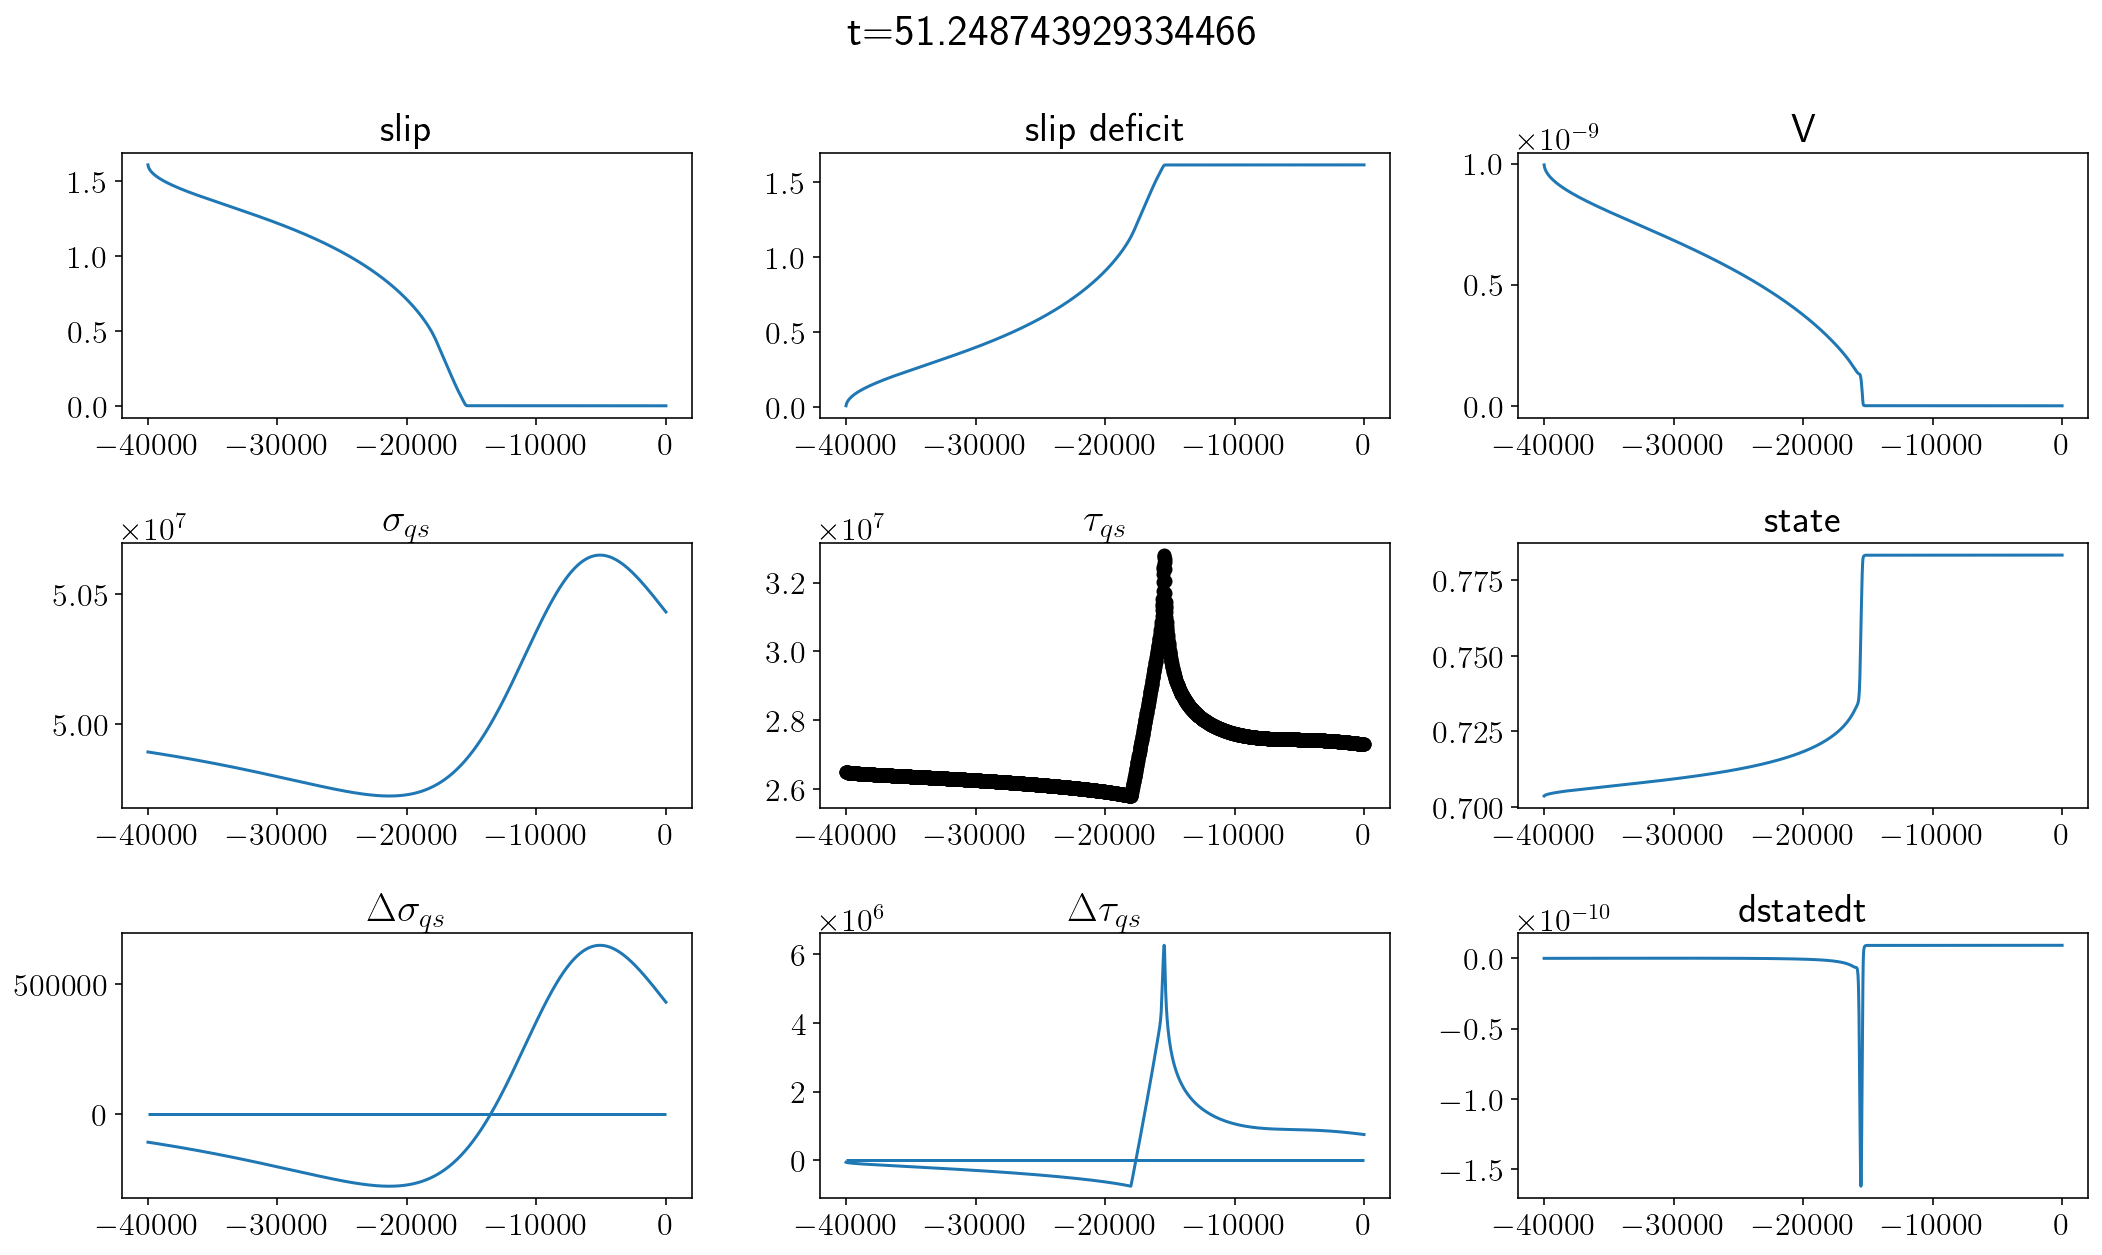

step=2100, time=53.99659111717204 yrs, step=0.030376532483915804


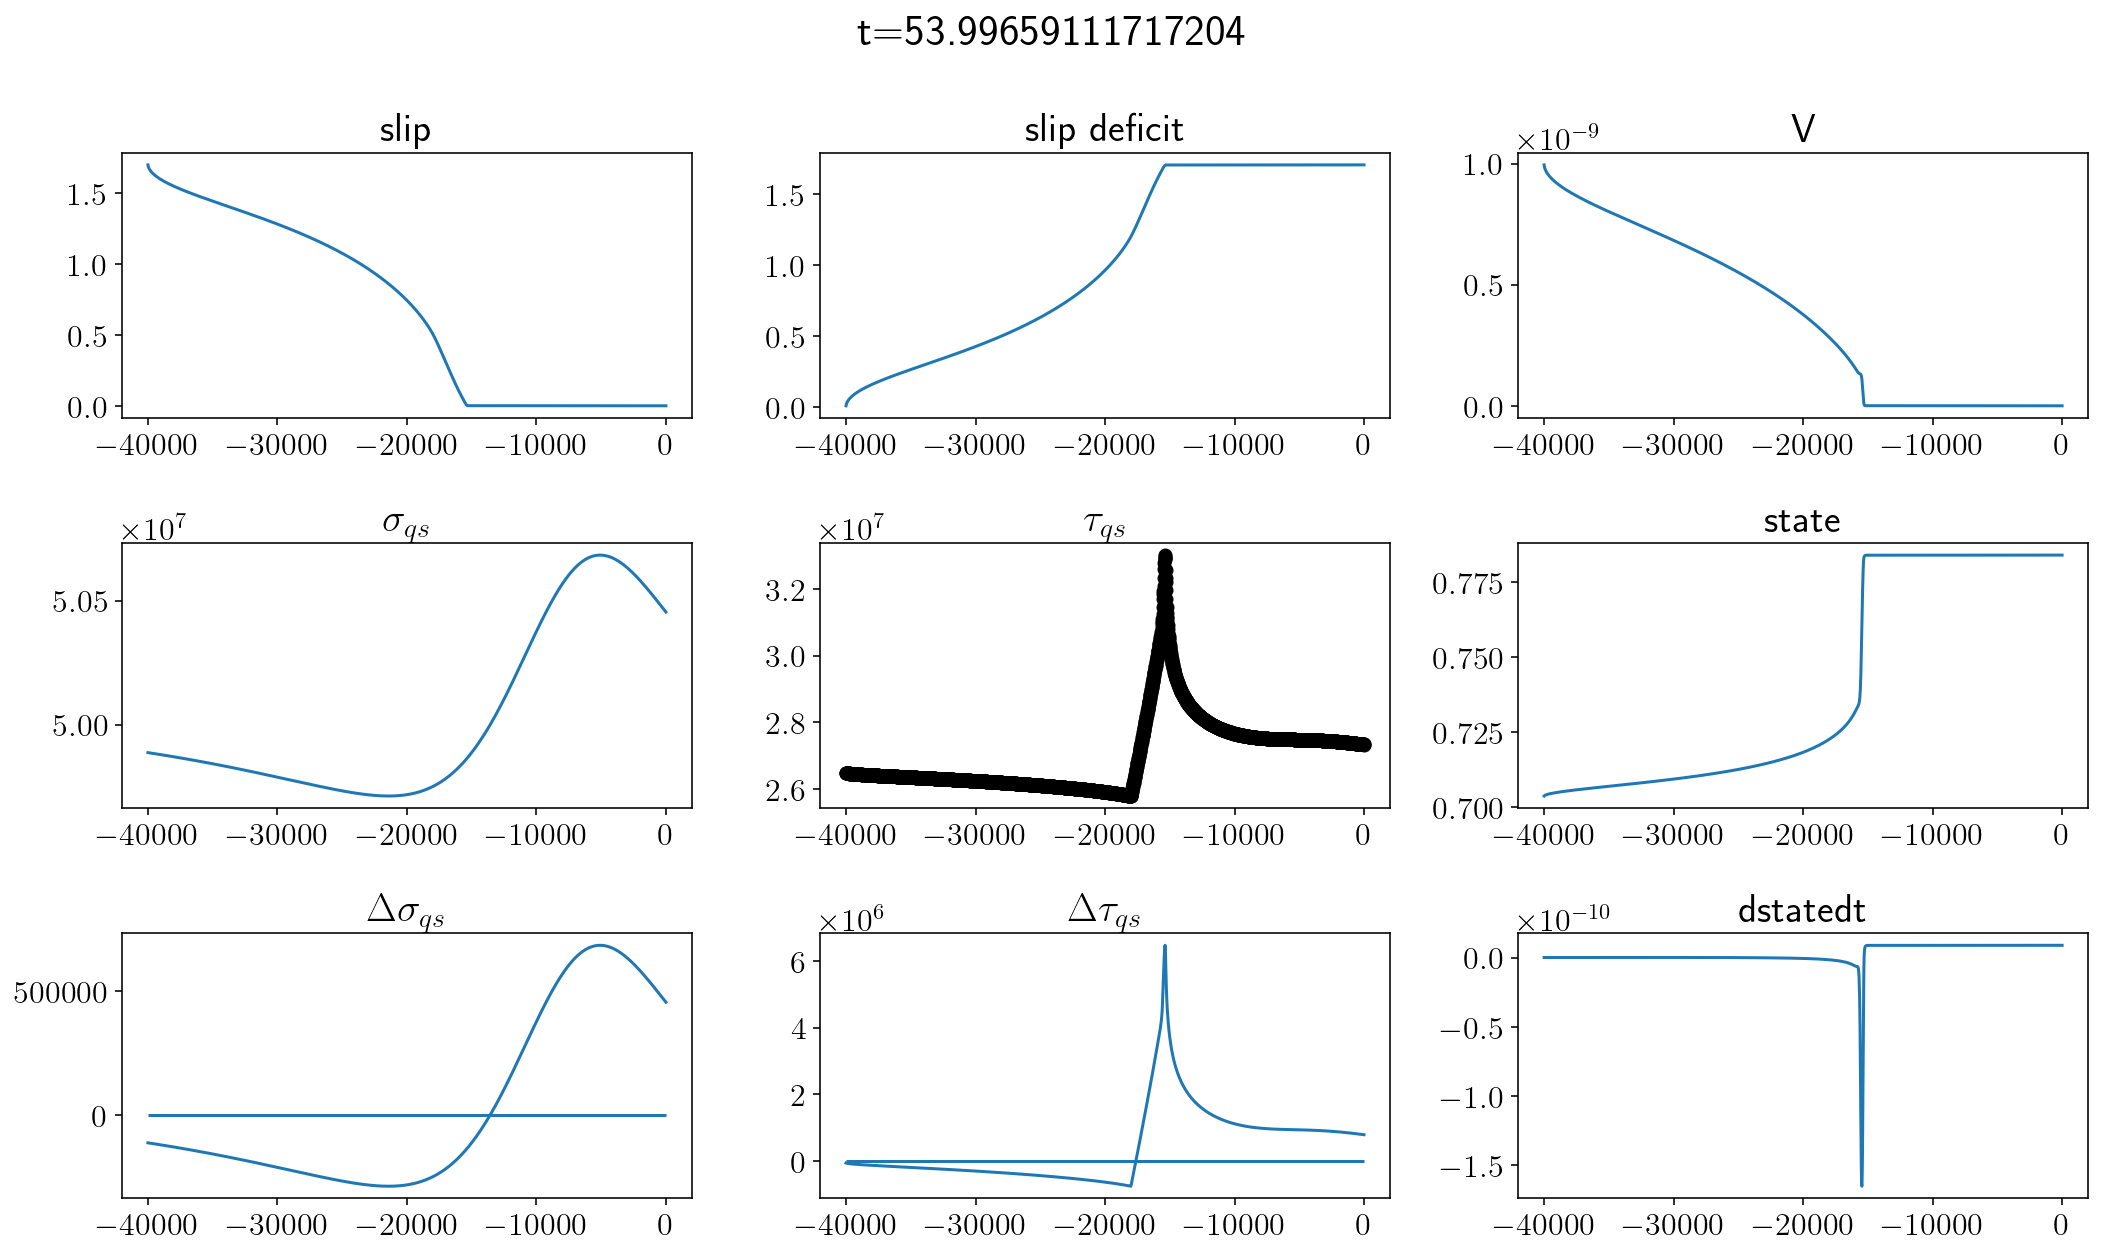

step=2200, time=56.73929181721609 yrs, step=0.028353698040049863


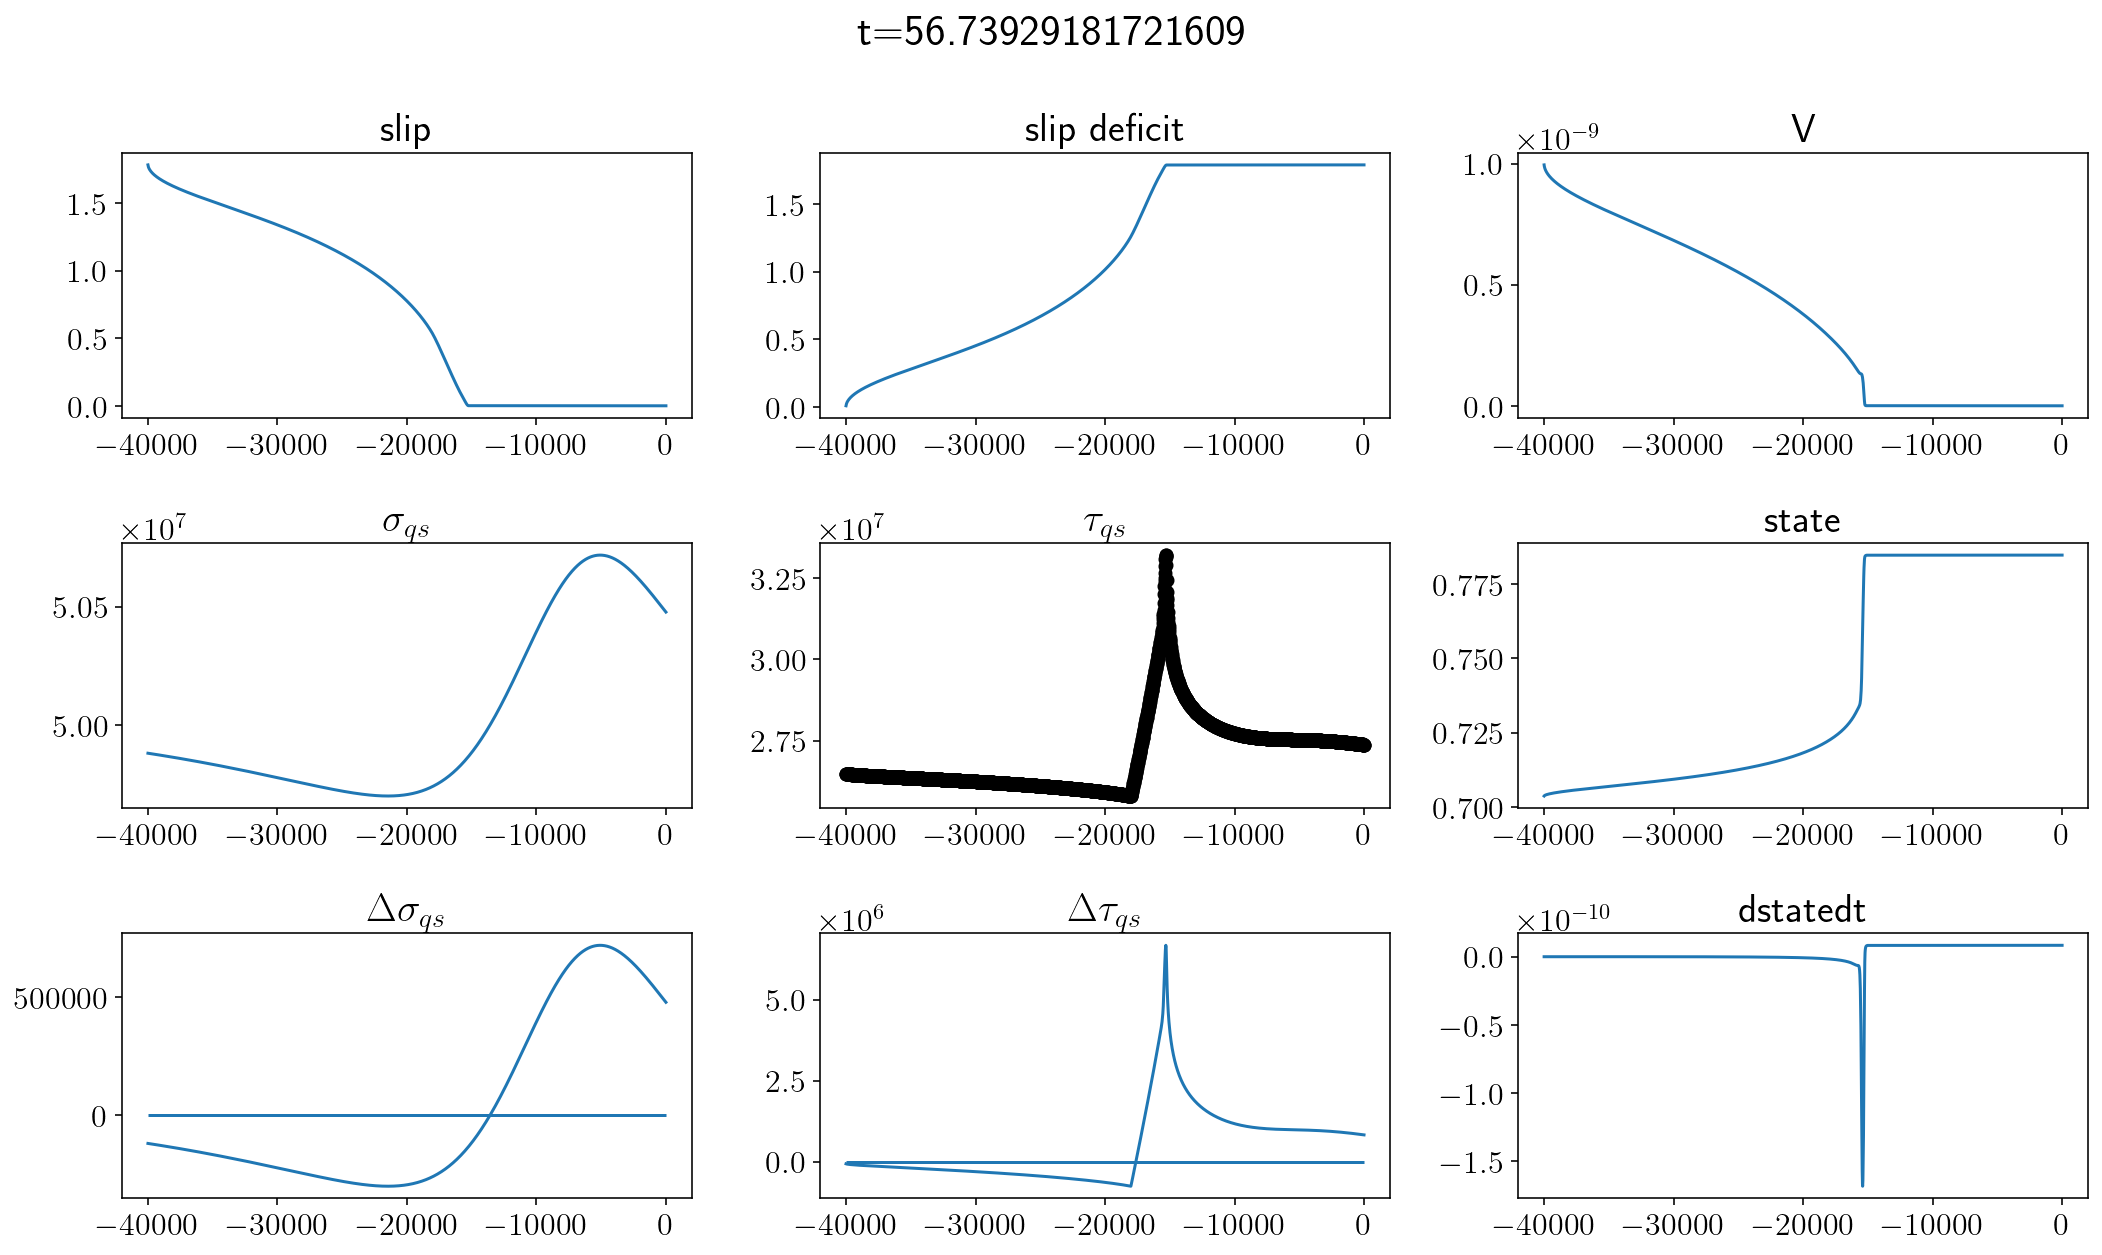

step=2300, time=59.48372049077319 yrs, step=0.025590060011408094


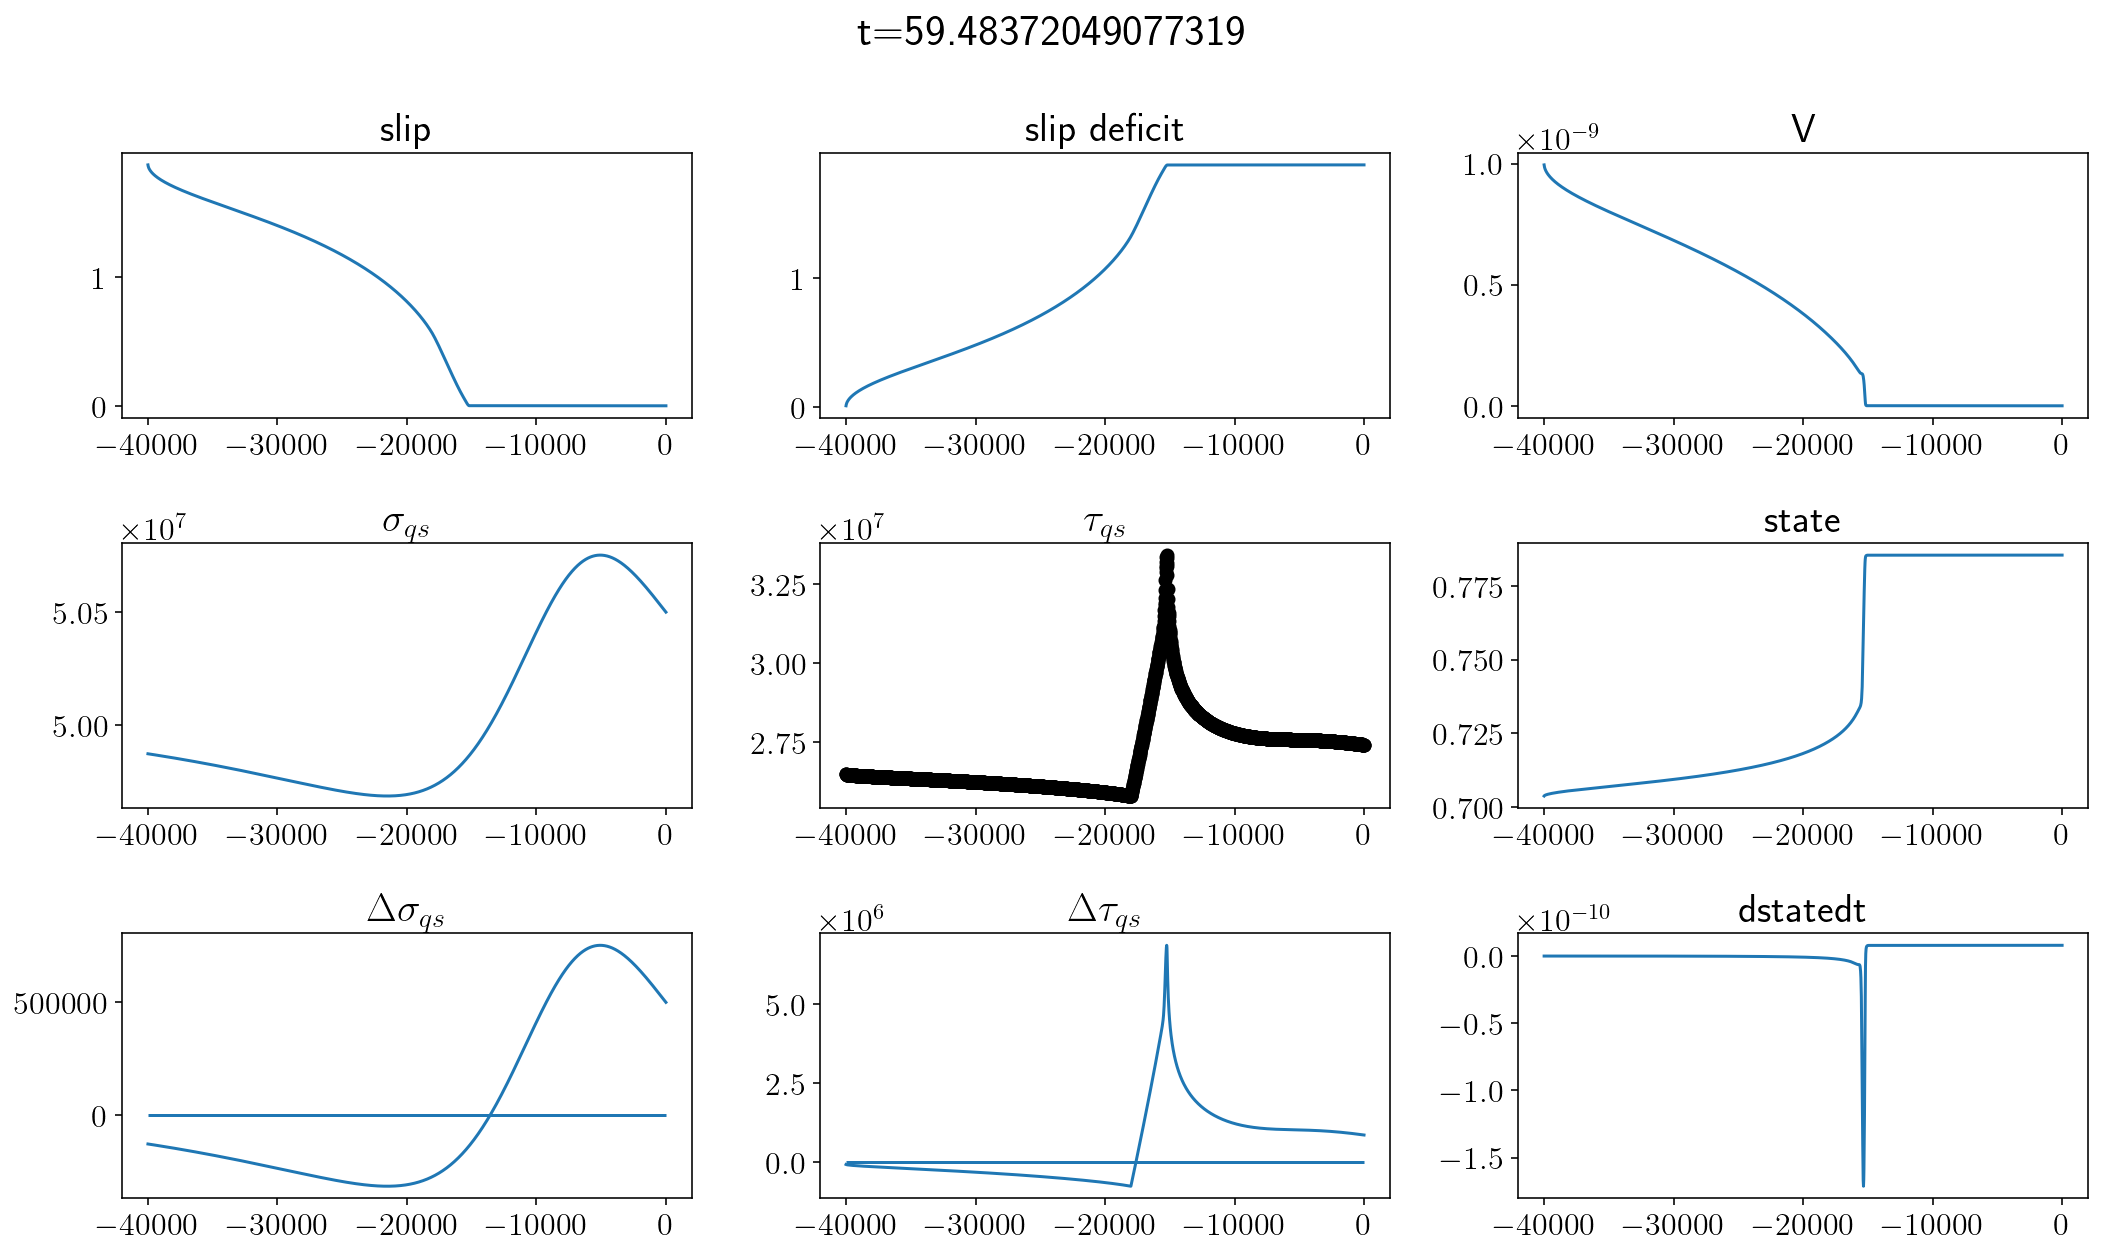

Exception: Failed to converge.

In [22]:
%%time
from scipy.integrate import RK23, RK45

# We use a 5th order adaptive Runge Kutta method and pass the derivative function to it
# the relative tolerance will be 1e-11 to make sure that even 
state = SystemState()
derivs = lambda t, y: calc_derivatives(state, t, y)
integrator = RK45
atol = Vp * 1e-6
rtol = 1e-11
rk = integrator(derivs, 0, init_conditions, 1e50, atol=atol, rtol=rtol)

# Set the initial time step to one day.
rk.h_abs = 60 * 60 * 24

# Integrate for 1000 years.
max_T = 300 * siay

n_steps = 50000
t_history = [0]
y_history = [init_conditions.copy()]
for i in range(n_steps):
    # Take a time step and store the result
    if rk.step() != None:
        raise Exception("TIME STEPPING FAILED")
    t_history.append(rk.t)
    y_history.append(rk.y.copy())

    # Print the time every 5000 steps
    if i % 1000 == 0:
        print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
    if i % 100 == 0:
        print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
        plot_system_state(rk.t, state.calc(rk.t, rk.y))#, xlim=[-21000, -14000])

    if rk.t > max_T:
        break

y_history = np.array(y_history)
t_history = np.array(t_history)

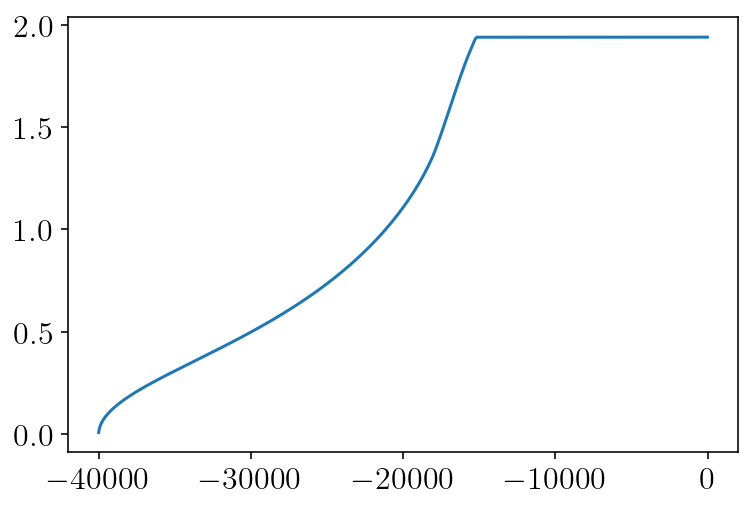

In [23]:
t, y = rk.t, rk.y
(
    slip_deficit,
    state_var,
    delta_sigma_qs,
    sigma_qs,
    delta_tau_qs,
    tau_qs,
    V,
    slip_deficit_rate,
    dstatedt,
) = state.calc(t, y)

slip = Vp * t - slip_deficit
fd = -np.linalg.norm(fault.pts, axis=1)
plt.plot(fd, slip_deficit)
plt.show()

In [ ]:
S = np.stack((-ny*slip_deficit, nx*slip_deficit), axis=1)
traction = total_fault_slip_to_fault_traction.dot(S.ravel()).reshape((-1, 2))
sigma_qs = np.sum(traction * np.stack((nx, ny), axis=1), axis=1)
tau_qs = np.sum(traction * np.stack((-ny, nx), axis=1), axis=1)

In [ ]:
rk.t / 1e7

221.7794954571345

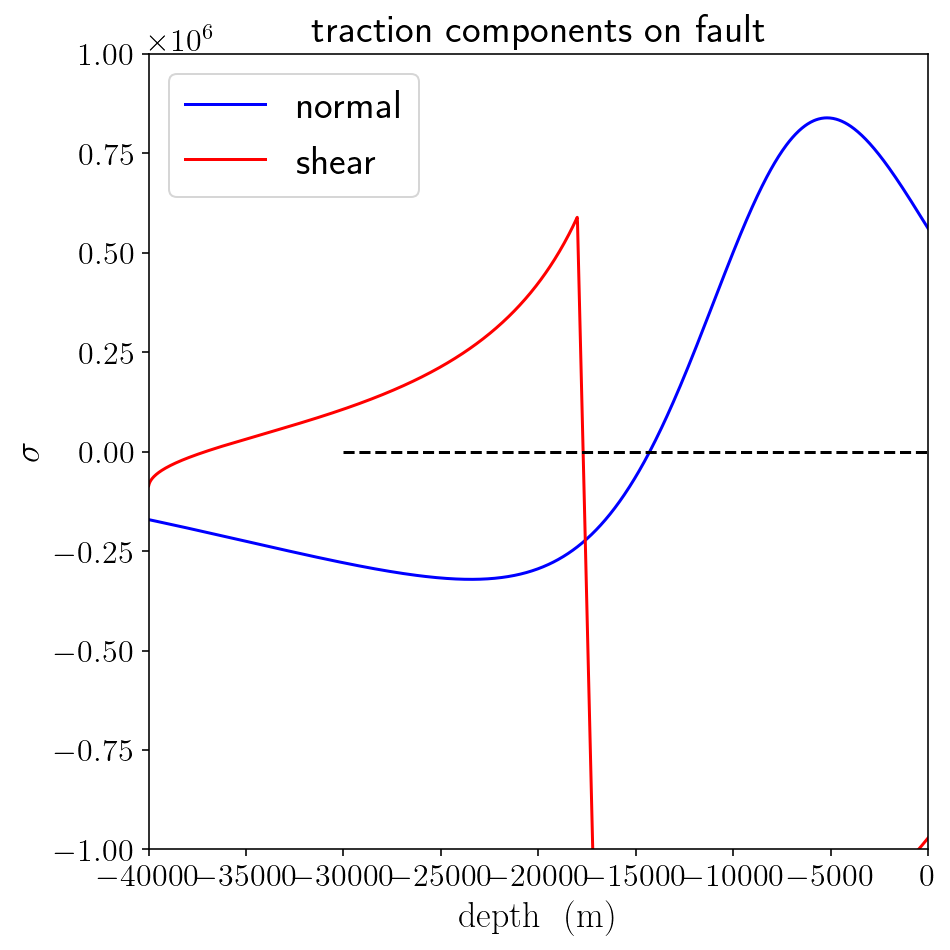

In [ ]:

plt.figure(figsize=(7,7))
plt.title('traction components on fault')
plt.plot(fd, sigma_qs, 'b-', label='normal')
plt.plot(fd, tau_qs, 'r-', label='shear')
plt.hlines([0], [-30000], [0], 'k', linestyles=['dashed'])
plt.xlim([-40000, 0])
plt.ylim([-1e6, 1e6])
plt.xlabel('$\mathrm{depth ~~ (m)}$')
plt.ylabel('$\sigma$')
plt.legend()
plt.tight_layout()
plt.show()


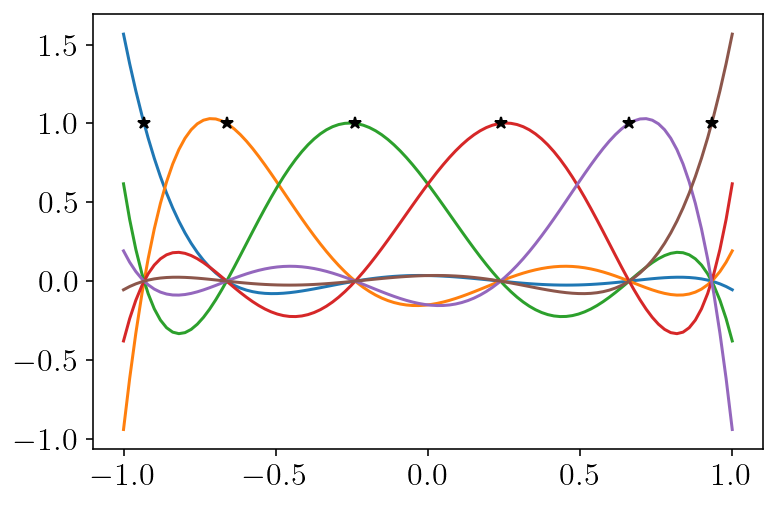

In [ ]:
nq=6
V = data[-200, -nq:]
nodes = fault.qx
matrix = np.zeros((nq, nq))
for i in range(nq):
    matrix[:, i] = nodes ** i
coeffs = np.empty((nq, nq))
xs = np.linspace(-1, 1, 100)
for i in range(nq):
    rhs = np.zeros(nq)
    rhs[i] = 1
    coeffs[i,:] = np.linalg.solve(matrix, rhs)
    vs = np.sum(coeffs[None,i, :] * (xs[:, None] ** np.arange(nq)[None, :]), axis=1)
    plt.plot(xs, vs, '-')
    plt.plot([nodes[i]], [1], 'k*')
plt.show()

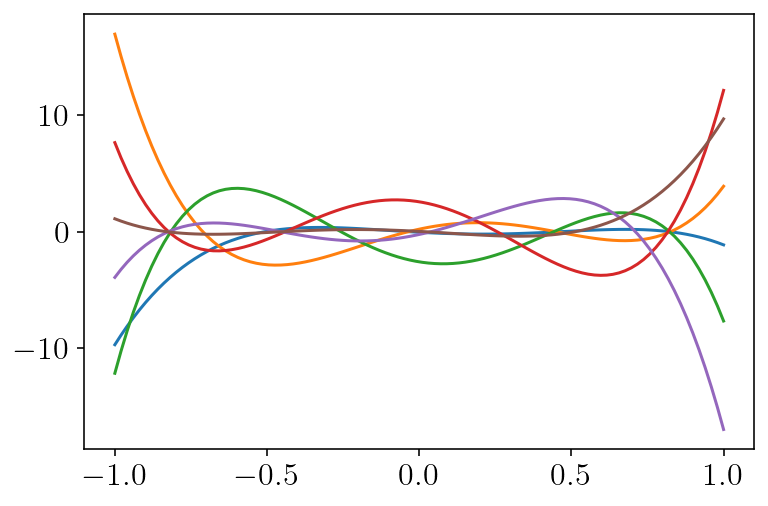

In [ ]:
deriv_coeffs=coeffs[:,1:]*np.arange(1,nq)
for i in range(nq):
    vs = np.sum(deriv_coeffs[None, i, :] * (xs[:, None] ** np.arange(nq-1)[None, :]), axis=1)
    plt.plot(xs, vs, '-')
plt.show()

In [ ]:
vs = np.sum(coeffs[None, 0, :] * (xs[:, None] ** np.arange(nq)[None, :]), axis=1)
deriv_vs = np.sum(deriv_coeffs[None, 0, :] * (xs[:, None] ** np.arange(nq-1)[None, :]), axis=1)
dist = xs[0] - nodes
kernel = fault.interp_wts / dist
kernel[0] / np.sum(kernel)- vs[0]
#vs[0]

-2.220446049250313e-16

In [ ]:
dkernel 

array([334.72892369, -40.07765197,  11.69838734,  -4.42032548,
         1.66692575,  -0.40875934])

In [ ]:
xs[0]

-1.0

In [ ]:
dkernel = -fault.interp_wts / (dist**2)
from tectosaur2.mesh import barycentric_deriv
dv = barycentric_deriv(np.array([-1]), fault.qx, fault.interp_wts, [1,0,0,0,0,0])
dv- deriv_vs[0], dIm.dot([1,0,0,0,0,0])

(array([8.8817842e-15]), array([11.59234368,  0.01415617]))

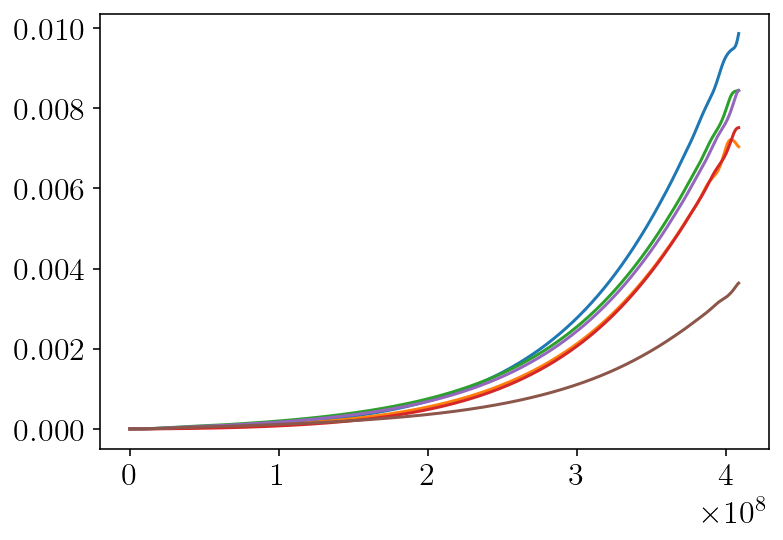

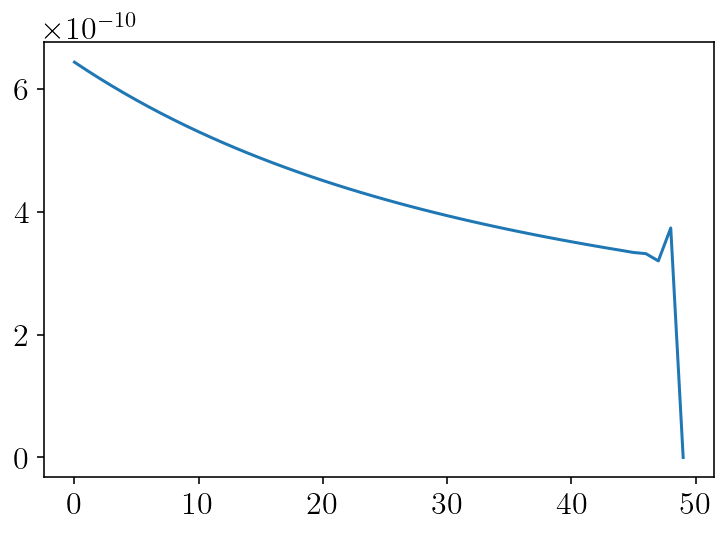

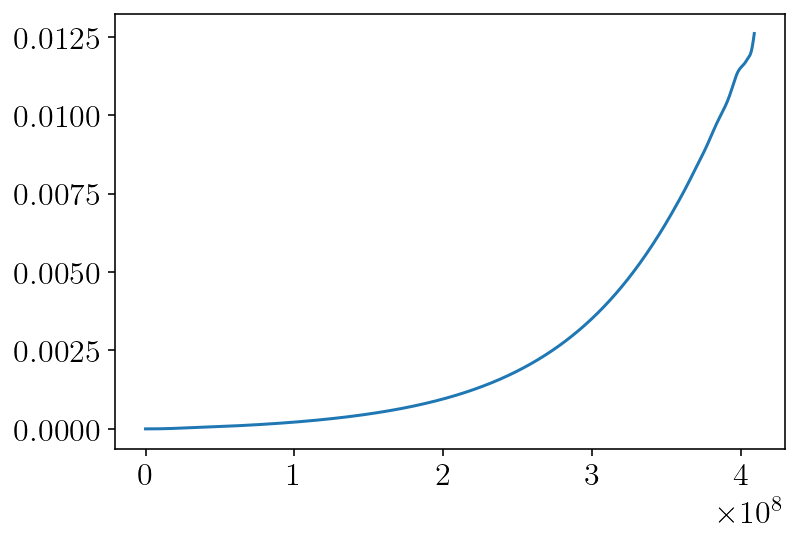

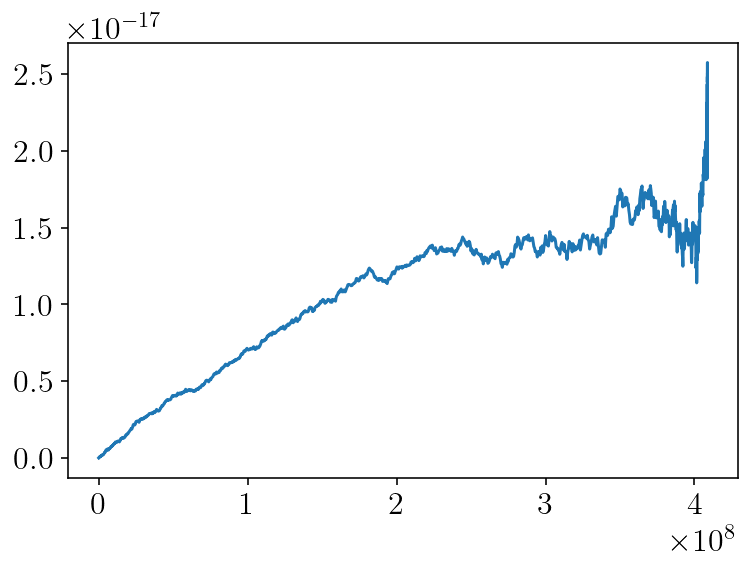

In [ ]:
y_history = np.array(y_history)
t_history = np.array(t_history)
data = y_history[:, :init_slip_deficit.shape[0]]
tips = data.reshape((-1, 6)).dot(Im.T).reshape((t_history.shape[0], -1, 2))
np.testing.assert_allclose(tips[:,:-1, 1], tips[:,1:,0], atol=1e-10)

plt.plot(t_history, data[:, -6:])
plt.show()

plt.plot(tips[50, -50:, 1])
plt.show()

plt.plot(t_history, tips[:, -1, 0])
plt.show()
plt.plot(t_history, tips[:, -1, 1])
plt.show()

## Plotting the results

Now that we've solved for 1000 years of fault slip evolution, let's plot some of the results. I'll start with a super simple plot of the maximum log slip rate over time.

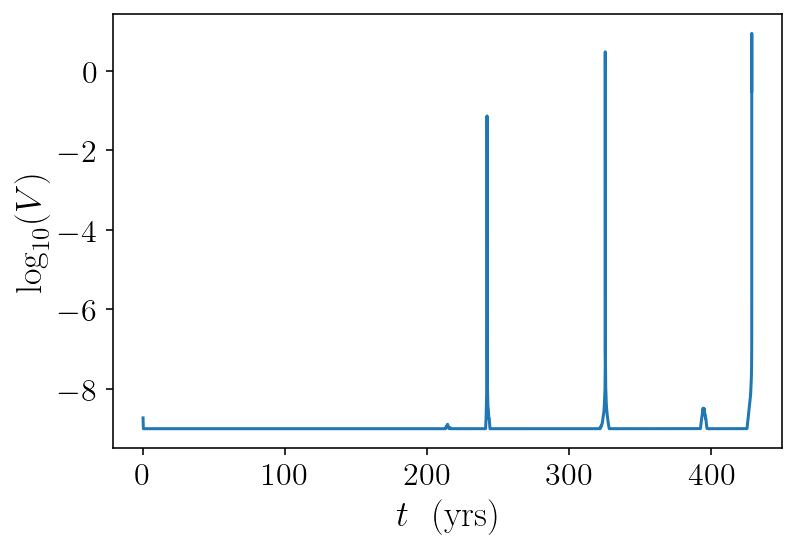

In [ ]:
derivs_history = np.diff(y_history, axis=0) / np.diff(t_history)[:, None]
max_vel = np.max(np.abs(derivs_history), axis=1)
plt.plot(t_history[1:] / siay, np.log10(max_vel))
plt.xlabel('$t ~~ \mathrm{(yrs)}$')
plt.ylabel('$\log_{10}(V)$')
plt.show()

And next, we'll make the classic plot showing the spatial distribution of slip over time:
- the blue lines show interseismic slip evolution and are plotted every fifteen years
- the red lines show evolution during rupture every three seconds.

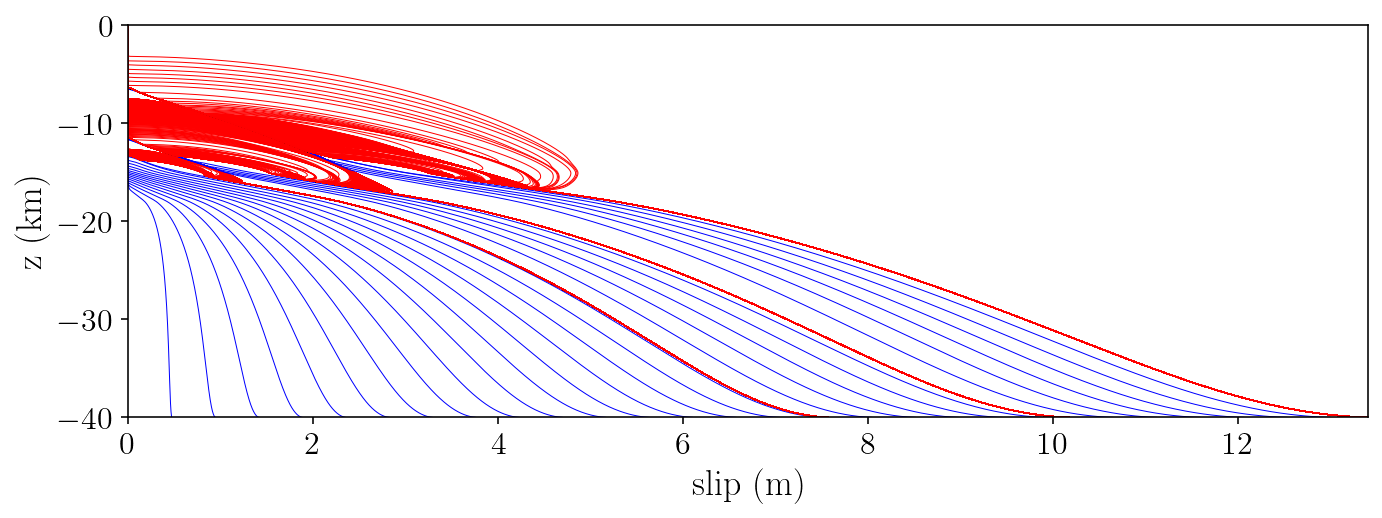

In [ ]:
plt.figure(figsize=(10, 4))
last_plt_t = -1000
last_plt_slip = init_slip_deficit
event_times = []
for i in range(len(y_history) - 1):
    y = y_history[i]
    t = t_history[i]
    slip_deficit = y[: init_slip_deficit.shape[0]]
    should_plot = False

    # Plot a red line every three second if the slip rate is over 0.1 mm/s.
    if (
        max_vel[i] >= 0.0001 and t - last_plt_t > 3
    ):
        if len(event_times) == 0 or t - event_times[-1] > siay:
            event_times.append(t)
        should_plot = True
        color = "r"
    
    # Plot a blue line every fifteen years during the interseismic period
    if t - last_plt_t > 15 * siay:
        should_plot = True
        color = "b"

    if should_plot:
        # Convert from slip deficit to slip:
        slip = -slip_deficit + Vp * t
        plt.plot(slip, fd / 1000.0, color + "-", linewidth=0.5)
        last_plt_t = t
        last_plt_slip = slip
plt.xlim([0, np.max(last_plt_slip)])
plt.ylim([-40, 0])
plt.ylabel(r"$\textrm{z (km)}$")
plt.xlabel(r"$\textrm{slip (m)}$")
plt.tight_layout()
plt.savefig("halfspace.png", dpi=300)
plt.show()

And a plot of recurrence interval:

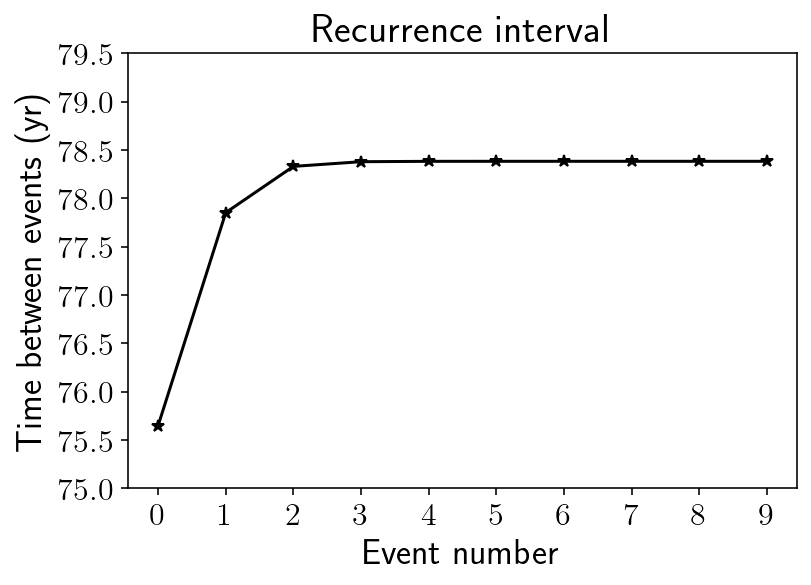

In [ ]:
plt.title("Recurrence interval")
plt.plot(np.diff(event_times) / siay, "k-*")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(75, 80, 0.5))
plt.xlabel("Event number")
plt.ylabel("Time between events (yr)")
plt.show()

## Comparison against SCEC SEAS results

In [ ]:
import numpy as np
ozawa_data = np.loadtxt('bp3-qd-ozawa.3.txt')

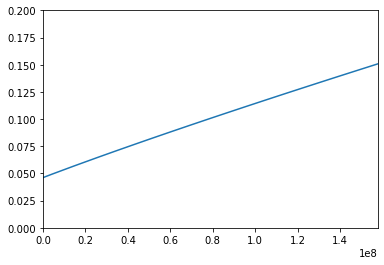

In [ ]:
ozawa_t = ozawa_data[:,0]
ozawa_shear_stress = ozawa_data[:, 3]
siay = 365 * 24 * 3600
import matplotlib.pyplot as plt
plt.plot(ozawa_t, ozawa_shear_stress-26.5)
plt.xlim([0, 5*siay])
plt.ylim([0, 0.2])
plt.show()

In [ ]:
k